In [1]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from selenium import webdriver
from bs4 import BeautifulSoup
import edgar
import time
from pathlib import Path
import pandas as pd
import os
import re
from datetime import datetime
from datetime import date
import json
import requests
import calendar
import sys

In [2]:
key='8NBLCOTKI465W93V'
secKey = "d76154d8c11c709dbdaaa8cdf25c2b69424847ba85f2a569742d588d0d53c8b0"
tblCnt = 0

In [3]:
ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
pprint(data.head(2))

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2022-02-04 20:00:00    305.3    305.3   305.3     305.3      149.0
2022-02-04 19:59:00    305.2    305.2   305.2     305.2      571.0


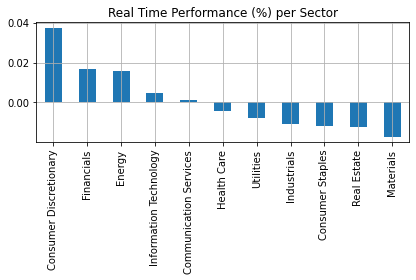

In [4]:
from alpha_vantage.sectorperformance import SectorPerformances
import matplotlib.pyplot as plt

sp = SectorPerformances(key=key, output_format='pandas')
data, meta_data = sp.get_sector()
data['Rank A: Real-Time Performance'].plot(kind='bar')
plt.title('Real Time Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

In [5]:
import requests
url = 'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo'
print(url)

https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol=IBM&apikey=demo


In [6]:
r = requests.get(url)
output = r.json()

In [7]:
print(output["Global Quote"]["05. price"])

137.1500


In [8]:
import pandas as pd
from io import StringIO
url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=MSFT&horizon=3month&apikey=8NBLCOTKI465W93V'
r = requests.get(url)
content = r.text
print(str(content))

symbol,name,reportDate,fiscalDateEnding,estimate,currency
MSFT,Microsoft Corporation,2022-04-25,2022-03-31,2.19,USD



In [9]:
def getQtrsFrmRpt(org, edate, fynd):
    #print(edate)
    dateObj = datetime.strptime(edate, '%Y-%m-%d')
    #print(dateObj.month)
    emonth = dateObj.month
    eyr = dateObj.year
    k = 1
    qend = fynd
    qstart = 0
    year = eyr
    #print(year)
    qtrs = dict()
    while(k!=5):
        #print(k)
        qstart = (qend + 1)%12
        qend = (qend + 3)%12
        if qstart == 0:
            qstart = 12
        if qend == 0:
            qend = 12
        if((emonth >= qstart and emonth <= qend) or (qstart > qend and (emonth >= qstart or emonth <= qend))):
            #print("CQTR:", "Q"+str(k))
            qtrs["CQTR"] = "Q"+str(k)
            qtrs["GQTR"] = "Q"+str(k) # Guidance qtr is same as current qtr
            qtrs["CYR"] = str(year)
            qtrs["GYR"] = str(year) # Guidance year same as current year
            eqtr = (k-1)%4
            if(eqtr == 0):
                eqtr = 4
            nqtr = (k+1)%4
            if(nqtr == 0):
                nqtr = 4
            pqtr = (k-2)%4
            if(pqtr == 0):
                pqtr = 4
            qtrs["EQTR"] = "Q"+str(eqtr)
            qtrs["PQTR"] = "Q"+str(pqtr)
            #print("EQTR:", "Q"+str(eqtr))
            #print("PQTR:", "Q"+str(pqtr))
            #print("NQTR:", "Q"+str(nqtr))
        #print("Q"+str(k), "START", qstart)
        #print("Q"+str(k), "END", qend)
        qtr = "Q"+str(k)
        if (qtr not in qtrs):
            qtrs[qtr] = dict()
        qtrs[qtr]["START"] = qstart
        qtrs[qtr]["SM"] = calendar.month_abbr[qstart].upper()
        qtrs[qtr]["END"] = qend
        qtrs[qtr]["EM"] = calendar.month_abbr[qend].upper()
        #print("Q"+str(k), "YEAR", year)
        k = k + 1
    
    #print(eyr)   
    if("EQTR" in qtrs and "CQTR" in qtrs and "PQTR" in qtrs):
        eqtrEnd = qtrs[qtrs["EQTR"]]["END"]
        cqtrEnd = qtrs[qtrs["CQTR"]]["END"]
        pqtrEnd = qtrs[qtrs["PQTR"]]["END"]
        #print(eqtrEnd, cqtrEnd, pqtrEnd)
        qtrs["EYR"] = str(eyr)
        qtrs["PYR"] = str(eyr)
        #print(eqtrEnd, cqtrEnd, qtrs[qtrs["CQTR"]]["START"], qtrs[qtrs["CQTR"]]["END"])
        if(eqtrEnd > cqtrEnd):
            if(qtrs[qtrs["CQTR"]]["START"] > qtrs[qtrs["CQTR"]]["END"] and emonth > fynd):
                gyr = year + 1
                qtrs["GYR"] = str(gyr)
                qtrs["EYR"] = str(gyr - 1)
            else:
                qtrs["EYR"] = str(eyr - 1)
                qtrs["PYR"] = str(eyr - 1)
        if(pqtrEnd > eqtrEnd):
            qtrs["PYR"] = str(int(qtrs["EYR"]) - 1)
    if(emonth <= fynd):
        qtrs["CFYR"] = str(year)
    else:
        qtrs["CFYR"] = str(year + 1)
    qtrs["FYR"] = qtrs["CFYR"]
    if(qtrs[qtrs["EQTR"]]["END"] <= fynd and qtrs["EQTR"] > qtrs["CQTR"]):
        qtrs["FYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["EFYR"] = qtrs["FYR"]
    qtrs["PFYR"] = qtrs["FYR"]
    if(qtrs["PQTR"] > qtrs["EQTR"]):
        qtrs["PFYR"] = str(int(qtrs["FYR"]) - 1)
    qtrs["GFYR"] = qtrs["CFYR"]
    #qtrs["EYR"] = qtrs["FYR"]
    #qtrs["CYR"] = qtrs["CFYR"]
    #qtrs["PYR"] = qtrs["FYR"]
    qtrs["CYR"] = qtrs["GYR"]
    #print(qtrs)
    return (qtrs)

In [10]:
content = str(content)
f = StringIO(content)
#col_list = ["symbol"]
tbl = pd.read_csv(f, nrows=1)
#print(tbl)
#print(tbl["reportDate"][0])
print (len(tbl["reportDate"]))
if len(tbl["reportDate"]) > 0:
    dateStr = tbl["reportDate"][0]
    print(dateStr)

1
2022-04-25


In [11]:
import datetime
dateStr = datetime.datetime.strptime(dateStr, "%Y-%m-%d").date()
d = dateStr.strftime("%b %d")
print("Output 3:", d)

Output 3: Apr 25


In [12]:
#qtrs = [[1,3],[4,6],[7,9],[10,12]]
months = 12
qtr_len = 3
qtr_no = int(months/qtr_len)
qtrs = list()
start = 0
for i in range(qtr_no):
    qtr = list()
    start = 1 + start
    end = start + 2
    qtr.append(start)
    qtr.append(end)
    qtrs.append(qtr)
    start = end

print(qtrs)
month = 10
for o in qtrs:
    #print (o)
    if month >= o[0] and month <= o[1]:
        print(o)
        break

[[1, 3], [4, 6], [7, 9], [10, 12]]
[10, 12]


In [13]:
def get_qtrs():
    months = 12
    qtr_len = 3
    qtr_no = int(months/qtr_len)
    qtrs = list()
    start = 0
    for i in range(qtr_no):
        qtr = list()
        start = 1 + start
        end = start + 2
        qtr.append(start)
        qtr.append(end)
        qtrs.append(qtr)
        start = end
    return qtrs

In [14]:
def get_qtr_range(month, qtrs):
    #print(month)
    for o in qtrs:
        if month >= o[0] and month <= o[1]:
            return o

In [15]:
def get_stock_earningDate_detail(stock):
    url = 'https://www.alphavantage.co/query?function=EARNINGS_CALENDAR&symbol=' + stock + '&horizon=3month&apikey=8NBLCOTKI465W93V'
    try:
        r = requests.get(url)
        content = r.text
        return content
    except e:
        print(e)
        return None
    return None

In [16]:
import sys
from colorama import Fore, init, Back, Style
import openpyxl
import re

path = "../../Summary/stocks.xlsx"
wb_obj = openpyxl.load_workbook(path.strip())
# from the active attribute 
sheet_obj = wb_obj.active
sheet_obj

<Worksheet "12-Sep-2020">

In [17]:
max_column=sheet_obj.max_column
max_row=sheet_obj.max_row
max_column, max_row

(12, 58)

In [18]:
data = sheet_obj.cell(1,2)
print(data.value)

Quantity


In [19]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
d["Ticker"]

0        NIO
1        BTI
2       ABBV
3        EPD
4        ENB
       ...  
128     DGRO
129     TD6C
130     TDG0
131    PTTRX
132      NaN
Name: Ticker, Length: 133, dtype: object

In [20]:
from datetime import datetime
qtrs = get_qtrs()
print(qtrs)
month = datetime.now().month
year = datetime.now().year
print(month, year)
qtr = get_qtr_range(month, qtrs)
qtr

[[1, 3], [4, 6], [7, 9], [10, 12]]
2 2022


[1, 3]

In [21]:
import math
months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
print(months[qtr[0]], months[qtr[1]])
cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
#cell = months[7]+"-"+months[9]+" "+ str(year)
print(cell)
if cell not in d:
    d[cell] = None
    d.to_csv(path, index=False)
print(d[cell][3])
#if math.isnan(d[cell][3]):
#    print("Hello")

for index, value in enumerate(d[cell]):
    #print(index, value)
    #print(type(value))
    if type(value) is str:
        print(value)

JAN MAR
JAN-MAR 2022
01-Feb - UP (23.7900)
28-Feb
02-Feb - UP (138.6200)
01-Feb - UP (23.7900)
11-Feb
27-Jan - UP (228.0000)
26-Jan - UP (296.71)
17-Feb
16-Mar
04-Feb - UP (64.9900)
17-Feb
27-Jan - UP (319.1700)
09-Feb
14-Mar
09-Mar
17-Feb
02-Mar
23-Feb
01-Feb - DN (132.5700)
03-Feb - UP (27.2500)
14-Feb
07-Mar
09-Mar
26-Jan - DN (829.1000)
16-Feb
22-Feb
09-Feb
09-Feb
28-Feb
23-Feb
15-Feb
16-Feb
26-Jan - UP (228.2200)
16-Feb
21-Feb
28-Feb
23-Feb
07-Feb
22-Feb
14-Feb
08-Feb
28-Feb
08-Feb
03-Feb - UP (138.1800)
08-Feb
10-Feb
08-Mar
28-Mar
07-Mar
09-Mar
16-Feb
21-Mar
08-Mar
02-Mar
22-Feb
10-Feb
22-Feb
01-Feb - UP (118.0100)
02-Feb - DN (128.7200)
23-Feb
14-Feb
16-Feb
15-Feb
23-Feb
17-Feb
01-Mar
28-Feb
23-Feb
14-Feb
10-Feb
21-Feb
01-Feb - UP (128.4400)
18-Feb
01-Mar
02-Feb - DN (237.7600)
21-Feb
01-Mar
22-Mar
14-Feb
22-Feb
23-Feb
23-Feb
08-Feb
09-Feb
22-Feb
23-Feb
03-Feb - UP (38.9100)
09-Feb
16-Feb
27-Jan - UP (170.3300)
26-Jan - UP (528.6900)
22-Mar
17-Mar
23-Feb
05-Feb
10-Feb
23-Feb
09-

In [22]:
def get_dateStr(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    dStr = dateStr.strftime("%d-%b")
    return month, dStr

In [23]:
def get_month(dateStr):
    dateStr = datetime.strptime(dateStr, "%Y-%m-%d").date()
    month = dateStr.month
    #print(month)
    return month

In [24]:
def is_currentQtr(month):
    qtrs = get_qtrs()
    currMonth = datetime.now().month
    qtr = get_qtr_range(currMonth, qtrs)
    earningQtr = get_qtr_range(month, qtrs)
    if qtr == earningQtr:
        return True
    return False

In [25]:
status = is_currentQtr(7)
print(status)

False


In [26]:
from datetime import timedelta
print(d[cell][0])
content = d[cell][0]
if "(" not in content:
    print(True)
    #data = content.split(" ")
    #dateStr = (data[0].strip() + "-" + str(year))
    dateStr = (content.strip() + "-" + str(year))
    print(dateStr)
    dateS = datetime.strptime(dateStr, "%d-%b-%Y").date()
    nextDate = dateS + timedelta(days=1)
    print(str(dateS), str(nextDate))
    date = str(dateS)
    nextDate = str(nextDate)
    #month = date.month
    #dStr = date.strftime("%Y-%m-%d")
    #nStr = nextDate.strftime("%Y-%m-%d")
    #print(dStr)
    #return month, dStr



28-Feb
True
28-Feb-2022
2022-02-28 2022-03-01


In [27]:
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=NIO&apikey=8NBLCOTKI465W93V"
r = requests.get(url)
output = r.json()

#curr = output.get("Time Series (Daily)").get('2021-04-30').get("5. adjusted close")
#prev = output.get("Time Series (Daily)").get('2021-04-29').get("5. adjusted close")
if(output):
    curr = output.get("Time Series (Daily)").get(nextDate).get("5. adjusted close")
    prev = output.get("Time Series (Daily)").get(date).get("5. adjusted close")
    print(curr, prev)
    diff = float(curr) - float(prev)
    print(diff)
    if (diff > 0):
        print("UP")
    elif (diff < 0):
        print(" - DN" + " (" + curr + ")")
    else:
        print("NC")

AttributeError: 'NoneType' object has no attribute 'get'

In [119]:
from datetime import datetime
from datetime import timedelta
import dateutil

def is_earningReport(title, earningDate, newsDate):
    #print(earningDate, newsDate)
    temp = earningDate
    if newsDate != temp:
        temp = temp + timedelta(days=1)
        if newsDate != temp:
            temp = earningDate
            temp = temp + timedelta(days=-1)
            if newsDate != temp:
                return False
    
    words1 = ["Announces", "Reports", "Releases", "Increase", "Raises"]
    words2 = ["Earnings", "Results", "Billable", "Revenue", "Revenues", "Income", "Letter", "Profitability"]
    if any(word.upper() in title.upper() for word in words1) and any(word.upper() in title.upper() for word in words2):
        #print(True)
        return True
    return False

In [29]:
def get_newsMarketTime(hour):
    if (hour > 12):
        return "AH"
    else:
        return "PM"

In [30]:
def get_newsDate(l):
    #print(l)
    interval = l.split(" ")
    num = interval[0]
    dateStr = datetime.now()
    newsDate = None
    #print(dateStr)
    if num == "yesterday":
        newsDate = dateStr + timedelta(days=-1)
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
    elif interval[1] == "days":
        newsDate = dateStr + timedelta(days=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "hours":
        newsDate = dateStr + timedelta(hours=-int(interval[0]))
        newsDate = newsDate + timedelta(hours=-12.30) #For US time
        #print(newsDate)
    elif interval[1] == "months":
        a_month = dateutil.relativedelta.relativedelta(months=int(interval[0]))
        newsDate = dateStr - a_month
    else:
        newsDate = dateStr
        newsDate = newsDate + timedelta(hours=-9.30) #For US Eastern time
        #print(newsDate)
    return newsDate

In [31]:
def get_cell(d):
    qtrs = get_qtrs()
    #print(qtrs)
    month = datetime.now().month
    year = datetime.now().year
    #print(month, year)
    qtr = get_qtr_range(month, qtrs)
    #print(qtr)

    months = ["0", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    #print(months[qtr[0]], months[qtr[1]])
    cell = months[qtr[0]]+"-"+months[qtr[1]]+" "+ str(year)
    
    if cell not in d:
        d[cell] = None
        d.to_csv(path, index=False)
    return cell

In [32]:
import traceback
def getElement(element, source, fromSrc):
    try:
        elem = list()
        soup = BeautifulSoup(source, "html.parser")
        
        if(element == "PREVELEM"):
            cnt = -1
            if(fromSrc == "YH"):
                for t in soup.find_all("div", class_="caas-table"):
                    cnt = cnt + 1
                    if t and t.previous_element:
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                        elem.append(str(t.previous_element).upper())
                    else:
                        elem.append("NONE")
                return(elem)
            else:
                for t in soup.find_all("table"):
                    cnt = cnt + 1
                    if t:
                        sib = t.previous_siblings
                        sibp = t.parent.previous_siblings
                        es = ""
                        for s in sib:
                            if(s and s.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(s.strings).upper())
                                break
                        for r in sibp:
                            if(r and r.name):
                                #print(s)
                                #print(s.text)
                                es = es + " " + str(" ".join(r.strings).upper())
                                break
                        elem.append(es)
                        #print("PREVIOUS ELEMENT "+str(cnt), t.previous_element)
                        #print("\n")
                    else:
                        elem.append("NONE")
                return(elem)
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        return None
    return None

In [33]:
import numpy as np
def findHeaders(table, match):
    hj = -1
    hstart = -1
    hend = -1
    #match = [str(cyr), str(pyr), str(nyr), nbr1, nbr2, nbr3]
    headers = list()
    
    mmatch = list()
    mmatch.append("AMOUNT (MILLIONS)")
    mmatch.append("MARGIN")
    mmatch.append("AMOUNT")
    mmatch.append("AMOUNT ($ MILLIONS)")
    mmatch.append("AMOUNT ($ BILLIONS)")
    mmatch.append("MARGIN (%)")
    
    #print("TABLE BEFORE FINDING HEADER", table)
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            #print(len(str(cell).split(" ")), cell)
            if((len(str(cell).split(" ")) < 10) and (any(qtr.upper() in str(cell).upper() for qtr in match) or (i != 0 and len(headers) > 0 and any(qtr.upper() == str(cell).upper() for qtr in mmatch)))):
                #print("HEADER CELL CENTER", i, j)
                hj = i
                k = i
                hstart = -1
                hend = -1
                metric = table.iloc[k,0]
                # Multiple Headers may present inside single table
                if(len(headers) > 0):
                    #print(metric, k)
                    #hstart = i
                    #print(cell)
                    #print("MATCHHHHHHHHHHH", match)
                    #while((str(metric) == "nan" or str(metric) == cell or not any(qtr in str(cellm) for qtr in match)) and k>=0):
                    while((str(metric) == "nan" or str(metric) == cell) and k>=0):
                        hstart = k 
                        #print("HSTART", hstart)
                        k = k - 1
                        #print(metric, k)
                        if(k>=0):
                            metric = table.iloc[k,0]
                        else:
                            break
                    #if(hstart > 0):
                    #    print("NEW HsTARTTTTT", hstart)
                # Header always start from 0 index
                else:
                    hstart = 0
                if(i+1 < len(table)):
                    k = i+1
                    hend = i
                    metric = table.iloc[k,0]
                    while((str(metric) == "nan" or "THOUSANDS" in str(metric).upper() or "MILLIONS" in str(metric).upper()) and "REVENUE" not in str(metric).upper()):
                        hend = k 
                        #print("HEND", hend)
                        k = k + 1
                        if(k < len(table)):
                            metric = table.iloc[k,0]
                        else:
                            break
                else:
                    hend = i
                #print("HEADER BOUNDARY", hstart, hend)
                if(hstart > -1 and hend > -1):
                    hstr = str(hstart) + ":" + str(hend)
                    if(hstr not in headers):
                        headers.append(hstr)
                    break
    
    for i in range(0,len(table)):
        for j in range(1,len(table.columns)):
            cell = table.iloc[i,j]
            if(table.iloc[i,0] == cell):
                #print(cell)
                table.iloc[i,j] = np.nan
    print("HEADERSSSSSSSSS", headers)            
    return headers,table

In [34]:
def dedupHeaderColumns(header, report):
    mstr = None
    mindex = -1
    lvalidx = -1
    lvalsum = -1
    mdict = dict()
    
    # Check for columns where special character like $ present, need to preserve these columns in header
    rd = report.where(report=="$")
    rd = rd.dropna(axis=1, how="all")
    #print("SPECIAL COLUMNS NEED TO BE PRESERVED")
    #print(rd.columns)
    
    for i,v in enumerate(header.columns):
        #print(i,v)
        #print(header[v].astype(str).values)
        l = " ".join((header[v].astype(str).values))
        #print(l)
        # Find out which consecutive duplicate columns need to be removed
        if not mstr:
            mstr = l
            mindex = i
        else:
            if(l == mstr):
                if(lvalsum == -1):
                    lvalsum = report[v].isna().sum()
                    lvalidx = v
                if mindex not in mdict:
                    mdict[mindex] = list()
                    if(header.columns[i-1] not in rd.columns and v not in rd.columns):
                        if(report[header.columns[i-1]].isna().sum() > lvalsum):
                            mdict[mindex].append(header.columns[i-1])
                        else:
                            mdict[mindex].append(v)
                            lvalsum = report[v].isna().sum()
                            lvalidx = v
                    elif v in rd.columns and header.columns[i-1] in rd.columns:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                    elif v in rd.columns and header.columns[i-1] not in rd.columns:
                        mdict[mindex].append(header.columns[i-1])
                        lvalsum = -2
                        lvalidx = v
                    else:
                        mdict[mindex].append(v)
                        lvalsum = -2
                        lvalidx = header.columns[i-1]
                else:
                    if(report[v].isna().sum() >= lvalsum):
                        mdict[mindex].append(v)
                    else:
                        mdict[mindex].append(lvalidx)
                        lvalsum = report[v].isna().sum()
                        lvalidx = v
            else:
                mstr = l
                mindex = i
                lvalsum = -1
                lvalidx = -1
    #print("DUPLICATE HEADER COLUMNS TO BE DELETED")
    print(mdict)
    for item in mdict:
        header = header.drop(mdict[item], axis=1)
    return header

In [35]:
tableRules = [
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP FINANCIAL", "NON-GAAP OPERATING EXPENSES"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["KEY FINANCIAL RESULT"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP NET INCOME"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["NON-GAAP GROSS PROFIT"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["STATEMENTS OF INCOME"],
        "ACTIONS":["STMTOP"] # Statement of Operation/Income
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"EXACT",
        "CONDITIONS":["ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["BALANCE SHEETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED ADJUSTED GROSS MARGIN"],
        "ACTIONS":["SEGNGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["SEGMENTED GROSS MARGIN"],
        "ACTIONS":["SEGGM"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["EARNINGS BEFORE INTEREST AND TAXES"],
        "ACTIONS":["NGEBIT"]
    },
    {
        "SOURCE":["COLUMN:FIRST"], # Search within original first column name (renamed by "METRIC")
        "MATCH":"ANY",
        "CONDITIONS":["DIVISIONAL REVENUES"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED EBITDA MARGIN"],
        "ACTIONS":["HIGHLIGHT"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["TOTAL CURRENT ASSETS"],
        "ACTIONS":["BALANCESHEET"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["FREE CASH FLOW"],
        "ACTIONS":["FCF"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF REVENUE"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF SALES"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["PER SHARE DATA"],
        "ACTIONS":["PERSHARE"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"ANY",
        "CONDITIONS":["NET INVESTMENT INCOME"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["COST OF GOODS SOLD"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH, ENDING"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["CASH FLOWS FROM OPERATING ACTIVITIES:"],
        "ACTIONS":["STMTCASHFLOW"]
    },
    {
        "SOURCE":["COLUMN:METRIC"], # Search data only from "METRIC" column
        "MATCH":"ANY",
        "CONDITIONS":["ARPU", "DELIVERIES", "MAUS", "LOSS RATIO", "GROSS WRITTEN PREMIUMS", "ACTIVE BUYERS", "ACTIVE CLIENTS", "ASSETS AT FLOATING RATES", "NUMBER OF PORTFOLIO COMPANIES", "TOTAL ORIGINATIONS", "# OF INVESTMENTS"],
        "ACTIONS":["OPMETRIC"]
    },
    {
        "SOURCE":["COLUMN:METRIC"],
        "MATCH":"EXACT",
        "CONDITIONS":["GAAP INCOME FROM OPERATIONS"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["COLUMN:ANY"], # No specific column name, search any column name
        "MATCH":"ANY", # Match any condition
        "CONDITIONS":["GUIDANCE"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GUIDANCE", "OUTLOOK"],
        "ACTIONS":["GUIDANCE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["ADJUSTED EBITDA"],
        "ACTIONS":["NGEBITDA"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["GAAP FINANCIAL METRICS", "EARNINGS PER SHARE RECONCILE"],
        "ACTIONS":["ACCOUNTING"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["NET REVENUE"],
        "ACTIONS":["REVENUE"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY CHANNEL"],
        "ACTIONS":["REVENUECHN"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["REVENUE BY FORM"],
        "ACTIONS":["REVENUEFORM"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"],
        "MATCH":"EXACT",
        "CONDITIONS":["FINANCIAL RESULTS"],
        "ACTIONS":["STMTOP"]
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"EXACT",
        "CONDITIONS":["ADJUSTED GROSS MARGIN"],
        "ACTIONS":["NGGM"] # Non-GAAP Gross Margin
    },
    {
        "SOURCE":["DESCRIPTION:ANY"], # Search table description
        "MATCH":"ANY",
        "CONDITIONS":["OPERATING METRIC"],
        "ACTIONS":["OPMETRIC"]
    }
]
print(tableRules)

[{'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP FINANCIAL', 'NON-GAAP OPERATING EXPENSES'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['KEY FINANCIAL RESULT'], 'ACTIONS': ['HIGHLIGHT']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP NET INCOME'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['NON-GAAP GROSS PROFIT'], 'ACTIONS': ['ACCOUNTING']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['STATEMENTS OF INCOME'], 'ACTIONS': ['STMTOP']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'EXACT', 'CONDITIONS': ['ASSETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['BALANCE SHEETS'], 'ACTIONS': ['BALANCESHEET']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['SEGMENTED ADJUSTED GROSS MARGIN'], 'ACTIONS': ['SEGNGGM']}, {'SOURCE': ['COLUMN:FIRST'], 'MATCH': 'ANY', 'CONDITIONS': ['ADJUSTED GROSS M

In [94]:
import traceback
from datetime import date
def getOneTable(tables, tableNum, tblDesc):
    if not tables:
        print("TABLES CORRUPTED")
        return None
    if(tableNum >= len(tables)):
        print("INVALID TABLE INDEX")
        return None
    try:
        
        todays_date = date.today()
        cyr = todays_date.year
        pyr = cyr - 1
        ppyr = cyr - 2
        nyr = cyr + 1
        nbr = str(nyr)[2:4]
        cbr = str(cyr)[2:4]
        nbr1 = "FY’"+nbr
        nbr2 = "FY"+nbr
        nbr3 = "’"+nbr
        cbr1 = "FY’"+cbr
        cbr2 = "FY"+cbr
        cbr3 = "’"+cbr
        cg = "FY"+cbr+"GUIDANCE"
        ng = "FY"+nbr+"GUIDANCE"
        
        hdmatch = ["FY20", "FY21", cbr1, cbr2, cbr3, "FY19GUIDANCE", "FY20GUIDANCE", "FY21GUIDANCE", cg, ng, str(cyr), str(pyr), str(ppyr), str(nyr), nbr1, nbr2, nbr3, "2019", "2016", "2017", "2018", "FY19", "FY16", "FY17", "FY18"]
        
        mn = ["MILLIONS", "MILLION", "millions", "million"]
        bn = ["BILLIONS", "BILLION", "billions", "billion"]
        t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
        
        stmt = tables[tableNum]
        print("ORIGINAL TABLE ", tableNum)
        print(stmt)
    
        #stmt=stmt.T.drop_duplicates().T
        # Clean first column which could be METRIC column
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].astype(str)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.encode("ascii", "ignore")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].str.decode(encoding="utf8")
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'^\s*$', np.nan, regex=True)
        stmt[stmt.columns[0]] = stmt[stmt.columns[0]].replace(r'nan', np.nan)
        
        stmt = stmt.dropna(axis=1, how="all")
        stmt = stmt.dropna(axis=0, how="all")
        columns = [i for i, x in enumerate(list(stmt.columns))]
        #print(columns)
        stmt.columns = columns
        #print("TABLE AFTER REMOVING DUPLICATE ROWS AND COLUMNS")
        #print(stmt)
    
        headers,stmt = findHeaders(stmt, hdmatch)
        #print(headers)
    
        if(len(headers) == 0):
            print("INVALID TABLE, HEADER NOT FOUND")
            return None
    
        #print("TABLE AFTER REMOVING DUPLICATES")
        #print(stmt)
    
        #Itereate through headers
        cnt = 0
        ft = dict()
        for i in list(headers):
            #print(i)
            tblName = None
            tblType = None
            cnt = cnt + 1
            hstart = int(i.split(":")[0])
            hend = int(i.split(":")[1])
            if(len(headers) > cnt):
                rend = int(headers[cnt].split(":")[0])
            else:
                rend = len(stmt)
            #print("\nHEADER START", hstart, "HEADER END", hend, "REPORT END", rend)
            header = stmt.iloc[hstart:hend+1,0:]
            #header = header.dropna(axis=1, how="all")
            report = stmt.iloc[hend+1:rend,0:]
            #report = report.dropna(axis=1, how="all")
            #print("\nHEADER "+str(cnt))
            #print(header)
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            # Make sure column with valid calendar field is present in subsequent tables
            mfound = False
            if(cnt > 1):
                for i,v in enumerate(header.columns):
                    l = " ".join((header[v].astype(str).values))
                    #print("FOR CNT {}, value is {}".format(cnt, l))
                    if(any(mtch.upper() in l.upper() for mtch in hdmatch)):
                        mfound = True
                        break
                #print("CALENDER FIELD PRESENT: {}".format(mfound))
                if(not mfound):
                    fh = headers[0]
                    fhs = int(fh.split(":")[0])
                    fhe = int(fh.split(":")[1])
                    #print(fhs, fhe)
                    fhd = stmt.iloc[fhs:fhe+1,0:]
                    fhd = fhd.replace(np.nan, "APNATEC")
                    mrowidx = -1
                    #print("FHD\n", fhd)
                    for v in list(fhd.columns):
                        mrows = fhd[fhd[v].str.contains("|".join(hdmatch))]
                        if(len(mrows) > 0):
                            mrow = mrows.iloc[0]
                            mrow = mrow.replace("APNATEC", np.nan)
                            mrowidx = mrows.index[0]
                            #print("MATCH ROW:", mrowidx)
                            break
                    if(mrowidx >= 0):
                        #header = stmt.loc[mrowidx] + header
                        header.loc[len(header.index)] = stmt.loc[mrowidx]
                        #print("NEW HEADER\n", header)
            
            for col in list(report.columns):
                report[report.columns[col]] = report[report.columns[col]].astype(str)
                report[report.columns[col]] = report[report.columns[col]].str.encode("ascii", "ignore")
                report[report.columns[col]] = report[report.columns[col]].str.decode(encoding="utf8")
        
                report[report.columns[col]] = report[report.columns[col]].replace(r'nan', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u200b', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace(r'\\u00a0', np.nan)
                report[report.columns[col]] = report[report.columns[col]].replace("", np.nan)
            
            #print(report.to_json(orient="records"))
            
            header = dedupHeaderColumns(header, report)
            
            #print("\nAFTER DELETING DUPLICATE COLUMN HEADER")
            #print("\nHEADER "+str(cnt))
            #print(header)
            
            if(len(header) == 0):
                print("NO HEADER FOUND")
                return None
            
            header1 = header[0]
            #print("HEADER BATCH 1")
            #print(header1)
            
            header2 = header[header.columns[1:]]
            header2 = header2.dropna(axis=1, how="all")
            
            #print("HEADER BATCH 2 BEFORE DROPPING BASED ON FILTERS\n")
            #print(header2)
            
            hddrop = list()
            newmatch = hdmatch + ["CHANGE", "QOQ", "YOY", "GROWTH", "MARGIN", "MILLIONS", "OUTLOOK"]
            nomatch = ["COMPARED TO", "WAS", "GROSS", "OPERATING", "INCREASED", "DECREASED", "WERE", "HAS", "HAVE"]
            for hd in list(header2.columns):
                header2[hd] = (header2[hd]).astype(str).str.upper()
                mcount = header2[hd].str.contains("|".join(list(map(str.upper,newmatch)))).sum()
                nmcount = header2[hd].str.contains("|".join(list(map(str.upper,nomatch)))).sum()
                #print(hd, mcount, nmcount)
                if(mcount == 0 or nmcount > 0):
                    hddrop.append(hd)
            
            #print("\nINVALID HEADER")
            #print(hddrop)
            header2 = header2.drop(hddrop, axis=1)
            #print("HEADER BATCH 2\n")
            #print(header2)
            
            if(len(header2) == 0 or len(list(header2.columns)) == 0):
                print("NO HEADER FOUND AFTER DROPPING COLUMNS")
                return None
            
            header = pd.concat([header1, header2], axis=1, join='inner')
            header[header.columns[0:]] = header[header.columns[0:]].astype(str)
            #print(header)
            header[header.columns[0:]] = header[header.columns[0:]].applymap(lambda x: re.sub(r'\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'', x))
            #print("FINAL HEADER")
            #print(header)
            
            #report = report.T.drop_duplicates().T
            report = report.dropna(axis=1, how="all")
            
            #print("\nAFTER DELETING DUPLICATE ROWS")
            #print("\nREPORT "+str(cnt))
            #print(report)
            
            if(len(report) > 0):
            
                # Merge REPORT columns present with special characters - e.g. $/% etc...
                rd = report.where(report=="$")
                rd = rd.dropna(axis=1, how="all")
                #print("\nSPECIAL COLUMNS")
                #print(rd.columns)
                dropList = list()
                #print("BEFORE DROPPING COLUMNS FROM REPORT\n", report)
                #print("BEFORE DROPPING COLUMNS FROM RD\n", rd)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "$" else x)
                    k = i + 1
                    while(k in list(rd.columns)):
                        dropList.append(k)
                        #rd.columns = list(rd.columns).remove(k)
                        k = k + 1
                    while(k not in list(report.columns) and k <= max(list(report.columns))):
                        #print(i, k, report[i], report[k])
                        k = k + 1
                    if(k <= max(list(report.columns))):
                        report[i] = report[i] + report[k]
                        dropList.append(k)
                #print(dropList)
                #print(report)
                report = report.drop(dropList, axis=1)
                report[report.columns[1:]] = report[report.columns[1:]].astype(str)
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('$(','-$'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace('(','-'))
                #report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(')',''))
                report[report.columns[1:]] = report[report.columns[1:]].applymap(lambda x: x.replace(',',''))
                report[0] = report[0].str.replace(":","")
                report[0] = report[0].str.replace(r'\d+|\(\d+\)|\(\d+[a-zA-Z]\)*|\*', r'')
                report[0] = report[0].str.upper()
                #report[report.columns[1:]] = report[report.columns[1:]].astype(float)
            
                rd = report.where(report=="%")
                rd = rd.dropna(axis=1, how="all")
                #print(rd)
                dropList = list()
                mgclmn = -1
                #print(rd.columns)
                for i in list(rd.columns):
                    #print(report[i])
                    report[i] = report[i].map(lambda x: "" if str(x) != "%" else x)
                    mgclmn = i - 1
                    while(mgclmn>=0):
                        if mgclmn not in header.columns:
                            mgclmn = mgclmn - 1
                        else:
                            #print(mgclmn,i)              
                            report[mgclmn] = report[mgclmn] + report[i]
                            dropList.append(i)
                            break
                report = report.drop(dropList, axis=1)
                #print("\nREPORT AFTER MERGING SPECIAL COLUMNS")
                #print(report)
            
                hdclmn = header.columns
                rclmn = report.columns
                #print("\nHEADER COLUMNS", hdclmn)
                #print("REPORT COLUMNS", rclmn)
            
                if(len(hdclmn) == 1 and len(header) == 1):
                    #print("SINGLE COLUMN")
                    if(str(header.iloc[0,0]) == "nan"):
                        #print("INVALID HEADER CONTENT FOR SINGLE COLUMN, BAILING OUT")
                        return None
                    s = header.iloc[0,0]
                    #Remove special characters
                    s = re.sub('[^a-zA-Z0-9 \n\.]', '', s)
                    #print(s)
                    data = list()
                    data = [str(s)+"***"+str(item) for item in list(rclmn)]
                    header = pd.DataFrame(np.array([data]),columns=rclmn)
                    hdclmn = header.columns
                    #print("NEW HEADER COLUMNS", hdclmn)
            
            
                finalClmns = hdclmn.intersection(rclmn)
                #print("INTERSECTION COLUMNS",finalClmns)
                header = header[finalClmns]
                #print("FINAL HEADER")
                #print(header)
            
                hstr = list()
            
                count = -1
                for i in list(header.columns):
                    count = count + 1
                    l = header[i].astype(str).values
                    l = ' '.join(dict.fromkeys(l))
                    l = l.replace("-nan","-")
                    l = l.replace("nan-","")
                    l = l.replace("nan ","")
                    l = l.replace(" nan","")
                    l = l.replace(" nan ","")
                    l = l.strip()
                    #print(hstr)
                    if l.upper() in hstr:
                        l = l+"***"+str(count)
                    hstr.append(l.upper())
                    #print(l)
            
                tblType = hstr[0]
                #print("\nORIGINAL FIRST COLUMN NAME")
                #print(tblType)
            
                #print("\nTABLE DESCRIPTION")
                #print(tblDesc)
            
                hstr[0] = "METRIC"
                #print("\nFINAL HEADER STRING")
                #print(hstr)
                
                report = report[finalClmns]
                report.columns = hstr
                print("\nFINAL REPORT")
                print(report)
            
                #print("\nREPORT COLUMNS")
                #print(report.columns)
            else:
                # When entire report rows are detected as header of table
                #print("EMPTY REPORT, ASSIGN HEADER TO REPORT")
                #hstr = list(header.columns)
                print("HEADER FOR EMPTY ROW\n", header)
                hstr = list(header.iloc[0])
                #print(hclmn)
                hstr[0] = "METRIC"
                report = header
                hstr = map(lambda x: str(x), hstr)
                #print("HEADER COLUMNS FOR EMPTY ROW-1", hstr)
                report.columns = (hstr)
                print("\nFINAL REPORT")
                print(report)
                #report.columns[0] = "METRIC"
            
            # Select unit of the table numbers
            unit = "T"
            for word in (mn+bn+t):
                if((hstr and any(word in clmn for clmn in hstr)) or (tblType and word in tblType) or (tblDesc and word in tblDesc) or report["METRIC"].str.contains(word).sum() > 0):
                    if word in mn:
                        unit = "M"
                        break
                    elif word in bn:
                        unit = "B"
                        break
                    else:
                        unit = "T"
                        break
            
            # Select table type
            for item in list(tableRules):
                source = (item["SOURCE"][0])
                stype = item["SOURCE"][0].split(":")[0]
                sval = item["SOURCE"][0].split(":")[1]
                condition = item["CONDITIONS"][0]
                match = item["MATCH"]
                action = item["ACTIONS"][0]
                #print(match, condition, sval)
                #print(condition)
                
                if(stype == "COLUMN"):
                    if(sval == "FIRST"):
                        if match == "EXACT" and tblType and tblType == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblType and any(word in tblType for word in item["CONDITIONS"]):
                            tblName = action
                            break
                    elif(sval != "ANY"):
                        if match == "EXACT" and report[sval].eq(condition).sum()> 0:
                            #print("TABLE NAME BALANCESHEET")
                            tblName = action
                            break
                        elif match == "ANY" and report[sval].str.contains("|".join(item["CONDITIONS"])).sum()> 0:
                            tblName = action
                            break
                    else:
                        if(match == "ANY" and any(s in " ".join(report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                        elif(match == "EXACT" and any(s in (report.columns) for s in item["CONDITIONS"])):
                            tblName = action
                            break
                elif(stype == "DESCRIPTION"):
                    if(sval == "ANY"):
                        #print(match)
                        #print("|".join(item["CONDITIONS"]))
                        if match == "EXACT" and tblDesc and tblDesc == condition:
                            tblName = action
                            break
                        elif match == "ANY" and tblDesc and any(word in tblDesc for word in item["CONDITIONS"]):
                            tblName = action
                            break
                
            if not tblName:
                key = str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+"OTHER"+":"+str(cnt)] = report.to_json(orient="records")
            else:
                key = str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)
                #ft[str(tableNum)+":"+unit+":"+tblName+":"+str(cnt)] = report.to_json(orient="records")
            ft[key] = dict()
            ft[key]["FIRSTCOLUMN"] = tblType
            ft[key]["TABLEDESC"] = tblDesc
            ft[key]["TABLENAME"] = tblName
            ft[key]["SUBTABLE"] = cnt
            ft[key]["UNIT"] = unit
            ft[key]["TABLENUM"] = tableNum
            ft[key]["COLUMNS"] = list(report.columns)
            ft[key]["METRICS"] = report["METRIC"].values.tolist()
            ft[key]["TABLE"] = report.to_json(orient="records")
            #print(ft)
        return(ft)
    except Exception as e:
        print("EXCEPTION:", e)
        print(traceback.format_exc())
        return None

In [92]:
def getPgSource(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    #print(driver.page_source)
    driver.close()
    return(source)

In [38]:
def getAllTables(url, src):
    allTables = dict()
    source = getPgSource(url)
    tables = None
    try:
        tables = pd.read_html(source)
    except:
        tables = None
        return None
    
    print("NUMBER OF TABLES", len(tables))
    allTables["TOTAL"] = len(tables)
    allTables["PARSESUCCESS"] = list()
    allTables["PARSEFAIL"] = list()
    
    tableDesc = getElement("PREVELEM", source, src)
    #print("ALL TABLE DESCRIPTIONS")
    #print(tableDesc)
    
    for i in range(0, len(tables)):
        tableNum = i
        print("\nFOR TABLE", tableNum)
        desc = "NONE"
        if tableDesc and tableNum < len(tableDesc):
            desc = tableDesc[tableNum]
        print("\nTABLE DESCRIPTION:", desc)

        ft = getOneTable(tables, tableNum, desc)
        #print("\n")
        #print(ft)
        if i not in allTables:
            allTables[i] = dict()
        allTables[i]["ORIGINAL"] = tables[tableNum].to_json(orient="records")
        if ft:
            allTables["PARSESUCCESS"].append(i)
            for key in ft:
                tblName = key.split(":")[2]
                #print(tblName)
                if tblName not in allTables:
                    allTables[tblName] = list()
                if "PARSE" not in allTables[i]:
                    allTables[i]["PARSE"] = list()
                if "TYPE" not in allTables[i]:
                    allTables[i]["TYPE"] = list()
                allTables[tblName].append(ft[key])
                allTables[i]["PARSE"].append(ft[key])
                allTables[i]["TYPE"].append(tblName)
        else:
            allTables["PARSEFAIL"].append(i)
        
    return (allTables)

In [95]:
import json
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837019001185/ex-99d1.htm"
url = "https://www.sec.gov/Archives/edgar/data/1699838/000095017021001629/cflt-20210805ex99_1.htm"
#org = "JPM"
dest = "../../Summary/report/"
filename = "FB-REPORT-2021-10-25_13-01-24.640332.txt"
allTables = getAllTables(url, "EDGAR")
#print("\nALL TABLES")
#print(allTables)
#if(allTables):
    #print(data)
#    json_object = json.dumps(allTables, indent = 4)
#    file = dest+filename
  
    # Writing to sample.json
#    with open(file, "w") as outfile:
#        outfile.write(json_object)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  (IN MILLIONS, EXCEPT PER SHARE DATA)
ORIGINAL TABLE  0
                                       0        1        2           3
0                                    NaN      NaN      NaN         NaN
1                                    NaN  Q2 2021  Q2 2020  Y/Y Change
2                          Total Revenue    $88.3    $53.9         64%
3      Remaining Performance Obligations   $327.2   $190.6         72%
4                    GAAP Operating Loss  $(86.0)  $(27.5)     $(58.5)
5                Non-GAAP Operating Loss  $(36.8)  $(20.4)     $(16.4)
6                GAAP Net Loss Per Share  $(0.74)  $(0.25)     $(0.49)
7            Non-GAAP Net Loss Per Share  $(0.31)  $(0.19)     $(0.12)
8  Net Cash Used in Operating Activities  $(43.2)  $(21.5)     $(21.7)
9                         Free Cash Flow  $(45.4)  $(22.7)     $(22.7)
HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                  METRIC  Q2 2021  Q2 2020 Y/Y CHANGE

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                        SUBSCRIPTION   
5                                            SERVICES   
6                                       TOTAL REVENUE   
7                                     COST OF REVENUE   
8                                        SUBSCRIPTION   
9                                            SERVICES   
10                              TOTAL COST OF REVENUE   
11                                       GROSS PROFIT   
12                                 OPERATING EXPENSES   
13                           RESEARCH AND DEVELOPMENT   
14                                SALES AND MARKETING   
15                         GENERAL AND ADMINISTRATIVE   
16                           TOTAL OPERATING EXPENSES   
17                                     OPERATING LOSS   
18                   

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO CASH USED...   
6                       DEPRECIATION AND AMORTIZATION   
7   NET AMORTIZATION OF PREMIUMS OR DISCOUNTS ON M...   
8   AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
9                      NON-CASH OPERATING LEASE COSTS   
10           COMMON STOCK CHARITABLE DONATION EXPENSE   
11  STOCK-BASED COMPENSATION, NET OF AMOUNTS CAPIT...   
12                              DEFERRED INCOME TAXES   
13                                              OTHER   
14        CHANGES IN OPERATING ASSETS AND LIABILITIES   
15                                ACCOUNTS RECEIVABLE   
16                DEFERRED CONTRACT ACQUISITION COSTS   
17                  PREPAID EXPENSES AND OTHE

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                               METRIC  \
3   RECONCILIATION OF GAAP OPERATING LOSS TO NON-G...   
4                      OPERATING LOSS ON A GAAP BASIS   
5                ADD STOCK-BASED COMPENSATION EXPENSE   
6   ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
7        ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
8                             NON-GAAP OPERATING LOSS   
9                           NON-GAAP OPERATING MARGIN   
11  RECONCILIATION OF GAAP NET LOSS TO NON-GAAP NE...   
12                           NET LOSS ON A GAAP BASIS   
13               ADD STOCK-BASED COMPENSATION EXPENSE   
14  ADD EMPLOYER TAXES ON EMPLOYEE STOCK TRANSACTIONS   
15       ADD COMMON STOCK CHARITABLE DONATION EXPENSE   
16             ADD INCOME TAX EFFECTS AND ADJUSTMENTS   
17                                  NON-GAAP NET LOSS   
18  NON-GAAP NET LOSS PER SHARE ATTRIBUTABLE TO CO...   
19  WEIGHTED

In [39]:
def storeRefinedContent(source, url, file):
    soup = BeautifulSoup(source, 'lxml')
    title = soup.find("title")
    title = (title.text)
    with open(file, 'w', encoding = 'utf-8') as f:
        f.write("url="+url)
        f.write("\n")
        f.write(title)
        f.write(".\n")
        list_of_forms = soup.find_all('div', class_="caas-body")
        for item in (list_of_forms):
            children = item.findChildren("p", recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                ctext = (" ".join(ctag.strings))
                ctext = ctext.strip()
                ctext = ctext.replace(u'\xa0', ' ')
                ctext = ("PG*** "+ctext)
                if (ctext[len(ctext)-1]) != ".":
                    ctext = ctext + ".\n"
                else:
                    ctext = ctext + "\n"
                if("Forward-Looking Statements" in ctext or "Forward Looking Statements" in ctext):
                    break
                else:
                    f.write(ctext)

In [40]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import json

def store_earning_news(earningDateStr, stock):
    # Web scrapper for infinite scrolling page 
    url = "https://finance.yahoo.com/quote/" + stock + "/press-releases?p=" + stock
    
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 2 
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web

    i = 1
   
    SCROLL_PAUSE_TIME = 0.5
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    ##### Extract Article Titles #####

    earningDate = datetime.strptime(earningDateStr, '%Y-%m-%d')
    
    news_list = list()
    soup = BeautifulSoup(driver.page_source, "html.parser")

    for t in soup.find_all(class_="Cf"):
        #print(t)
        news = dict()
        a_tag = t.find("a", class_="Fw(b)", href=True)
        #a_tag = t.find("u", class_="StretchedBox")
        if a_tag:
            #print(a_tag)
            text = a_tag.text
            news["Title"] = text
            news["Link"] = "https://finance.yahoo.com" + a_tag["href"]
            news["Provider"] = None
            news["Date"] = None
            news["Content"] = None
        
            provider = t.find("div", class_="C(#959595)")
            if provider:
                c = provider.text
                ctx = (c.encode("ascii", "replace").decode())
                l = ctx.split("?")
                news["Provider"] = l[0]
                news["Date"] = str(get_newsDate(l[1]))
            else:
                continue
        
            p_content = t.find("p", class_="Fz(14px)")
            if p_content:
                c = p_content.text
                news["Content"] = c
        
            newsDateArr = news["Date"].split(" ")
            newsDateStr = newsDateArr[0]
            newsDate = datetime.strptime(newsDateStr, '%Y-%m-%d')
            if not is_earningReport(news["Title"], earningDate, newsDate):
                continue
            else:
                news_list.append(news)
                break
    if(len(news_list) == 0):
        driver.quit()
        return False, None, None

    filename = None
    newsDateStr = None
    try:
        for news in news_list:
            print(news["Link"])
            newsDateArr = news["Date"].split(" ")
            newsTime = newsDateArr[1].replace(":", "-")
            newsDateStr = newsDateArr[0]
            #filename = stock + "-" + earningDateStr + "_" + newsTime + ".txt"
            filename = stock + "-" + newsDateStr + "_" + newsTime + ".txt"
            rptname = stock + "-" + "REPORT" + "-" + newsDateStr + "_" + newsTime + ".txt"
            path = "../../Summary/unsup/"+filename
            rptpath = "../../Summary/report/"+rptname
            rfnpath = "../../Summary/Refined/"+filename
            url = news["Link"]
            driver.get(url)
            time.sleep(5)
    
            soup = BeautifulSoup(driver.page_source, "html.parser")
    
            content = soup.find("div", class_="caas-body")
    
            with open(path, 'x', encoding = 'utf-8') as f:
                newStr = "url="+url
                f.write(newStr)
                f.write("\n")
                if content:
                    #text = content.text
                    text = (" ".join(content.strings))
    
                    text = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",text)
                    #print(text)
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(text)
                else:
                    if "Title" in news:
                        f.write(news["Title"])
                        f.write("\n")
                    f.write(news["Content"])
            
            print("TRYING TO STORE REFINED CONTENT IN FILE {}".format(rfnpath))
            storeRefinedContent(driver.page_source, url, rfnpath)
            
            print("TRYING TO STORE TABLES IN FILE {}".format(rptpath))
            allTables = getAllTables(url, "YH")
            if allTables:
                with open(rptpath, 'x', encoding = 'utf-8') as outfile:
                    json_object = json.dumps(allTables, indent = 4)
                    outfile.write(json_object)
            break
    except Exception as e:
        print(e)
        print(traceback.format_exc())
        driver.quit()
        return False, None, None
                
    driver.quit()
    return True, filename, newsDateStr

In [41]:
from datetime import date
import glob
import holidays

def get_earningDate_quote(content, stock):
    #print(content,stock)
    if type(content) is not str:
        return None
    
    if content and "(" not in content:
        year = datetime.now().year
        dateStr = (content.strip() + "-" + str(year))
        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        
        #print(str(ed))
        
        currDate = date.today()
        #print(currDate)
        
        if(ed>currDate):
            print("Earning for stock {} will be released later on {}".format(stock, str(ed)))
            return None
        
        #filename = "./unsup/EPD-2021-05-03*"
        filename = "../../Summary/unsup/" + stock + "-" + str(ed) + "*"

        names = glob.glob(filename)
        #print(len(names))
        quote = None
        if(len(names) > 0):
            print("Earning report for stock {} on date {} exists".format(stock, str(ed)))

            for name in glob.glob(filename):
                #print(name)
                nArr = name.split("_")
                hour = (int(nArr[1].split("-")[0]))
                break
        else:
            print("Earning report for stock {} on date {} does not exist, trying to fetch it".format(stock, str(ed)))
            res, name, newsDateStr = store_earning_news(str(ed), stock)
            print("Earning report for stock {} fetching status {}, filename {}".format(stock, res, name))
            if not res or not name:
                cd = currDate + timedelta(hours=-9.30)
                #print(str(cd))
                if(ed < cd):
                    month, quote = get_dateStr(str(cd))
                    print("Updating new earning date {} for stock {}".format(quote, stock))
                    return quote
                return None
            print("Earning report for stock {} on date {} fetched, filename {}".format(stock, newsDateStr, name))
            nArr = name.split("_")
            hour = (int(nArr[1].split("-")[0]))
        
            newsDate = datetime.strptime(newsDateStr, "%Y-%m-%d").date()
            
            if (newsDate != ed):
                ed = newsDate
                print("New Earning Date {}".format(str(ed)))
        
        month, quote = get_dateStr(str(ed))
        
        newsHour = get_newsMarketTime(hour)
        print("Earning released for stock {} {}".format(stock, newsHour))
        
        us_holidays = holidays.UnitedStates(years=year)
        if newsHour == "AH":
            nextDate = ed + timedelta(days=1)
        else:
            nextDate = ed + timedelta(days=-1)
            
        while True:
            weekno = nextDate.weekday()         
            if str(nextDate) in us_holidays:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            elif weekno >= 5:
                if newsHour == "AH":
                    nextDate = nextDate + timedelta(days=1)
                else:
                    nextDate = nextDate + timedelta(days=-1)
                continue
            else:
                break
        
        print("Get price diff for stock {} from date {} and date {}".format(stock, str(ed), str(nextDate)))
        
        ed = str(ed)
        nextDate = str(nextDate)
        
        retry = 0
        output = None
        #quote = None
        while(retry < 2):
            try:
                #url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+stock+"&apikey=8NBLCOTKI465W93V"
                r = requests.get(url)
                output = r.json()
                #print(output)
                break
            except e:
                print(e)
                retry = retry + 1
                time.sleep(5)
        if not output:
            return quote
        
        curr = output.get("Time Series (Daily)")
        if curr is None:
            return quote
        curr = curr.get(nextDate)
        if curr is None:
            return quote
        curr = curr.get("4. close")
        if curr is None:
            return quote
        
        prev = output.get("Time Series (Daily)")
        if prev is None:
            return quote
        prev = prev.get(ed)
        if prev is None:
            return quote
        prev = prev.get("4. close")
        if prev is None:
            return quote
        
        #print(curr, prev)
        if not quote:
            return quote
        
        if newsHour == "AH":
            diff = float(curr) - float(prev)
        else:
            diff = float(prev) - float(curr)
        #print(diff)
        if (diff > 0):
            if newsHour == "AH":
                quote = quote + (" - UP" + " (" + curr + ")")
            else:
                quote = quote + (" - UP" + " (" + prev + ")")
        elif (diff < 0):
            if newsHour == "AH":
                quote = quote + (" - DN" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        else:
            if newsHour == "AH":
                quote = quote + (" - NC" + " (" + curr + ")")
            else:
                quote = quote + (" - DN" + " (" + prev + ")")
        #print(quote)
        return (quote)
    
    return None

In [42]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)
quote = get_earningDate_quote(d[cell][75], d["Ticker"][75])
print(quote)

Earning for stock UPST will be released later on 2022-02-15
None


In [43]:
import time

def update_stock_earningDate(d, path, phase=1, updateAll=True):
    RETRY_COUNT = 3
    others = ["SCHB", "SCHD", "SCHA", "SRET", "SCHK", "DGRO", "DBEU", "TD6C", "TDG0", "PTTRX"]

    retry = 0
    status = True
    #pending_stocks = []
    
    stocks = d["Ticker"]
    #print(stocks)
    if(len(stocks) == 0):
        return True
    
    cell = get_cell(d)
    if not cell:
        return True
    
    for index, stock in enumerate(stocks):
        retry = 0
        earningDate = d[cell][index]
        
        if phase==2:
            if type(earningDate) is not str:
                #print("Earning date for stock {} not available".format(stock))
                continue
            quote = get_earningDate_quote(earningDate, stock)
            if quote is not None:
                print("Update Stock {} with quote {}".format(stock, quote))
                d.loc[index, cell] = (quote)
                d.to_csv(path, index=False)
            else:
                if "(" in earningDate:
                    print("Quote for stock {} on earning date {} already generated".format(stock, earningDate))
                else:
                    print("Quote for stock {} on earning date {} not generated yet".format(stock, earningDate))
            continue
        
        if phase==1:
            if type(earningDate) is str and not updateAll:
                continue
                        
            if type(earningDate) is str:
                if "(" in earningDate:
                    continue
        
        if stock in others:
            #print(stock, None)
            continue
        if type(stock) is not str:
            continue
        while(retry <= RETRY_COUNT):
            content = get_stock_earningDate_detail(stock)
            if content:
                content = str(content)
                f = StringIO(content)
                tbl = pd.read_csv(f, nrows=1)
                if "reportDate" in tbl and len(tbl["reportDate"]) > 0:
                    dateStr = tbl["reportDate"][0]
                    month, dateStr = get_dateStr(dateStr)
                    status1 = is_currentQtr(month)
                    print(stock, month, dateStr, status1)
                    if not status1:
                        #print(stock,dateStr)
                        break
                    d.loc[index, cell] = str(dateStr)
                    d.to_csv(path, index=False)
                    time.sleep(5)
                    break
                elif "reportDate" not in tbl:
                    retry = retry + 1
                    if(retry > RETRY_COUNT):
                        print(stock, None)
                        #pending_stocks.append(stock)
                        status = False
                    time.sleep(5)
                    continue
                else:
                    print(stock, None)
                    #pending_stocks.append(stock)
                    status = False
                    time.sleep(5)
                    break
    return status

In [115]:
status = False
retry = 0
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

while(retry < 2):
    if retry == 0:
        status = update_stock_earningDate(d, path, 1, True)
    else:
        status = update_stock_earningDate(d, path, 1, False)
    print(status, retry)
    if(status):
        break
    else:
        retry = retry + 1

print(d[cell])

NIO 2 28-Feb True
BTI None
ABBV 2 02-Feb True
EPD 2 01-Feb True
ENB 2 11-Feb True
KNSL 2 17-Feb True
NKE 3 16-Mar True
BMY 2 04-Feb True
ADYEY None
APPN 2 17-Feb True
CGC 2 09-Feb True
CRWD 3 14-Mar True
DOCU 3 09-Mar True
FVRR 2 17-Feb True
FLGT None
HZNP 2 23-Feb True
JD None
PYPL 2 02-Feb True
PINS 2 03-Feb True
RNG 2 14-Feb True
SFIX None
STNE 3 09-Mar True
TTD 2 16-Feb True
RGEN 2 22-Feb True
TWLO 2 09-Feb True
DIS 2 09-Feb True
ZM None
ZS 2 23-Feb True
ASML None
NVTA 2 15-Feb True
SHOP 2 16-Feb True
WIX 2 16-Feb True
INTU None
MELI 2 28-Feb True
MGNI 2 23-Feb True
PSEC 2 07-Feb True
TDOC 2 22-Feb True
CRSP 2 14-Feb True
PACB None
LMND 2 28-Feb True
PAYC 2 08-Feb True
WD 2 03-Feb True
PTON 2 08-Feb True
QS None
INMD None
RIO None
SKLZ 3 08-Mar True
COIN None
BFLY 3 28-Mar True
CPNG None
XPEV None
EXPI 3 09-Mar True
FSR 2 16-Feb True
GME 3 21-Mar True
AMC 3 08-Mar True
OPEN 3 02-Mar True
IIPR None
BIO 2 10-Feb True
CSPR 2 22-Feb True
MTCH 2 01-Feb True
QRVO 2 02-Feb True
MED 2 23-F

In [181]:
path = "../../Summary/stocks_csv.csv"
d = pd.read_csv(path)

status = update_stock_earningDate(d, path, 2)
print(status)

Earning for stock NIO will be released later on 2022-02-28
Quote for stock NIO on earning date 28-Feb not generated yet
Quote for stock ABBV on earning date 02-Feb - UP (138.6200) already generated
Quote for stock EPD on earning date 01-Feb - UP (23.7900) already generated
Earning for stock ENB will be released later on 2022-02-11
Quote for stock ENB on earning date 11-Feb not generated yet
Quote for stock V on earning date 27-Jan - UP (228.0000) already generated
Quote for stock MSFT on earning date 26-Jan - UP (296.71) already generated
Earning for stock KNSL will be released later on 2022-02-17
Quote for stock KNSL on earning date 17-Feb not generated yet
Earning for stock NKE will be released later on 2022-03-16
Quote for stock NKE on earning date 16-Mar not generated yet
Quote for stock BMY on earning date 04-Feb - UP (64.9900) already generated
Earning for stock APPN will be released later on 2022-02-17
Quote for stock APPN on earning date 17-Feb not generated yet
Quote for stock

{}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                        EXCISE TAXES   
6                                         NET REVENUE   
7                                  COST OF GOODS SOLD   
8                                        GROSS MARGIN   
9                                  OPERATING EXPENSES   
10       SELLING, GENERAL AND ADMINISTRATIVE EXPENSES   
11                           SHARE-BASED COMPENSATION   
12  EXPECTED CREDIT LOSSES ON FINANCIAL ASSETS AND...   
13           ASSET IMPAIRMENT AND RESTRUCTURING COSTS   
14                           TOTAL OPERATING EXPENSES   
15                                     OPERATING LOSS   
16                LOSS FROM EQUITY METHOD INVESTMENTS   
17                        OTHER INCOME (EXPENSE), NET   
18                           LOSS BEFORE INCOME TAXES   
19                                INCOME TAX RECOVERY   
20            

FINAL REPORT
                             METRIC NAN THREE MONTHS ENDED DECEMBER 31, 2021  \
3           GLOBAL CANNABIS SEGMENT                                      nan   
4                       NET REVENUE                                   $82977   
5                COST OF GOODS SOLD                                    94186   
6                      GROSS MARGIN                                  (11209)   
7           GROSS MARGIN PERCENTAGE                                    (14%)   
9   OTHER CONSUMER PRODUCTS SEGMENT                                      nan   
10                          REVENUE                                   $57995   
11               COST OF GOODS SOLD                                    36696   
12                     GROSS MARGIN                                    21299   
13          GROSS MARGIN PERCENTAGE                                      37%   

   NAN THREE MONTHS ENDED DECEMBER 31, 2020  
3                                       nan  
4             

Earning report for stock CGC fetching status True, filename CGC-2022-02-09_05-29-13.176396.txt
Earning report for stock CGC on date 2022-02-09 fetched, filename CGC-2022-02-09_05-29-13.176396.txt
Earning released for stock CGC PM
Get price diff for stock CGC from date 2022-02-09 and date 2022-02-08
Update Stock CGC with quote 09-Feb
Earning for stock CRWD will be released later on 2022-03-14
Quote for stock CRWD on earning date 14-Mar not generated yet
Earning for stock DOCU will be released later on 2022-03-09
Quote for stock DOCU on earning date 09-Mar not generated yet
Earning for stock FVRR will be released later on 2022-02-17
Quote for stock FVRR on earning date 17-Feb not generated yet
Earning for stock FLGT will be released later on 2022-03-02
Quote for stock FLGT on earning date 02-Mar not generated yet
Earning for stock HZNP will be released later on 2022-02-23
Quote for stock HZNP on earning date 23-Feb not generated yet
Quote for stock PYPL on earning date 01-Feb - DN (132.5

FINAL REPORT
                                            METRIC NAN AS OFDECEMBER 31, 2021  \
4                                           ASSETS                        nan   
5                                   CURRENT ASSETS                        nan   
6                        CASH AND CASH EQUIVALENTS                   $1479452   
7                 SHORT-TERM MARKETABLE SECURITIES                    3878430   
8                         ACCOUNTS RECEIVABLE, NET                     388215   
9        PREPAID EXPENSES AND OTHER CURRENT ASSETS                     186131   
10                            TOTAL CURRENT ASSETS                    5932228   
11                     PROPERTY AND EQUIPMENT, NET                     255316   
12                   OPERATING RIGHT-OF-USE ASSETS                     234584   
13                          INTANGIBLE ASSETS, NET                    1050012   
14                                        GOODWILL                    5263166   
15             

{2: [3, 4], 6: [7, 8]}

FINAL REPORT
                                               METRIC  \
4        NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
5                                NON-GAAP ADJUSTMENTS   
6                            STOCK-BASED COMPENSATION   
7                AMORTIZATION OF ACQUIRED INTANGIBLES   
8                        ACQUISITION-RELATED EXPENSES   
9                            CHARITABLE CONTRIBUTIONS   
10  PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION   
11   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
12          INCOME TAX BENEFIT RELATED TO ACQUISITION   
13  PROVISION FOR INCOME TAX EFFECTS RELATED TO NO...   
14  NON-GAAP NET (LOSS) INCOME ATTRIBUTABLE TO COM...   
15  NON-GAAP NET (LOSS) INCOME ATTRIBUTABLE TO COM...   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
18                               NON-GAAP ADJUSTMENTS   
19                           STOCK-BASED COMPENSATION   
20               AMORTIZATION OF ACQUIRED INTANGIBL

Earning report for stock TWLO fetching status True, filename TWLO-2022-02-09_17-30-00.492354.txt
Earning report for stock TWLO on date 2022-02-09 fetched, filename TWLO-2022-02-09_17-30-00.492354.txt
Earning released for stock TWLO AH
Get price diff for stock TWLO from date 2022-02-09 and date 2022-02-10
Update Stock TWLO with quote 09-Feb
Earning report for stock DIS on date 2022-02-09 does not exist, trying to fetch it
https://finance.yahoo.com/news/walt-disney-company-reports-first-210500944.html
TRYING TO STORE REFINED CONTENT IN FILE ../../Summary/Refined/DIS-2022-02-09_17-30-48.695835.txt
TRYING TO STORE TABLES IN FILE ../../Summary/report/DIS-REPORT-2022-02-09_17-30-48.695835.txt
NUMBER OF TABLES 28

FOR TABLE 0

TABLE DESCRIPTION: THE FOLLOWING TABLE SUMMARIZES THE FIRST QUARTER RESULTS FOR FISCAL 2022 AND 2021 (IN MILLIONS, EXCEPT PER SHARE AMOUNTS):
ORIGINAL TABLE  0
                                                   0               1  \
0                                     

HEADERSSSSSSSSS ['0:0']
{}

FINAL REPORT
                                       METRIC JANUARY 1,2022 JANUARY 2,2021  \
1                                     DISNEY+            nan            nan   
2                  DOMESTIC (U.S. AND CANADA)           42.9           36.3   
3   INTERNATIONAL (EXCLUDING DISNEY+ HOTSTAR)           41.1           29.4   
4         DISNEY+ (EXCLUDING DISNEY+ HOTSTAR)           84.0           65.7   
5                             DISNEY+ HOTSTAR           45.9           29.2   
6                               TOTAL DISNEY+          129.8           94.9   
8                                       ESPN+           21.3           12.1   
10                                       HULU            nan            nan   
11                                  SVOD ONLY           40.9           35.4   
12                             LIVE TV + SVOD            4.3            4.0   
13                                 TOTAL HULU           45.3           39.4   

   CHANGE 

{}

FINAL REPORT
                                              METRIC  \
2                AMOUNTS INCLUDED IN SEGMENT RESULTS   
3        DISNEY MEDIA AND ENTERTAINMENT DISTRIBUTION   
4             DISNEY PARKS, EXPERIENCES AND PRODUCTS   
5  AMORTIZATION OF TFCF INTANGIBLE ASSETS RELATED...   
6                  EQUITY IN THE INCOME OF INVESTEES   

  QUARTER ENDED JANUARY 1,2022 QUARTER ENDED JANUARY 2,2021 NAN CHANGE  
2                          nan                          nan        nan  
3                        $ 245                        $ 235        4 %  
4                          (3)                          (8)       63 %  
5                          (3)                          (3)          %  
6                        $ 239                        $ 224        7 %  

FOR TABLE 13

TABLE DESCRIPTION: THE EFFECTIVE INCOME TAX RATE WAS AS FOLLOWS:
ORIGINAL TABLE  13
                                                   0               1  \
0                                    

10                      $ 14488                      $ 17112  

FOR TABLE 20

TABLE DESCRIPTION: THE FOLLOWING TABLE PRESENTS A RECONCILIATION OF THE COMPANY’S CONSOLIDATED CASH PROVIDED BY OPERATIONS TO FREE CASH FLOW (IN MILLIONS):
ORIGINAL TABLE  20
                                                   0               1  \
0                                                NaN   Quarter Ended   
1                                                NaN  January 1,2022   
2  Cash (used in) provided by operations - contin...          $ (209   
3   Investments in parks, resorts and other property            (981   
4                                     Free cash flow        $ (1,190   

                2              3               4               5   6       7  \
0   Quarter Ended  Quarter Ended   Quarter Ended   Quarter Ended NaN     NaN   
1  January 1,2022            NaN  January 2,2021  January 2,2021 NaN  Change   
2               )            NaN            $ 75             NaN NaN  $ (2

{1: [2], 4: [5]}

FINAL REPORT
                                               METRIC  \
4                                OPERATING ACTIVITIES   
5               NET INCOME FROM CONTINUING OPERATIONS   
6                       DEPRECIATION AND AMORTIZATION   
7                      NET (GAIN) LOSS ON INVESTMENTS   
8                               DEFERRED INCOME TAXES   
9                   EQUITY IN THE INCOME OF INVESTEES   
10  CASH DISTRIBUTIONS RECEIVED FROM EQUITY INVESTEES   
11  NET CHANGE IN PRODUCED AND LICENSED CONTENT CO...   
12                          EQUITY-BASED COMPENSATION   
13  PENSION AND POSTRETIREMENT MEDICAL BENEFIT COS...   
14                                         OTHER, NET   
15        CHANGES IN OPERATING ASSETS AND LIABILITIES   
16                                        RECEIVABLES   
17                                        INVENTORIES   
18                                       OTHER ASSETS   
19             ACCOUNTS PAYABLE AND OTHER LIABILITIES   


Update Stock PAYC with quote 08-Feb
Quote for stock WD on earning date 03-Feb - UP (138.1800) already generated
Quote for stock PTON on earning date 08-Feb - UP (37.2700) already generated
Earning report for stock INMD on date 2022-02-10 does not exist, trying to fetch it
Earning report for stock INMD fetching status False, filename None
Quote for stock INMD on earning date 10-Feb not generated yet
Earning for stock SKLZ will be released later on 2022-03-08
Quote for stock SKLZ on earning date 08-Mar not generated yet
Earning for stock BFLY will be released later on 2022-03-28
Quote for stock BFLY on earning date 28-Mar not generated yet
Earning for stock XPEV will be released later on 2022-03-07
Quote for stock XPEV on earning date 07-Mar not generated yet
Earning for stock EXPI will be released later on 2022-03-09
Quote for stock EXPI on earning date 09-Mar not generated yet
Earning for stock FSR will be released later on 2022-02-16
Quote for stock FSR on earning date 16-Feb not gene

HEADERSSSSSSSSS ['0:2']
{2: [3], 5: [6], 8: [9], 11: [12]}

FINAL REPORT
           METRIC NAN THREE MONTHS ENDED DECEMBER 31, 2020  \
4  GROSS BOOKINGS                                      nan   
5        MOBILITY                                    $6789   
6        DELIVERY                                    10050   
7        FREIGHT                                       313   
8           TOTAL                                   $17152   

  NAN THREE MONTHS ENDED DECEMBER 31, 2021 NAN % CHANGE  \
4                                      nan          nan   
5                                   $11340          67%   
6                                    13444          34%   
7                                     1082         245%   
8                                   $25866          51%   

  NAN % CHANGE(CONSTANT CURRENCY)  
4                             nan  
5                             67%  
6                             33%  
7                            245%  
8                  

HEADERSSSSSSSSS ['0:2']
{2: [3, 4], 6: [7, 8], 10: [10]}

FINAL REPORT
                               METRIC  \
4             SEGMENT ADJUSTED EBITDA   
5                            MOBILITY   
6                            DELIVERY   
7                             FREIGHT   
8                           ALL OTHER   
9   CORPORATE G&A AND PLATFORM R&D ,    
10                   ADJUSTED EBITDA    

   NAN THREE MONTHS ENDED DECEMBER 31, 2020  \
4                                       nan   
5                                      $293   
6                                      (145   
7                                       (41   
8                                       (72   
9                                      (489   
10                                    $(454   

   NAN THREE MONTHS ENDED DECEMBER 31, 2021  
4                                       nan  
5                                     $575%  
6                                        25  
7                                      

HEADERSSSSSSSSS ['0:2']
{2: [3, 4], 6: [7, 8], 10: [11, 12], 14: [15, 16]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                  COSTS AND EXPENSES   
5   COST OF REVENUE, EXCLUSIVE OF DEPRECIATION AND...   
6                              OPERATIONS AND SUPPORT   
7                                 SALES AND MARKETING   
8                            RESEARCH AND DEVELOPMENT   
9                          GENERAL AND ADMINISTRATIVE   
10                      DEPRECIATION AND AMORTIZATION   
11                           TOTAL COSTS AND EXPENSES   
12                               LOSS FROM OPERATIONS   
13                                   INTEREST EXPENSE   
14                        OTHER INCOME (EXPENSE), NET   
15  INCOME (LOSS) BEFORE INCOME TAXES AND LOSS FRO...   
16          PROVISION FOR (BENEFIT FROM) INCOME TAXES   
17                LOSS FROM EQUITY METHOD INVESTMENTS   

Earning report for stock UBER fetching status True, filename UBER-2022-02-09_17-33-44.293361.txt
Earning report for stock UBER on date 2022-02-09 fetched, filename UBER-2022-02-09_17-33-44.293361.txt
Earning released for stock UBER AH
Get price diff for stock UBER from date 2022-02-09 and date 2022-02-10
Update Stock UBER with quote 09-Feb
Earning for stock ROKU will be released later on 2022-02-16
Quote for stock ROKU on earning date 16-Feb not generated yet
Quote for stock AAPL on earning date 27-Jan - UP (170.3300) already generated
Quote for stock NOW on earning date 26-Jan - UP (528.6900) already generated
Earning for stock ADBE will be released later on 2022-03-22
Quote for stock ADBE on earning date 22-Mar not generated yet
Earning for stock FDX will be released later on 2022-03-17
Quote for stock FDX on earning date 17-Mar not generated yet
Earning for stock CRM will be released later on 2022-02-23
Quote for stock CRM on earning date 23-Feb not generated yet
Earning report for 

HEADERSSSSSSSSS ['0:2']
{2: [3, 4], 6: [7, 8], 10: [11, 12], 14: [15, 16], 18: [19, 20]}

FINAL REPORT
                                      METRIC  \
4                                    REVENUE   
5                                ONLINE GAME   
6                      ADVERTISING AND OTHER   
7                              TOTAL REVENUE   
8                         COSTS AND EXPENSES   
9                            COST OF REVENUE   
10                  RESEARCH AND DEVELOPMENT   
11                       SALES AND MARKETING   
12                GENERAL AND ADMINISTRATIVE   
13  IMPAIRMENT RELATED TO REAL ESTATE ASSETS   
14                  TOTAL COSTS AND EXPENSES   
15             INCOME (LOSS) FROM OPERATIONS   
16                           INTEREST INCOME   

   NAN THREE MONTHS ENDED DECEMBER 31,2021  \
4                                      nan   
5                                   $534.0   
6                                    161.4   
7                                    695

In [44]:
def get_earningDates(d, when):
    dt = datetime.today()
    stocks = d["Ticker"]
    
    cell = get_cell(d)
    if not cell:
        return None
    
    if(when == "WK"):
        start = dt - timedelta(days=dt.weekday())
        end = start + timedelta(days=6)
    elif (when == "TD"):
        start = dt
        end = start
    elif (when == "TM"):
        start = dt + timedelta(days=1)
        end = start
    elif (when == "YT"):
        start = dt - timedelta(days=1)
        end = start
    else:
        return None

    start = datetime.date(start)
    end = datetime.date(end)
    #print(start)
    #print(end)

    year = dt.year

    result = []
    for index, stock in enumerate(stocks):
        eStr = d[cell][index]
        combo = []
        
        if type(eStr) is not str:
            continue
            
        if "(" in eStr:
            eStr = eStr.split("-")
            #print(eStr)
            dateStr = (eStr[0].strip() + "-" + eStr[1].strip() + "-" + str(year))
        else:
            dateStr = (eStr.strip() + "-" + str(year))

        #print(dateStr)
        try:
            ed = datetime.strptime(dateStr, "%d-%b-%Y").date()
        except:
            ed = datetime.strptime(dateStr, "%d %b-%Y").date()
        #print(ed)

        if ed >= start and ed <= end:
            #print(stock, start, end, ed, True)
            combo.append(stock)
            combo.append(dateStr)
            result.append(combo)
            
    return result

In [180]:
stocks = get_earningDates(d, "YT")
print(stocks, "\n", len(stocks))

[['CGC', '09-Feb-2022'], ['TWLO', '09-Feb-2022'], ['DIS', '09-Feb-2022'], ['ACB', '09-Feb-2022'], ['UBER', '09-Feb-2022'], ['ZNGA', '09-Feb-2022']] 
 6


In [ ]:
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

#nlp = spacy.load("en_core_web_trf")

url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html"
print(url)

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

soup = BeautifulSoup(driver.page_source, "html.parser")
    
content = soup.find("div", class_="caas-body")
#print(content)

if content:
    #print(content.get_text())
    #filename = "PANW-2021-05-20_16-52-59.518356.txt"
    #path = "./unsupnew/"+filename
    output = (" ".join(content.strings))
    
    output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
    print(output)
    
    #with open(path, 'x', encoding = 'utf-8') as f:
    #    f.write(output)
    #soup = BeautifulSoup(content, "html.parser")
    #soup.get_text(separator="\n")
    #print(content.text)
    #doc = nlp(output)
    #sentences = [str(sent).strip() for sent in doc.sents]
    #print(len(sentences))
    #print(sentences)
    
    #for line in sentences:
    #    print("****** {}".format(line))
        
driver.quit()

In [85]:
import os
import re
import time
from selenium import webdriver
from bs4 import BeautifulSoup
import spacy

files_link = [
              "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html",
              "https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html",
              "https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html",
              "https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html",
              "https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html",
              "https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html",
              "https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html",
              "https://finance.yahoo.com/news/casper-reports-first-quarter-2021-103000149.html",
              "https://finance.yahoo.com/news/walt-disney-company-reports-second-200500011.html",
              "https://finance.yahoo.com/news/draftkings-reports-first-quarter-2021-110000293.html",
              "https://finance.yahoo.com/news/enbridge-reports-strong-first-quarter-110000848.html",
              "https://finance.yahoo.com/news/enterprise-reports-first-quarter-2021-100000525.html",
              "https://finance.yahoo.com/news/etsy-inc-reports-first-quarter-200500590.html",
              "https://finance.yahoo.com/news/exp-world-holdings-reports-record-123000146.html",
              "https://finance.yahoo.com/news/fulgent-genetics-reports-record-first-200500258.html",
              "https://finance.yahoo.com/news/farfetch-announces-first-quarter-2021-200600856.html",
              "https://finance.yahoo.com/news/fiverr-announces-first-quarter-2021-050000648.html",
              "https://finance.yahoo.com/news/hubspot-reports-q1-2021-results-201000012.html",
              "https://finance.yahoo.com/news/havertys-reports-first-quarter-2021-204000308.html",
              "https://finance.yahoo.com/news/horizon-therapeutics-plc-reports-first-110000158.html",
              "https://finance.yahoo.com/news/innovative-industrial-properties-reports-first-200600167.html",
              "https://finance.yahoo.com/news/inmode-reports-first-quarter-2021-111500734.html",
              "https://finance.yahoo.com/news/jd-com-announces-first-quarter-105300974.html",
              "https://finance.yahoo.com/news/lemonade-announces-first-quarter-2021-210000181.html",
              "https://finance.yahoo.com/news/medifast-inc-announces-first-quarter-200500463.html",
              "https://finance.yahoo.com/news/mercadolibre-inc-reports-first-quarter-213000148.html",
              "https://finance.yahoo.com/news/magnite-reports-first-quarter-2021-200500357.html",
              "https://finance.yahoo.com/news/match-group-reports-first-quarter-201100924.html",
              "https://finance.yahoo.com/news/nanox-announces-first-quarter-2021-110000907.html",
              "https://finance.yahoo.com/news/invitae-reports-103-6-million-200500995.html",
              "https://finance.yahoo.com/news/palo-alto-networks-reports-fiscal-200500317.html",
              "https://finance.yahoo.com/news/paycom-software-inc-reports-first-200500900.html",
              "https://finance.yahoo.com/news/palantir-reports-49-revenue-growth-110000817.html",
              "https://finance.yahoo.com/news/prospect-capital-releases-march-2021-203600447.html",
              "https://finance.yahoo.com/news/paypal-reports-first-quarter-2021-201600784.html",
              "https://finance.yahoo.com/news/qorvo-announces-fiscal-2021-fourth-200000135.html",
              "https://finance.yahoo.com/news/quantumscape-announces-first-quarter-2021-201500516.html",
              "https://finance.yahoo.com/news/repligen-reports-first-quarter-2021-113000798.html",
              "https://finance.yahoo.com/news/ringcentral-announces-first-quarter-2021-200600324.html",
              "https://finance.yahoo.com/news/roku-releases-first-quarter-2021-200300047.html",
              "https://finance.yahoo.com/news/revolve-group-announces-first-quarter-200500204.html",
              "https://finance.yahoo.com/news/square-inc-announces-first-quarter-200600101.html",
              "https://finance.yahoo.com/news/trade-desk-reports-first-quarter-123000864.html",
              "https://finance.yahoo.com/news/twilio-announces-first-quarter-2021-201000982.html",
              "https://finance.yahoo.com/news/uber-announces-results-first-quarter-200500302.html",
              "https://finance.yahoo.com/news/vir-biotechnology-provides-corporate-reports-200500093.html",
              "https://finance.yahoo.com/news/walker-dunlop-reports-20-growth-100000820.html",
              "https://finance.yahoo.com/news/wix-reports-first-quarter-2021-050000836.html",
              "https://finance.yahoo.com/news/ww-announces-first-quarter-2021-200100511.html",
              "https://finance.yahoo.com/news/zynga-announces-first-quarter-2021-200500864.html",
             ]

skip_list = ["AAPL", "ABBV", "CMG", "ASML", "ISRG", "INTC", "LRCX", 
             "KNSL", "LRN", "NIO", "MSFT", "NOW", "PACB", "PINS", "SHOP", "SIVB", "SNAP", 
             "TDOC", "TEAM", "TSLA", "V", "VRTX", "PTON"]
print(len(files_link), len(skip_list))

path = "../../Summary/unsup"
newpath = "../../Summary/unsupnew/"


cnt = 0
for fname in os.listdir(path):
    #print(fname)
    nf = os.path.join(newpath, fname)
    words = fname.split("-")
    stock = words[0]
    print(stock, nf, files_link[cnt])
    driver = webdriver.Chrome()    
    
    url = files_link[cnt]
    #print(url)

    driver.get(url)
    time.sleep(3)

    soup = BeautifulSoup(driver.page_source, "html.parser")
    
    content = soup.find("div", class_="caas-body")
    
    if content:
    
        output = (" ".join(content.strings))
    
        output = re.sub(r'Forward-Looking Statements.*|Forward Looking Statements.*',"",output)
    
        #print(output)
    
        with open(nf, 'x', encoding = 'utf-8') as f:
            f.write(output)
    
    driver.quit()
    cnt = cnt + 1
    
print(cnt)

50 23
ACB ./unsupnew/ACB-2021-05-13_16-52-59.518356.txt https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500266.html
AMAT ./unsupnew/AMAT-2021-05-20_13-28-46.962705.txt https://finance.yahoo.com/news/applied-materials-announces-second-quarter-200100432.html
ANET ./unsupnew/ANET-2021-05-04_16-29-14.279301.txt https://finance.yahoo.com/news/arista-networks-inc-reports-first-200500732.html
APPN ./unsupnew/APPN-2021-05-06_13-01-52.344079.txt https://finance.yahoo.com/news/appian-announces-first-quarter-2021-200100501.html
BABA ./unsupnew/BABA-2021-05-13_07-54-38.989614.txt https://finance.yahoo.com/news/alibaba-group-announces-march-quarter-112200701.html
BMY ./unsupnew/BMY-2021-04-29_14-18-33.950906.txt https://finance.yahoo.com/news/bristol-myers-squibb-reports-first-105900221.html
BYND ./unsupnew/BYND-2021-05-06_13-06-00.598192.txt https://finance.yahoo.com/news/beyond-meat-reports-first-quarter-200500876.html
CSPR ./unsupnew/CSPR-2021-05-13_07-52-27.895874.txt ht

In [49]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

#url = (
#    "https://raw.githubusercontent.com/pandas-dev/pandas/master/"
#    "pandas/tests/io/data/html/spam.html"
#)

#url = "https://finance.yahoo.com/quote/SFIX/analysis?p=SFIX"
#url = "https://finance.yahoo.com/quote/SFIX/profile?p=SFIX"
#url = "https://finance.yahoo.com/quote/PINS/holders?p=PINS"
url = "https://finance.yahoo.com/quote/PINS/insider-roster?p=PINS"
#url = "https://finance.yahoo.com/quote/SFIX/key-statistics?p=SFIX"

driver = webdriver.Chrome()

driver.get(url)
time.sleep(2)

source = driver.page_source
#print(driver.page_source)
driver.close()
#Executive_pay
#profile = pd.read_html(url)
#profile

In [50]:
profile = pd.read_html(source)
#print(len(profile), profile)
print(profile[0], profile[0].columns[0], profile[0].iloc[0,0], profile[0].iloc[1,0])
#print(profile[0],"\n")
#print(profile[0].loc[1])
#df = profile[0].loc[1]
#print(df, type(df), type(profile))
#print(df.loc["Current Qtr. (Sep 2021)"])
#print(profile[1].iloc[1,0], profile[1].columns[1], profile[1].iloc[1,1], profile[1].iloc[1,2], profile[1].iloc[1,3])
#print(df.loc["Current Qtr. *"])
#print(df["Avg. Estimate"])

                                Individual or Entity  \
0                    FLORES CHRISTINEGeneral Counsel   
1                               GAVINI NAVEENOfficer   
2                        KILGORE LESLIE JEANDirector   
3           MORGENFELD TODD RChief Financial Officer   
4                              RAJARAM GOKULDirector   
5                         REYNOLDS FREDRIC GDirector   
6                             YANG TSELI LILYOfficer   
7  *Insider roster data is derived solely from th...   

                             Most Recent Transaction  \
0                                               Sale   
1                                               Sale   
2                                 Stock Award(Grant)   
3                                               Sale   
4                                 Stock Award(Grant)   
5                                 Stock Award(Grant)   
6                                               Sale   
7  *Insider roster data is derived solely from 

In [47]:
DataExtract = [
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/profile?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"PROFILE",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"EXECS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"INSIDERTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"TRANSSTAT"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"MAJORTRANS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"ROSTERS"
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/holders?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"HOLDERS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":-1,
                            "COLUMN":-1,
                            "MATCH":None,
                            "ALIAS":"INST"
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY ALL INSIDER",
                            "ALIAS":"INSIDERHELDPCT",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":1,
                            "MATCH":"SHARES HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDPCT",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":1,
                            "MATCH":"FLOAT HELD BY INSTITUTIONS",
                            "ALIAS":"INSTHELDFLTPCT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":1,
                            "MATCH":"NUMBER OF INSTITUTIONS",
                            "ALIAS":"INSTNUM",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":0
                            }
                        }
                    }
                ]
            }
        ]
    },
    {
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/analysis?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"ANALYSIS",
            "TYPE":"FRAME"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-ACT-HIST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST-HIST",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"REVENUE-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":1,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":2,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":2
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":3,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":3
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "COLUMN":4,
                            "MATCH":None,
                            "ALIAS":None,
                            "NAME":"EPS-EST",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":4
                            }
                        }
                    }
                ]
            }
        ]
    },
    {      
        "SOURCE":
        {
            "URL":"https://finance.yahoo.com/quote/*ORG/key-statistics?p=*ORG"
        },
        "TABLE":
        {
            "NAME":"STATS",
            "TYPE":"SERIES"
        },
        "TUPLES":[
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":9
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"LEVERED FREE CASH FLOW",
                            "ALIAS":"FCF",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH",
                            "ALIAS":"CASH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"TOTAL CASH PER SHARE",
                            "ALIAS":"CASHPERSHARE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":2,
                            "COLUMN":0,
                            "MATCH":"TOTAL DEBT",
                            "ALIAS":"DEBT",
                            "VALUE":
                            {
                                "ROW":2,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":8
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":4,
                            "COLUMN":0,
                            "MATCH":"CURRENT RATIO",
                            "ALIAS":"CURRATIO",
                            "VALUE":
                            {
                                "ROW":4,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"RETURN ON ASSETS",
                            "ALIAS":"ROA",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":6
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"RETURN ON EQUITY",
                            "ALIAS":"ROE",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"FISCAL YEAR ENDS",
                            "ALIAS":"FISCALYEND",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":4
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"MOST RECENT QUARTER",
                            "ALIAS":"MRQ",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"FORWARD ANNUAL DIVIDEND YIELD",
                            "ALIAS":"FDIVYLD",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":3,
                            "COLUMN":0,
                            "MATCH":"TRAILING ANNUAL DIVIDEND YIELD",
                            "ALIAS":"TDIVYLD",
                            "VALUE":
                            {
                                "ROW":3,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PAYOUT RATIO",
                            "ALIAS":"PAYOUTRATIO",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"DIVIDEND DATE",
                            "ALIAS":"DIVDATE",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":3
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":7,
                            "COLUMN":0,
                            "MATCH":"EX-DIVIDEND DATE",
                            "ALIAS":"EXDIVDATE",
                            "VALUE":
                            {
                                "ROW":7,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"MARKET CAP",
                            "ALIAS":"MCAP",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":0
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"PRICE/SALES",
                            "ALIAS":"PS",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":5,
                            "COLUMN":0,
                            "MATCH":"50-DAY MOVING AVERAGE",
                            "ALIAS":"50DMA",
                            "VALUE":
                            {
                                "ROW":5,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":1
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":6,
                            "COLUMN":0,
                            "MATCH":"200-DAY MOVING AVERAGE",
                            "ALIAS":"200DMA",
                            "VALUE":
                            {
                                "ROW":6,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":0,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (3 MONTH)",
                            "ALIAS":"AVGVOL3MONTH",
                            "VALUE":
                            {
                                "ROW":0,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":1,
                            "COLUMN":0,
                            "MATCH":"AVG VOL (10 DAY)",
                            "ALIAS":"AVGVOL10DAY",
                            "VALUE":
                            {
                                "ROW":1,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":9,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF FLOAT",
                            "ALIAS":"SHORTPCTFLOAT",
                            "VALUE":
                            {
                                "ROW":9,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            },
            {
                "CONDITIONS":[
                    {
                        "TABLENUM":2
                    }
                ],
                "ACTIONS":[
                    {
                        "KEY":
                        {
                            "ROW":10,
                            "COLUMN":0,
                            "MATCH":"SHORT % OF SHARES OUTSTANDING",
                            "ALIAS":"SHORTPCTOUST",
                            "VALUE":
                            {
                                "ROW":10,
                                "COLUMN":1
                            }
                        }
                    }
                ]
            }
        ]
    }
]
print(DataExtract)

[{'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/profile?p=*ORG'}, 'TABLE': {'NAME': 'PROFILE', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'EXECS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-transactions?p=*ORG'}, 'TABLE': {'NAME': 'INSIDERTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'TRANSSTAT'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/insider-roster?p=*ORG'}, 'TABLE': {'NAME': 'MAJORTRANS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 0}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUMN': -1, 'MATCH': None, 'ALIAS': 'ROSTERS'}}]}]}, {'SOURCE': {'URL': 'https://finance.yahoo.com/quote/*ORG/holders?p=*ORG'}, 'TABLE': {'NAME': 'HOLDERS', 'TYPE': 'SERIES'}, 'TUPLES': [{'CONDITIONS': [{'TABLENUM': 1}], 'ACTIONS': [{'KEY': {'ROW': -1, 'COLUM

In [48]:
import pandas as pd
import os
import re
import time
from selenium import webdriver

def GetTables(url):
    driver = webdriver.Chrome()

    driver.get(url)
    time.sleep(2)

    source = driver.page_source
    try:
        table = pd.read_html(source)
    except:
        return None
    #print(driver.page_source)
    driver.close()
    return table

In [49]:
def getOrgProfile(org):
    try:
        url = "https://www.alphavantage.co/query?function=OVERVIEW&symbol="+org+"&apikey=8NBLCOTKI465W93V"
        r = requests.get(url)
        data = r.json()
        return data
    except Exception as e:
        print(e)
        return None

In [50]:
def getOrgData(org):
    data = dict()
    orgProfile = getOrgProfile(org)
    if (not orgProfile):
        return None
    if("Symbol" not in orgProfile):
        print("INVALID PROFILE DATA, BAILING OUT")
        return None
    data["ORGPROFILE"] = orgProfile
    data["ORGPROFILE"]["SOURCE"] = "AD" #Alphaadvantage API
    today = date.today()
    tstr = today.strftime("%B %d, %Y")
    data["LASTUPDATE"] = tstr
    for idx,rule in enumerate(DataExtract):
        #print(rule["SOURCE"]["URL"])
        url = rule["SOURCE"]["URL"]
        url = url.replace("*ORG", org)
        print(url)
        table = GetTables(url)
        if not table:
            continue
        #print(table)
        tableName = rule["TABLE"]["NAME"]
        tableType = rule["TABLE"]["TYPE"]
        print("TABLE NAME", tableName)
        data[tableName] = dict()
        if ("yahoo" in url):
            data[tableName]["SOURCE"] = "YH"
        #print(rule["TUPLES"])
        for tidx,tple in enumerate(rule["TUPLES"]):
            #print(tple)
            found = False
            for cidx,cnd in enumerate(tple["CONDITIONS"]):
                #print(cnd)
                if "TABLENUM" in cnd:
                    print("Table Number", cnd["TABLENUM"])
                    tableNum = cnd["TABLENUM"]
                    if len(table) >= tableNum:
                        found = True
                        print("FOUND")
                    break
            if(found):
                for aidx,act in enumerate(tple["ACTIONS"]):
                    #print(act)
                    if "KEY" in act:
                        if tableType == "SERIES":
                            rowKey = act["KEY"]["ROW"]
                            columnKey = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                    
                            if(rowKey == -1 and columnKey == -1 and alias):
                                data[tableName][alias] = table[tableNum].to_json(orient="records")
                            else:
                                key = table[tableNum].iloc[rowKey,columnKey]
                                if(not matchRegex or (matchRegex and matchRegex in key.upper())):
                                    valueRow = act["KEY"]["VALUE"]["ROW"]
                                    valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                    value = table[tableNum].iloc[valueRow,valueColumn]
                                    print(rowKey, columnKey, key.upper(), valueRow, valueColumn, value)
                                    data[tableName][alias] = value
                        elif tableType == "FRAME":
                            columnNum = act["KEY"]["COLUMN"]
                            matchRegex = act["KEY"]["MATCH"]
                            alias = act["KEY"]["ALIAS"]
                            keyName = act["KEY"]["NAME"]
                            column = table[tableNum].columns[columnNum]
                        
                            if keyName not in data[tableName]:
                                data[tableName][keyName] = dict()
                        
                            if(not matchRegex or (matchRegex and matchRegex in column.upper())):
                                valueRow = act["KEY"]["VALUE"]["ROW"]
                                valueColumn = act["KEY"]["VALUE"]["COLUMN"]
                                value = table[tableNum].iloc[valueRow,valueColumn]
                                print(columnNum, column.upper(), valueRow, valueColumn, value)
                                if(alias):
                                    data[tableName][keyName][alias] = value
                                else:
                                    data[tableName][keyName][column] = value
    return data

In [338]:
import json
org = "NET"
data = getOrgData(org)
dest = "../../Summary/orgData/"
if(data):
    print(data)
    json_object = json.dumps(data, indent = 4)
    file = dest+org+".txt"
  
    # Writing to sample.json
    with open(file, "w") as outfile:
        outfile.write(json_object)

https://finance.yahoo.com/quote/NET/profile?p=NET
TABLE NAME PROFILE
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-transactions?p=NET
TABLE NAME INSIDERTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/insider-roster?p=NET
TABLE NAME MAJORTRANS
Table Number 0
FOUND
https://finance.yahoo.com/quote/NET/holders?p=NET
TABLE NAME HOLDERS
Table Number 1
FOUND
Table Number 0
FOUND
0 1 % OF SHARES HELD BY ALL INSIDER 0 0 6.50%
Table Number 0
FOUND
1 1 % OF SHARES HELD BY INSTITUTIONS 1 0 87.32%
Table Number 0
FOUND
2 1 % OF FLOAT HELD BY INSTITUTIONS 2 0 93.40%
Table Number 0
FOUND
3 1 NUMBER OF INSTITUTIONS HOLDING SHARES 3 0 839
https://finance.yahoo.com/quote/NET/analysis?p=NET
TABLE NAME ANALYSIS
Table Number 2
FOUND
1 12/30/2020 1 1 -0.02
Table Number 2
FOUND
2 3/30/2021 1 2 -0.03
Table Number 2
FOUND
3 6/29/2021 1 3 -0.02
Table Number 2
FOUND
4 9/29/2021 1 4 0
Table Number 2
FOUND
1 12/30/2020 0 1 -0.03
Table Number 2
FOUND
2 3/30/2021 0 2 -0.03
Table Numb

In [42]:
#url = "https://finance.yahoo.com/news/pinterest-announces-second-quarter-2021-200500141.html"
#url = "https://finance.yahoo.com/news/crowdstrike-reports-second-quarter-fiscal-200500508.html"
#url = "https://finance.yahoo.com/news/stitch-fix-announces-fourth-quarter-200500527.html"
#url = "https://finance.yahoo.com/news/aurora-cannabis-announces-fiscal-2021-201500038.html"
#url = "https://finance.yahoo.com/news/canopy-growth-reports-first-quarter-110000649.html"
#url = "https://finance.yahoo.com/news/nike-inc-reports-fiscal-2022-201500472.html"
#url = "https://finance.yahoo.com/news/prospect-capital-announces-june-2021-230600417.html"
#url = "https://finance.yahoo.com/news/fiverr-announces-second-quarter-2021-050000560.html"
#url = "https://finance.yahoo.com/news/trade-desk-reports-second-quarter-123000360.html"
#url = "https://finance.yahoo.com/news/zoom-reports-financial-results-second-200500829.html"
#url = "https://finance.yahoo.com/news/kinsale-capital-group-inc-reports-201000573.html"
#url = "https://finance.yahoo.com/news/docusign-announces-second-quarter-fiscal-200500098.html"
#url = "https://finance.yahoo.com/news/nio-inc-reports-unaudited-second-213000202.html"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752320000277/a52180507_ex991.htm"
url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
source = getPgSource(url)
tables = None
try:
    tables = pd.read_html(source)
except:
    tables = None
print(len(tables))

6


In [61]:
tableDesc = getElement("PREVELEM", source, "EDGAR")
print("ALL TABLE DESCRIPTIONS")
print(tableDesc)
tableNum = 0
desc = "NONE"
if tableDesc and tableNum < len(tableDesc):
    desc = tableDesc[tableNum]
print("\nTABLE DESCRIPTION:", desc)

ft = getOneTable(tables, tableNum, desc)
print("\n")
print(ft)

ALL TABLE DESCRIPTIONS
[' \n      THE FOLLOWING TABLE SUMMARIZES OUR CONSOLIDATED FINANCIAL RESULTS FOR\n      THE QUARTERS AND FISCAL YEARS ENDED DECEMBER 31, 2018 AND 2017 ($ IN\n      MILLIONS, EXCEPT PER SHARE AMOUNTS):\n    ', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', ' \n      THE FOLLOWING TABLES SHOW THE COMPANY’S GAAP FINANCIAL METRICS\n      RECONCILED TO NON-GAAP FINANCIAL METRICS INCLUDED IN THIS RELEASE.\n    ', ' \n \n \n \n \n \n          \xa0\n         \n \n THREE MONTHS ENDED \n \n \n \n \n          \xa0\n         \n \n YEAR ENDED \n \n \n \n \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n DECEMBER 31, \n \n \n \n \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n 2018 \n \n \n \n \n          \xa0\n         \n \n 2017 \n \n \n \n \n \n \n \n \n \n \n \n \n          \xa0\n         \n \n \n \n          NET 

In [51]:
def getRiskFactors(source):
    try:
        soup = BeautifulSoup(source, 'lxml')
        list_of_forms = soup.find_all('div')
    except (Exception) as e:
        print(e)
        list_of_forms = None
        return None

    found = False
    riskCnt = 0
    risks = dict()
    riskHdr = None
    riskSubHdr = None

    for item in (list_of_forms):
        searchText = item.text.strip()
        searchText = searchText.replace(u'\xa0', ' ')
        #searchText = searchText.replace("  ", "")
        #if("ITEM 1A. RISK FACTORS" in searchText):
        if("RISK FACTORS" in searchText.upper() and "ITEM 1A. " in searchText.upper() and len(searchText.split(" ")) < 10):
            #print(item.text, print(len(searchText.split(" "))))
        #if("ITEM 1A. RISK FACTORS" == searchText.upper()):
        #if("ITEM 1A. RISK FACTORS" in item.text.upper()):
            children = item.findChildren(recursive=True)
            for ctag in children:
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                print(item.text)
                                found = True
                                continue
        if("ITEM 2." in searchText.upper() or "ITEM 1B" in searchText.upper() or "ITEMS 2, 3" in searchText.upper()):
            #print(item.text)
            found = False
        if (found):
            #if(len(item.text.split(" ")) < 2):
            if(len(searchText.split(" ")) < 2):
                continue
            #print(item.text)
            children = item.findChildren(recursive=True)
            for ctag in children:
                #print(ctag.text, ctag.attrs)
                if(len(ctag.text.strip().split(" ")) < 2):
                    continue
                if "style" in ctag.attrs:
                    #print(ctag.attrs["style"], ctag.text)
                    style = ctag.attrs["style"]
                    sarr = style.split(";")
                    fontFound = False
                    #print(sarr)
                    for stype in sarr:
                        starr = stype.split(":")
                        if("font-weight" in starr):
                            if(starr[1] == "bold" or int(starr[1]) > 400):
                                #print(style, ctag.text)
                                if(len(ctag.text.split(" ")) < 12 and "RISKS" in ctag.text.upper()):
                                    riskHdr = ctag.text.strip()
                                    riskHdr = riskHdr.upper().replace("OUR", "").replace("  "," ")
                                    print("RISK HEADER", riskHdr)
                                    if riskHdr not in risks:
                                        risks[riskHdr] = dict()
                                else:
                                    riskCnt = riskCnt + 1
                                    riskSubHdr = ctag.text.strip()
                                    if riskHdr in risks and riskSubHdr not in risks:
                                        risks[riskHdr][riskSubHdr] = list()
                            else:
                                if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                                    risks[riskHdr][riskSubHdr].append(ctag.text.strip())
                            fontFound = True
                            break
                    if not fontFound:
                        if(riskHdr is not None and riskSubHdr is not None and riskSubHdr in risks[riskHdr]):
                            risks[riskHdr][riskSubHdr].append(ctag.text.strip())
    print("RISKS COUNT", riskCnt)
    risks["COUNT"] = riskCnt
    return(risks)

In [52]:
def storeEdgarTxt(source, f):
    write = True
    if not f:
        write = False
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all('div')
    for item in (list_of_forms):
        children = item.findChildren(recursive=False)
        for ctag in children:
            if(len(ctag.text.strip().split(" ")) < 2):
                continue
            ctext = ctag.text.strip()
            ctext = ctext.replace(u'\xa0', ' ')
            if "style" in ctag.attrs:
                #print(ctag.attrs["style"], ctag.text)
                style = ctag.attrs["style"]
                sarr = style.split(";")
                fontFound = False
                
                for stype in sarr:
                    starr = stype.split(":")
                    if("font-weight" in starr):
                        if(starr[1] == "bold" or (starr[1]) > str("400")):
                            if(len(ctext.split(" ")) < 12):
                                if not write:
                                    print("SECTION***", ctext)
                                else:
                                    newStr = "SECTION*** "+ctext
                                    f.write(newStr)
                                    f.write("\n")
                        else:
                            if not write:
                                print(ctext)
                            else:
                                newStr = ctext
                                f.write(newStr)
                                f.write("\n")
                        fontFound = True
                        break
                if not fontFound:
                    if not write:
                        print(ctext)
                    else:
                        newStr = ctext
                        f.write(newStr)
                        f.write("\n")

In [53]:
def xbrltojson(source):
    sreport = dict()
    soup = BeautifulSoup(source, 'lxml')
    tag_list = soup.find_all()
    for tag in tag_list:
        if tag.name == "context" or tag.name == "xbrli:context" or "contextref" in tag.attrs:
            #print(tag.attrs, list(tag.children))
            children = tag.findChildren(recursive=True)
            #print("CHILDRENNNN", children)
            if(len(children) > 0):
                for child in children:
                    #print("CHILDDDD", child)
                    ctag_list = child.findChildren(recursive=False)
                    #print("CTAGLIST", ctag_list)
                    for ctag in ctag_list:
                        #print(list(ctag.children))
                        if "\n" in ctag.text:
                            continue
                        cid = tag.attrs["id"]
                        if cid not in sreport:
                            sreport[cid] = dict()
                        if ctag.name not in sreport[cid]:
                            sreport[cid][ctag.name] = list()
                        val = dict()
                        val["TEXT"] = ctag.text
                        if ctag.attrs:
                            val["ATTR"] = (ctag.attrs)
                        sreport[cid][ctag.name].append(val)
                        #if not ctag.attrs:
                        #    print(tag.name, tag.attrs["id"], ctag.name, ctag.text)
                        #else:
                        #    print(tag.name, tag.attrs["id"], ctag.attrs, ctag.name, ctag.text)
            elif "contextref" in tag.attrs:
                cid = tag.attrs["contextref"]
                tname = tag.name
                val = dict()
                if cid in sreport:
                    if tname not in sreport:
                        sreport[tname] = list()
                    val["CONTEXT"] = sreport[cid]
                    val["CONTEXTID"] = cid
                    val["ATTR"] = tag.attrs
                    val["TEXT"] = tag.text
                    sreport[tname].append(val)
                #print(tag.name, tag.attrs["contextref"], tag.attrs, tag.text)
        #print(tag)
        #print(sreport)
    return sreport

In [54]:
def getTagValue(sreport, tag, smy, emy, member=None):
    if tag not in sreport:
        return None
    revList = sreport[tag]
    for item in range(0, len(revList)):
        skey=ekey=None
        #print(revList)
        #print(revList[item]["CONTEXT"])
        #print(revList[item]["CONTEXT"].keys())
        
        keys = revList[item]["CONTEXT"].keys()
        if "startdate" in keys and "enddate" in keys:
            skey = "startdate"
            ekey = "enddate"
        elif "xbrli:startdate" in keys and "xbrli:enddate" in keys:
            skey = "xbrli:startdate"
            ekey = "xbrli:enddate"
        
        if skey and ekey:
            #print(revList[item]["CONTEXT"]["startdate"][0]["TEXT"], revList[item]["CONTEXT"]["enddate"][0]["TEXT"])
            if smy in revList[item]["CONTEXT"][skey][0]["TEXT"] and emy in revList[item]["CONTEXT"][ekey][0]["TEXT"]:
                if member is None and 'xbrldi:explicitmember' not in revList[item]["CONTEXT"].keys():
                    #print(revList[item]["CONTEXT"][skey][0]["TEXT"], revList[item]["CONTEXT"][ekey][0]["TEXT"])
                    #print(revList[item]["TEXT"])
                    return revList[item]["TEXT"]
    return None

In [167]:
edgar.download_index('../../Summary/EDGAR/MASTER', 2019, "Apnatec admin@apnatec.com", skip_all_present_except_last=False)

In [55]:
def getOrgFileData(org):
    orgDataPath = "../../Summary/orgData/"+org+".txt"
    file = Path(orgDataPath)
    if file.is_file():
        #print(True)
        with open(orgDataPath) as f:
            data = json.load(f)
        #print(data)
        return data
    return None

In [56]:
def getOrgAttr(orgData, attr):
    if not orgData:
        return None
    asplit = attr.split("|")
    parent = asplit[0]
    if "SOURCE" in orgData[parent]:
        src = orgData[parent]["SOURCE"]
        if src == "YH" or (parent == "ORGPROFILE" and src == "AD"):
            p = orgData
            for i in range(0, len(asplit)):
                if asplit[i] not in p:
                    return None
                p = p[asplit[i]]
            #print(p)
            return(p)
    return None

In [57]:
def getLatestReportDate(csym):
    path = "../../Summary/EDGAR/8-K/"+csym
    files = glob.glob(path+"/"+csym+"_*")   
    if(len(files) > 0):
        files.sort(reverse=True, key=os.path.getmtime)
        return(files[0].split("_")[1])
    return None

In [58]:
def refineContent(content):
    #content = "-91-90%"
    #content = "-.06 - -.01"
    mn = ["MILLIONS", "MILLION", "MN"]
    bn = ["BILLIONS", "BILLION", "BN"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    ca = content.split("to")
    #print(ca)
    if(len(ca) < 2):
        ca = content.split("-")
    #ca = content.split("-")
    #print(ca)
    first = None
    fi = None
    for i,a in enumerate(ca):
        if a and a != "":
            #print(a)
            a = a.strip()
            if not first:
                first = a
                fi = i
            if(first):
                if("%" in first and "%" not in a):
                    a = a+"% "
                    ca[i] = a
                elif("%" not in first and "%" in a):
                    first = first+"% "
                    ca[fi] = first
                    #ca[i] = " "+a
                if("$" in first and "$" not in a):
                    a = " $"+a+" "
                    ca[i] = a
                elif("$" not in first and "$" in a):
                    first = " $"+first + " "
                    ca[fi] = first
                if(any(m in first.upper() for m in mn) and not any(m in a.upper() for m in mn)):
                    print("1", first.upper(), a.upper())
                    a = a+" MN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in mn) and any(m in a.upper() for m in mn)):
                    print("2", first.upper(), a.upper())
                    first = first+" MN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in bn) and not any(m in a.upper() for m in bn)):
                    a = a+" BN "
                    ca[i] = a
                elif(not any(m in first.upper() for m in bn) and any(m in a.upper() for m in bn)):
                    first = first+" BN "
                    ca[fi] = first
                elif(any(m in first.upper() for m in t) and not any(m in a.upper() for m in t)):
                    a = a+" T "
                    ca[i] = a
                elif(not any(m in first.upper() for m in t) and any(m in a.upper() for m in t)):
                    first = first+" T "
                    ca[fi] = first
    if("to" in content):
        content = "to ".join(ca)
        #print("to ".join(ca))
    else:
        content = "-".join(ca)
        #print("-".join(ca))
    return(content)

In [59]:
def isBold(tag, ctext):
    if(tag.name == "b" or tag.parent.name == "b"):
        return True
    if "style" in tag.attrs:
        style = tag.attrs["style"]
        #print("TAGGGGGGGGGGG", ctext, style)
        sarr = style.split(";")
        fontFound = False
                
        for stype in sarr:
            starr = stype.split(":")
            #print(starr)
            if("font-weight" in starr):
                if(starr[1] == "normal"):
                    return False
                if(starr[1] == "bold" or (starr[1]) > str("400")):
                    if(len(ctext.split(" ")) > 1 and len(ctext.split(" ")) < 14):
                        return True
                    if(len(ctext.split(" ")) == 1 and len(ctext.strip().split(" ")[0]) > 3):
                        return True
    return False

In [60]:
def isSection(ctag, ctext):
    if not ctag:
        return False
    tag = ctag
    if tag.findParent("table"):
        return False
    #print("TAGGGG", next(tag.strings))
    if(isBold(tag, next(tag.strings))):
        return True
    tags = ctag.findChildren(recursive=True)
    tag = None
    #print("CHILDRENNNNN", len(tag))
    if(len(tags) >= 1):
        #tag = tag[0]
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                #print("HELLLLLLLLLLLLLLLLOOOOOOOOOOOO\n")
                break
    #    print(tag[0].attrs["style"], tag.text)
        if(tag and isBold(tag, tag.text)):
            return True
        #tag = ctag
        #if(isBold(tag, ctext)):
        #    return True
        
    return False

In [61]:
def findHeaderFromTable(data):
    search = ["FY20", "2018", "2019", "2020", "2021", "2022", "FY21", "FY22"]
    headers = list()
    for item in data:
        item = item.replace(u'\xa0', ' ')
        if(any(s in item for s in search) and len(item.split(" ")) < 5):
            headers.append(item)
    return(headers)

In [121]:
def isPadLeft(item):
    if(item.name == "ul"):
        return True
    if("style" in item.attrs):
        styles = item.attrs["style"].split(";")
        #print(styles)
        for style in styles:
            if("padding-left" in style):
                return True
            if("text-indent" in style):
                val = style.split(":")[1]
                val = val.replace("%","")
                try:
                    val = float(val)
                    if(val > 0):
                        return True
                except ValueError:
                    return False
                return False
    return False

In [63]:
def isFontNormal(item):
    tags = item.findChildren(recursive=False)
    if(len(tags) > 0):
        for tag in tags:
            if(tag.text and tag.text.strip() != ""):
                if("style" in tag.attrs):
                    styles = tag.attrs["style"].split(";")
                    for style in styles:
                        if("font-weight" in style and "normal" in style):
                            return True
    return False

In [157]:
def writePara(item, txt, f, possibleTblTitle=None, allWrite=False):
    nntag = ["font", "b"]
    if not item:
        return(possibleTblTitle)
    
    pgtag = ["p", "div"]
    if not txt:
        if(item.name == "ul"):
            ctext = (" ".join(item.strings))
        else:
            ctext = ("".join(item.strings))
    else:
        ctext = txt
    ctext = ctext.replace("•","")
    ctext = ctext.replace("◦","")
    ctext = ctext.replace("\n","")
    ctext = ctext.replace(u'\xa0', ' ')
    ctext = ctext.replace(u"\u00a0", " ")
    ctext = ctext.replace(u"\uf0b7", " ")
    ctext = ctext.replace("       ", "")
    ctext = ctext.replace("     ", "")
    ctext = ctext.replace("    ", "")
    ctext = ctext.strip()
    
    if(ctext == "" or ctext == " " or len(ctext) == 1):
        if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
            ctext = ("PG*** "+ctext)
            f.write(ctext)
        return possibleTblTitle
    if(item.name not in nntag):
        if (ctext[len(ctext)-1]) != ".":
            ctext = ctext + ".\n"
        else:
            ctext = ctext + "\n"
    else:
        ctext = ctext + " "
    #print("CTEXTTTTTTT", ctext, len(ctext))
    #print(item.name, ctext, item.findParent("div"))
    #print("DONEEEEEEEEEEE")
    #if("•" in ctext):
        #    print(ctext)
        #print(ctext)
    if(item.name in pgtag or len(item.findPreviousSiblings()) == 0):
        if (isSection(item, ctext) and not isPadLeft(item) and not isFontNormal(item)):
            ctext = ("\nSC*** "+ctext)
            possibleTblTitle = None
            #print(ctext)
        else:
            ctext = ("PG*** "+ctext)
    
        if(item.name != "ul" and item.parent.name != "ul"):
            if("style" in item.attrs):
                styles = item.attrs["style"].split(";")
                #print(styles)
                found = False
                for style in styles:
                    if("padding-left" in style):
                        found = True
                        break
                if(not found):
                    if("SC***" not in ctext):
                        ctext = ctext.replace("PG*** ", "")
                        ctext = ("NOPAD*** "+ctext)
            else:
                if("SC***" not in ctext):
                    ctext = ctext.replace("PG*** ", "")
                    ctext = ("NOPAD*** "+ctext)
                
    if(not allWrite):
        if (item.name == "p" and not item.findParent("div")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
                #print(item.attrs, ctext)
            f.write(ctext)
        elif (item.name == "div" and not item.findParent("p")):
            #print(item.name, ctext)
            if("SC***" in ctext):
                print(ctext)
            if("NOPAD***" in ctext):
                print(ctext)
            #print(item.attrs, ctext)
            f.write(ctext)
    else:
        if("SC***" in ctext):
            print(ctext)
        if("NOPAD***" in ctext):
            print(ctext)
        f.write(ctext)
        
        # Adding more variants of words if pattern like " - " (i.e. non - GAAP) found for training set
        #if("\n" in ctext):
        #    sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace(" - ", "-")
                #print(nstr)
       #         f.write(ntext)
        
       #     sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
       #     if(sr):
       #         ntext = ctext.replace("-", " - ")
                #print(nstr)
       #         f.write(ntext)
    
    return(possibleTblTitle)

In [65]:
def isFloat(string):
    string = string.replace(",","")
    try:
        float(string)
        return True
    except ValueError:
        return False
    return False

In [176]:
def writeTable(table, f, tblTitle, possibleTblTitle=None):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    
    if tblTitle == "" and possibleTblTitle:
        tblTitle = possibleTblTitle
            
    tblTitle = tblStr + tblTitle
    suffix = ""
    #print(tblTitle, "\n")
    f.write("\n")
    f.write(tblTitle)
    f.write("\n")
                
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')
    cnt = 0
    headers = list()
    tables = dict()
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols if ele]
        #print(cols)
        data = ([ele for ele in cols if ele])
        ndata = list()
        adata = list()
        if(len(data) > 0):
            suffix = ""
            cnt = cnt + 1
            if(cnt == 1):
                #print("DATAAAAAAAAAA", data, cnt)
                headers = findHeaderFromTable(data)
                if(len(headers) > 0):
                    print("HEADERSSSSSSSSS", headers)
                    continue
            #print(data)
            colCnt = 0
            pitem = None
            tables = dict()
            if any(match in tblTitle.upper() for match in mn):
                suffix = "MN"
            elif any(match in tblTitle.upper() for match in bn):
                suffix = "BN"
            elif any(match in tblTitle.upper() for match in t):
                suffix = "T"
            if any(match in data[0].upper() for match in mn):
                suffix = "MN"
            elif any(match in data[0].upper() for match in bn):
                suffix = "BN"
            elif any(match in data[0].upper() for match in t):
                suffix = "T"
            for eitem in data:
                #eitem = str(eitem)
                #print(len(data))
                colCnt = colCnt + 1
                eitem = eitem.replace(u'\xa0', ' ')
                eitem = eitem.strip()
                if(colCnt == 1 and len(headers) > 0):
                    tables[eitem] = dict()
                    pitem = eitem
                    continue
                eitem = eitem.replace("–","-")
                eitem = eitem.replace("~","")
                earr = eitem.split("-")
                #print(earr, eitem)
                adata = list()
                for aitem in earr:
                    #print("AITEMMMMM",aitem)
                    aitem = aitem.strip()
                    if(aitem):
                        if(aitem[0] == "$" and len(re.findall('\d*\.?\d+', aitem)) > 0 and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif((aitem.strip().isdecimal() or isFloat(aitem.strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and (aitem[1:].strip().isdecimal() or isFloat(aitem[1:].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0] == "(" and len(aitem) > 1 and aitem[len(aitem)-1] == ")" and (aitem[1:len(aitem)-1].strip().isdecimal() or isFloat(aitem[1:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        elif(aitem[0:2] == "($" and len(aitem) > 2 and aitem[len(aitem)-1] == ")" and (aitem[2:len(aitem)-1].strip().isdecimal() or isFloat(aitem[2:len(aitem)-1].strip())) and "PER SHARE" not in data[0].upper()):
                            if("million" not in aitem and "billion" not in aitem and "thousand" not in aitem):
                                neitem = aitem.strip() + " " + suffix
                                #neitem = data[0]+ " " + neitem
                                adata.append(neitem)
                            else:
                                #eitem = data[0]+ " " + eitem
                                adata.append(aitem.strip())
                        else:
                            #eitem = data[0]+ " " + eitem
                            adata.append(aitem.strip())
                    else:
                        adata.append(aitem.strip())
                #print("ADATAAAA", adata)
                if(len(adata)>0):
                    ndata.append(" - ".join(adata))
                    #print(colCnt)
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = " - ".join(adata)
                else:
                    ndata.append("".join(adata))
                    if(pitem and len(headers) > (colCnt-2)):
                        tables[pitem][headers[colCnt-2]] = "".join(adata)
        if(tables):
            #print(tables)
            for t in tables:
                for tk in tables[t]:
                    print(tk, t, tables[t][tk])
                    f.write(tk + " " + t + " " + tables[t][tk])
                    f.write("\n")
        elif(len(ndata)>0):
            #print(" ".join(ndata))
            #print("\n")
            ndata = " ".join(ndata)
            ndata = ndata.replace("\n"," ")
            ndata = ndata.replace("$ ","$")
            ndata = ndata.replace(" %","%")
            ndata = ndata.replace(" to ","  ")
            ndata = ndata.replace("Non - GAAP", "Non-GAAP")
            print(ndata)
            f.write("NOPAD*** "+ndata)
            f.write("\n")
            #print(item.name, " ".join(ndata))
            
            #ctext = " ".join(ndata)
            #sr = re.search(r'([a-z]|[A-Z])\s+-\s+([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace(" - ", "-")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
            #sr = re.search(r'([a-z]|[A-Z])-([a-z]|[A-Z])',ctext)
            #print(sr)
            #if(sr):
            #    ntext = ctext.replace("-", " - ")
                #print(nstr)
            #    f.write(ntext)
            #f.write("\n")
            
    #print(tblEstr, "\n")
    f.write(tblEstr)
    f.write("\n")
    return possibleTblTitle

In [103]:
def writePandasTable(csym, edate, ptable, unit, f):
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    eyr = list()
    emonth = list()
    nocheck = ["SIX", "NINE", "PRIOR"]
    qtrStr = dict()
    qtrStr["Q1"] = ["FIRST"]
    qtrStr["Q2"] = ["SECOND"]
    qtrStr["Q3"] = ["THIRD"]
    qtrStr["Q4"] = ["FOURTH"]
    
    mn = ["MILLIONS", "MILLION", "millions", "million"]
    bn = ["BILLIONS", "BILLION", "billions", "billion"]
    t = ["THOUSANDS", "THOUSAND", "thousands", "thousand", "$000"]
    replc = ["NON-GAAP", "NON GAAP", "GAAP"]
    
    un = mn + bn + t
    
    orgData = getOrgFileData(csym)
    if orgData:
        val = getOrgAttr(orgData, "ORGPROFILE|FiscalYearEnd")
        if(val):
            dobj = datetime.strptime(val, "%B")
            fynd = (dobj.month)
            qtrs = getQtrsFrmRpt(csym, edate, fynd)
            
            em = qtrs[qtrs["EQTR"]]["EM"]
            en = (qtrs[qtrs["EQTR"]]["END"])
            emfull = str(calendar.month_name[en]).upper()
            
            gm = qtrs[qtrs["GQTR"]]["EM"]
            gn = (qtrs[qtrs["GQTR"]]["END"])
            gmfull = str(calendar.month_name[gn]).upper()
            
            emonth.append("FULL YEAR")
            emonth.append("FULL-YEAR")
            emonth.append("FULL FISCAL")
            emonth.append("FISCAL")
            emonth.append(qtrs["GQTR"])
            emonth.append(qtrs["EQTR"])
            emonth.append(em)
            emonth.append(emfull)
            emonth.append(str(en)+"/")
            emonth.append("/"+str(en))
            emonth.append(gm)
            emonth.append(gmfull)
            emonth.append(str(gn)+"/")
            emonth.append("/"+str(gn))
            emonth.append("GUIDANCE")
            emonth.append("FY")
            emonth = emonth + qtrStr[qtrs["EQTR"]]
            emonth = emonth + qtrStr[qtrs["GQTR"]]
            print("POSSIBLE EARNING MONTH STR", emonth)
            
            eyr.append(qtrs["EFYR"])
            eyr.append("FY"+qtrs["EFYR"][2:4])
            eyr.append("FY"+qtrs["EFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["GFYR"])
            eyr.append("FY"+qtrs["GFYR"][2:4])
            eyr.append("FY"+qtrs["GFYR"][2:4]+"GUIDANCE")
            eyr.append(qtrs["EYR"])
            eyr.append("FY"+qtrs["EYR"][2:4])
            eyr.append("FY"+qtrs["EYR"][2:4]+"GUIDANCE")
            print("POSSIBLE EARNING YEAR STR", eyr)
    else:
        return
            
    pdt = (pd.read_json(ptable))
    for col in pdt.columns.values:
        if(col != "METRIC"):
            newcol = re.sub(r'\*\*\*\d+', "", col)
            if(not any(month in newcol for month in emonth) or not any(yr in newcol for yr in eyr) or any(chk in newcol for chk in nocheck)):
                print("DROPPING COLUMN ", newcol)
                pdt = pdt.drop(col, axis=1)
    print(pdt)
    rowCnt = 0
    header = None
    dollarCol = list()
    f.write("\n")
    f.write(tblStr)
    f.write("\n")
    for met in (pdt["METRIC"]):
        if not met:
            rowCnt = rowCnt + 1
            header = None
            continue
        nanCnt = 0
        if("NON-GAAP" in met):
            met = met.replace("NON-GAAP", "Non-GAAP")
        for col in pdt.columns.values:
            if(col != "METRIC"):
                newcol = col.replace("NAN ", "")
                newcol = newcol.replace("\\u00a0", " ")
                newcol = newcol.replace("\u00a0", " ")
                newcol = newcol.replace("\xa0", " ")
                newcol = newcol.strip()
                newcol = re.sub(r'\*\*\*\d+', "", newcol)
                for i, rp in enumerate(replc):
                    if(rp in newcol):
                        newcol = newcol.replace(rp, "")
                        newcol = rp + " " + newcol
                        if(rp == "NON-GAAP" or rp == "NON GAAP"):
                            newcol = newcol.replace(rp, "Non-GAAP")
                            break
                content = str(pdt.loc[rowCnt, col])
                if(content and content != "nan" and content != ""):
                    content = str(pdt.loc[rowCnt, col])
                    content = content.replace("~","")
                    content = content.replace("--"," -")
                    content = content.replace("%-","% - ")
                    cd = re.search(r'\d-\d', content)
                    if (cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d-\$\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    cd = re.search(r'\d\)-\$\(\d', content)
                    if(cd):
                        content = content.replace("-"," - ")
                    content = refineContent(content)
                    if(col not in dollarCol and "$" in str(pdt.loc[rowCnt, col])):
                        dollarCol.append(col)
                    if("%" not in content and "%" not in met and "EPS" not in met and "PER SHARE" not in met and len(re.findall('\d*\.?\d+', content)) > 0):
                        if(any(u.upper() in content.upper() for u in un)):
                            unit = ""
                        if(col in dollarCol and "$" not in content and "SHARES OUTSTANDING" not in met):
                            content = "$" + content + unit
                            content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col])+unit)
                        else:
                            content = content + unit
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col])+unit)
                    else:
                        if(col in dollarCol and "$" not in content and ("PER SHARE" in met or "EPS" in met)):
                            if(len(re.findall('\d*\.?\d+', content)) > 0):
                                content = "$" + content
                                content = content.replace("$-","-$")
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, "$"+str(pdt.loc[rowCnt, col]))
                        else:
                            if("%" in met and "%" not in content):
                                content = content+"%"
                            if(header):
                                towrite = header + " " + met + " in " + newcol + " is " + content
                            else:
                                towrite = met + " in " + newcol + " is " + content
                            f.write(towrite)
                            f.write("\n")
                            print(newcol, header, met, str(pdt.loc[rowCnt, col]))
                else:
                    nanCnt = nanCnt + 1
        if(nanCnt == (len(pdt.columns.values)-1)):
            if not header:
                header = met
            else:
                header = header + " " + met
        elif(met == "TOTAL"):
            header = None
        rowCnt = rowCnt + 1
    print(dollarCol)
    f.write(tblEstr)
    f.write("\n")

In [68]:
def testTag(tag, csym, edate, f, title, allTables):
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION", "FORWARD-LOOKING INFORMATION"]
    ntag = ["div", "p", "br"]
    tblTitle = ""
    global tblCnt
    if(tag and tag.name):
        if(tag.name == "table"):
            table_body = tag.find('tbody')
            #print("TBODYYYYYYYY", table_body)
            if table_body:
                print("TABLEEEEEEEEEEE", tblCnt)
                if(allTables and tblCnt in allTables["PARSESUCCESS"]):
                    print("TABLE {} PARSED SUCCESSFULLY".format(tblCnt))
                    for pidx, val in enumerate(allTables[tblCnt]["PARSE"]):
                        ptableName = (allTables[tblCnt]["PARSE"][pidx]["TABLENAME"])
                        if(ptableName == "STMTOP" or ptableName == "STMTCASHFLOW" or ptableName == "BALANCESHEET"):
                            return False
                        ptable = (allTables[tblCnt]["PARSE"][pidx]["TABLE"])
                        ptable = ptable.replace('\\u200b', "")
                        ptable = ptable.replace('\\u00a0', " ")
                        #print(ptable)
                        unit = (allTables[tblCnt]["PARSE"][pidx]["UNIT"])
                        if(unit == "M"):
                            unit = "MN"
                        elif(unit == "B"):
                            unit = "BN"
                        writePandasTable(csym, edate, ptable, unit, f)
                else:
                    writeTable(tag, f, tblTitle, title)
                f.write("\n")
                tblCnt = tblCnt + 1
                print("TABLEEEE CNTTTTT", tblCnt)
        elif(tag.name == "ul"):
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "p" and len(tag.findChildren("table", recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        elif(tag.name == "div" and len(tag.findChildren(["table", "p"], recursive=True)) == 0):
            f.write("\n")
            if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                return False
            writePara(tag, None, f, title, True)
        else:
            if(tag.name in ntag):
                f.write("\n")
            tags = tag.findChildren(recursive=False)
            if(len(tags) > 0):
                txt = tag.find(text=True, recursive=False)
                if(txt):
                    if(any(bitem in txt.upper() for bitem in brkStr) and len(txt.strip().split(" ")) < 6):
                        return False
                    writePara(tag, txt, f, title, True)
                for titem in tags:
                    if(titem.name):
                        result = testTag(titem, csym, edate, f, title, allTables)
                        if(result == False):
                            return False
                        #f.write(next(titem.strings))
                        #f.write("\n")
            else:
                #print("TEXTTT", tag.text, len(tag.text.strip().split(" ")))
                if("FORWARD‑LOOKING STATEMENTS" in tag.text.upper() and len(tag.text.strip().split(" ")) < 6):
                    return False
                if(any(bitem in tag.text.upper() for bitem in brkStr) and len(tag.text.strip().split(" ")) < 6):
                    return False
                writePara(tag, None, f, title, True)
    return True

In [69]:
def testOne8KEdgarRpt(url, csym, txtfilename, source=None, allTables=None):
    if txtfilename and os.path.isfile(txtfilename):
        print("{} already exists, skipping".format(txtfilename))
        return
    
    if not txtfilename:
        rptDest = "../../Summary/EDGAR/8-K/"+csym
        try:
            os.mkdir(rptDest) 
        except OSError as error: 
            print(error)
        txtfilename = rptDest+"/8k1.txt"
        edate = "2021-12-07"
    else:
        edate = txtfilename.split("_")[1]
        
    data = list()
    
    brkStr = ["QUARTERLY CONFERENCE CALL", "FORWARD-LOOKING INFORMATION", "FORWARD-LOOKING STATEMENTS", "FORWARD LOOKING STATEMENTS", "CONFERENCE CALL INFORMATION"]
    tblStr = "TBLST*** "
    tblEstr = "TBLET*** "
    tblTitle = None
    #searchTags = ["font","p", "div", "b"]
    searchTags = ["p", "div", "ul", "text"]
    mn = ["MILLIONS", "MILLION"]
    bn = ["BILLIONS", "BILLION"]
    t = ["THOUSANDS", "THOUSAND", "$000"]
    titleTags = ["IN MILLION", "IN THOUSAND", "IN BILLION"]
    possibleTblTitle = None
    global tblCnt
    tblCnt = 0

    if not source:
        source = getPgSource(url)
    soup = BeautifulSoup(source, 'lxml')
    list_of_forms = soup.find_all(searchTags)
    #print(len(list_of_forms))
    #list_of_forms = soup.parent()
    with open(txtfilename, 'w', encoding = 'utf-8') as f:
    #if(True):
        f.write(url)
        f.write("\n")
        for item in (list_of_forms):
            #print(item.text)
            if(any(bitem in item.text.upper() for bitem in brkStr) and len(item.text.strip().split(" ")) < 10):
                #print(item.text)
                return
            if(len(item.text.strip().split(" ")) == 1 and len(item.text.strip().split(" ")[0]) < 3):
                tables = len(item.findChildren("table", recursive=True))
                if(tables > 0):
                    tblCnt = tblCnt + 1
                continue
            if(any(ttagitem in item.text.upper() for ttagitem in titleTags) and len(item.text.strip().split(" ")) < 15):
                possibleTblTitle = item.text.strip()
                #print(possibleTblTitle)
            
            if item.name:
                #if(item.findParent("div") or item.findParent("p")):
                if(item.findParent(searchTags)):
                    continue
            
            result = testTag(item, csym, edate, f, possibleTblTitle, allTables)
            #print("TABLE COUNTTTTTTT", tblCnt)
            if not result:
                return

In [139]:
#url ="https://www.sec.gov/Archives/edgar/data/1261333/000126133319000003/q419ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133319000105/q320ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000156459019021917/zm-ex991_6.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000292/zm-20211031ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368320000028/zs-01312020991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000155837019006148/ex-99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1477449/000155837021013611/tdoc-20211027xex99d1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752319000414/a51943983_ex991.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1671933/000115752321001026/a52473492ex99_1.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1640147/000164014720000020/fy2021q3earnings.htm"
url = "https://www.sec.gov/Archives/edgar/data/1447669/000115752319000307/a51939691ex99_1.htm"
source = getPgSource(url)

In [140]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

ORIGINAL TABLE  0
                                                   0   1    2       3    4   \
0                      Quarter ending March 31, 2019: NaN  NaN     NaN  NaN   
1                            Total Revenue (millions) NaN    $   222.0  NaN   
2                             Base Revenue (millions) NaN    $   212.0  NaN   
3            Non-GAAP loss from operations (millions) NaN    $    (2.0    )   
4                       Non-GAAP net income per share NaN    $       -  NaN   
5   Non-GAAP weighted average shares outstanding (... NaN  NaN     130  NaN   
6                            Non-GAAP income tax rate NaN  NaN      25    %   
7                                                 NaN NaN  NaN     NaN  NaN   
8                 Full year ending December 31, 2019: NaN  NaN     NaN  NaN   
9                            Total Revenue (millions) NaN    $  1065.0  NaN   
10                         

{1: [1, 3, 2, 5], 7: [7]}

FINAL REPORT
                                               METRIC
8                                             REVENUE
9                                     COST OF REVENUE
10                                                NaN
11                                 OPERATING EXPENSES
12                                                NaN
13                                                NaN
14                                                NaN
15                                                NaN
16                                                NaN
17                               LOSS FROM OPERATIONS
18                        OTHER (EXPENSE) INCOME, NET
19                                                NaN
20               (PROVISION) BENEFIT FOR INCOME TAXES
21                                                NaN
23  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...

FOR TABLE 2

TABLE DESCRIPTION:  
 
 
 
 

HEADERSSSSSSSSS ['0:5']
{1: [1, 3, 2, 5], 6: [7], 8: [8], 10: [11]}

FINAL REPORT
                                               METRIC
7                                OPERATING ACTIVITIES
8                                            NET LOSS
9   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...
10                                                NaN
11                                                NaN
12                                                NaN
13                                                NaN
14                                                NaN
15                                                NaN
16                                                NaN
17                                                NaN
18                                                NaN
19                                                NaN
20                                                NaN
21                                                NaN
22                                                NaN


{3: [3]}

FINAL REPORT
                                               METRIC
7                                        GROSS PROFIT
8                                NON-GAAP ADJUSTMENTS
9                            STOCK-BASED COMPENSATION
10               AMORTIZATION OF ACQUIRED INTANGIBLES
11                              NON-GAAP GROSS PROFIT
13                              NON-GAAP GROSS MARGIN
15                           RESEARCH AND DEVELOPMENT
16                               NON-GAAP ADJUSTMENTS
17                           STOCK-BASED COMPENSATION
18               AMORTIZATION OF ACQUIRED INTANGIBLES
19                          GAIN ON LEASE TERMINATION
20  PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION
21                  NON-GAAP RESEARCH AND DEVELOPMENT
23  NON-GAAP RESEARCH AND DEVELOPMENT AS % OF REVENUE
25                                SALES AND MARKETING
26                               NON-GAAP ADJUSTMENTS
27                           STOCK-BASED COMPENSATION
28   

In [141]:
allTables

{'TOTAL': 10,
 'PARSESUCCESS': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'PARSEFAIL': [0],
 0: {'ORIGINAL': '[{"0":"Quarter ending March 31, 2019:","1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null},{"0":"Total Revenue (millions)","1":null,"2":"$","3":"222.0","4":null,"5":null,"6":"to","7":null,"8":"$","9":"225.0","10":null},{"0":"Base Revenue (millions)","1":null,"2":"$","3":"212.0","4":null,"5":null,"6":"to","7":null,"8":"$","9":"214.0","10":null},{"0":"Non-GAAP loss from operations (millions)","1":null,"2":"$","3":"(2.0","4":")","5":null,"6":"to","7":null,"8":"$","9":"(1.0","10":")"},{"0":"Non-GAAP net income per share","1":null,"2":"$","3":"-","4":null,"5":null,"6":"to","7":null,"8":"$","9":"0.01","10":null},{"0":"Non-GAAP weighted average shares outstanding (millions)","1":null,"2":null,"3":"130","4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null},{"0":"Non-GAAP income tax rate","1":null,"2":null,"3":"25","4":"%","5":null,"6":null,"7":null

In [177]:
csym = "TWLO"
#rptDest = "../../Summary/EDGAR/8-K/"+csym
#textFilename = rptDest+"/PAYC_2022-02-08_EP.txt"
#testOne8KEdgarRpt(url, csym, textFilename, source, allTables)
testOne8KEdgarRpt(url, csym, None, source, allTables)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/TWLO'

SC*** Exhibit 99.1.

NOPAD*** Twilio Announces Fourth Quarter and Full Year 2018 Results.

NOPAD*** Q4 Total Revenue of $204.3 million, up 77% year-over-year.

NOPAD*** Q4 Base Revenue of $186.2 million, up 77% year-over-year.

NOPAD*** Q4 Dollar-Based Net Expansion Rate of 147%.

NOPAD*** SAN FRANCISCO--(BUSINESS WIRE)--February 12, 2019--Twilio (NYSE: TWLO), the leading cloud communications platform, today reported financial results for its fourth quarter and full year ended December 31, 2018.

NOPAD*** “The power of our platform model was evident in our results once again, as Q4’s exceptional results capped off an incredible 2018,” said Jeff Lawson, Twilio’s Co-Founder and Chief Executive Officer. “We are excited to add email to our platform through the acquisition of SendGrid and look forward to helping our customers drive their customer engagement strategies across all of the importa

In [178]:
def storeAll8KEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    rptDest = "../../Summary/EDGAR/8-K/"+csym
    
    try:
        os.mkdir(rptDest) 
    except OSError as error: 
        print(error)
    
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["8-K"]
    srptype = ["EX-99.1", "EXHIBIT 99.1", "EX-99"]
    path = os.walk(edgsrc)
    urls = list()

    for root, directories, files in path:
        #if(len(urls) == 3):
        #    break
        for file in files:
            #if(len(urls) == 3):
            #    break
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            cnt = 0
            prefix = "EP"
            for item in creport[5]:
                dateFiled = (creport.iloc[cnt,3])
                fileType = (creport.iloc[cnt,2])
                #print(item, dateFiled)
                htmlink = (item)
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                cnt = cnt + 1
                print("8K URL", url)
                lstr = getLatestReportDate(csym)
                
                if(lstr):
                    ldate = datetime.strptime(lstr, "%Y-%m-%d")
                    fdate = datetime.strptime(dateFiled, "%Y-%m-%d")

                    if ldate and ldate >= fdate:
                        print("EARNING REPORT ALREADY EXISTS FOR URL {}".format(url))
                        continue
                
                txtfilename = csym + "_" + dateFiled + "_" + prefix + ".txt"
                txtfilename = rptDest+"/"+txtfilename
    
                if os.path.isfile(txtfilename):
                    print("{} already exists, skipping".format(txtfilename))
                    continue

                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                #print(document_index)
                #document_index = document_index.dropna()
                document_index = document_index.replace(np.nan, "HI")
                #print(document_index)

                document_name = document_index[document_index['Type'].str.contains("|".join(srptype))]
                #document_name = document_name['Document'].str.split(' ')
                #print(document_name)
                #print(document_index[document_index['Type']])
                if(len(document_name) == 0):
                    document_name = document_index[document_index['Description'].str.contains("|".join(srptype))]
                    if(len(document_name) == 0):
                        print("EARNING REPORT NOT FOUND FROM URL {}".format(url))
                        #return(urls)
                        continue
                #document_name = document_name[1][0].strip()
                document_name = document_name.iloc[0,2].strip()
                #print(document_name)
                report_formatted = url.replace('-','').replace('index.html','').strip()
                report_formatted = report_formatted + "/"+ document_name
                print("EP LINK:", report_formatted)
                allTables = getAllTables(report_formatted, "EDGAR")
                if(allTables and ("STMTOP" in allTables or "BALANCESHEET" in allTables or "STMTCASHFLOW" in allTables)):
                    print("EARNING REPORT FOUND FROM URL {}, STORING REPORT...".format(report_formatted))
                    #storeOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    testOne8KEdgarRpt(report_formatted, csym, txtfilename, None, allTables)
                    urls.append(report_formatted)
                    time.sleep(10)
                else:
                    print("EARNING REPORT NOT FOUND FROM URL {}".format(report_formatted))
                #if(len(urls) == 3):
                #    break
                #time.sleep(10)
    return(urls)

In [179]:
csym = "TWLO"
urls = storeAll8KEdgarRpt(csym)
print(urls)

[WinError 183] Cannot create a file when that file already exists: '../../Summary/EDGAR/8-K/TWLO'
1447669
8K URL https://www.sec.gov/Archives/edgar/data/1447669/0001104659-19-004489-index.html
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1447669/0001104659-19-004489-index.html
8K URL https://www.sec.gov/Archives/edgar/data/1447669/0001104659-19-005275-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1447669/000110465919005275/a19-3826_1ex99d1.htm
EARNING REPORT NOT FOUND FROM URL https://www.sec.gov/Archives/edgar/data/1447669/000110465919005275/a19-3826_1ex99d1.htm
8K URL https://www.sec.gov/Archives/edgar/data/1447669/0001157523-19-000307-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1447669/000115752319000307/a51939691ex99_1.htm
NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION:  
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

ORIGINAL TABLE  0
                                                   0   1    2       3    4   \
0                    

FOR TABLE 4

TABLE DESCRIPTION:  
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

ORIGINAL TABLE  4
                                                   0   \
0                                         TWILIO INC.   
1      Condensed Consolidated Statements of Cash Flow   
2                                      (In thousands)   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                               Operating Activities:   
8                                            Net loss   
9   Adjustments to reconcile net loss to net cash ...   
10                                                NaN   
11                                                NaN   
12                                                NaN   
13                                                NaN   
14                                                NaN   
15   

HEADERSSSSSSSSS ['0:6']
{3: [3]}

FINAL REPORT
                                               METRIC
7                                        GROSS PROFIT
8                                NON-GAAP ADJUSTMENTS
9                            STOCK-BASED COMPENSATION
10               AMORTIZATION OF ACQUIRED INTANGIBLES
11                              NON-GAAP GROSS PROFIT
13                              NON-GAAP GROSS MARGIN
15                           RESEARCH AND DEVELOPMENT
16                               NON-GAAP ADJUSTMENTS
17                           STOCK-BASED COMPENSATION
18               AMORTIZATION OF ACQUIRED INTANGIBLES
19                          GAIN ON LEASE TERMINATION
20  PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION
21                  NON-GAAP RESEARCH AND DEVELOPMENT
23  NON-GAAP RESEARCH AND DEVELOPMENT AS % OF REVENUE
25                                SALES AND MARKETING
26                               NON-GAAP ADJUSTMENTS
27                           STOCK-


SC*** Exhibit 99.1.

NOPAD*** Twilio Announces Fourth Quarter and Full Year 2018 Results.

NOPAD*** Q4 Total Revenue of $204.3 million, up 77% year-over-year.

NOPAD*** Q4 Base Revenue of $186.2 million, up 77% year-over-year.

NOPAD*** Q4 Dollar-Based Net Expansion Rate of 147%.

NOPAD*** SAN FRANCISCO--(BUSINESS WIRE)--February 12, 2019--Twilio (NYSE: TWLO), the leading cloud communications platform, today reported financial results for its fourth quarter and full year ended December 31, 2018.

NOPAD*** “The power of our platform model was evident in our results once again, as Q4’s exceptional results capped off an incredible 2018,” said Jeff Lawson, Twilio’s Co-Founder and Chief Executive Officer. “We are excited to add email to our platform through the acquisition of SendGrid and look forward to helping our customers drive their customer engagement strategies across all of the important communication channels - voice, messaging, video, and, now email.”.


SC*** Fourth Quarter 2018

{1: [1, 3, 2, 5]}

FINAL REPORT
                                 METRIC
7                        CURRENT ASSETS
8                                   NaN
9                                   NaN
10                                  NaN
11                                  NaN
12                                  NaN
13                                  NaN
14                                  NaN
15                                  NaN
16                                  NaN
17                                  NaN
18                                  NaN
19                                  NaN
21  LIABILITIES AND STOCKHOLDERS EQUITY
22                  CURRENT LIABILITIES
23                                  NaN
24                                  NaN
25                                  NaN
26                                  NaN
27                                  NaN
28                                  NaN
29                                  NaN
30                                  NaN
31      

FINAL REPORT
                                               METRIC  \
8   NUMBER OF ACTIVE CUSTOMERS (AS OF PERIOD END D...   
9                         BASE REVENUE (IN THOUSANDS)   
10                           BASE REVENUE GROWTH RATE   
11                    DOLLAR-BASED NET EXPANSION RATE   

   NAN THREE MONTHS ENDED MARCH 31, 2017 NAN THREE MONTHS ENDED JUNE 30, 2017  \
8                                  40696                                43431   
9                                 $80643                               $87583   
10                                   62%                                  55%   
11                                  141%                                 131%   

   NAN THREE MONTHS ENDED SEPT. 30, 2017 NAN THREE MONTHS ENDED DEC. 31, 2017  \
8                                  46489                                48979   
9                                 $91965                              $105299   
10                                   43%            

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7                            STOCK-BASED COMPENSATION   
8   ADJUSTMENT TO REDEEMABLE PREFERRED STOCK WARRA...   
9                           NON-CASH INTEREST EXPENSE   
10  LOSS ON DISPOSAL OF ASSETS AND RESTRUCTURING O...   
11               REIMBURSEMENT OF TENANT IMPROVEMENTS   
12        CHANGES IN OPERATING ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                  PREPAID EXPENSES AND OTHER ASSETS   
15           ACCOUNTS PAYABLE AND ACCRUED LIABILITIES   
16                                  OTHER LIABILITIES   
18           NET CASH FLOWS FROM OPERATING ACTIVITIES   
20               CASH FLOWS FROM

14                                              $1203      

FOR TABLE 33

TABLE DESCRIPTION:   
ORIGINAL TABLE  33
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN NaN   
3                                                 NaN NaN   
4                                             Revenue NaN   
5                                     Cost of revenue NaN   
6                                                 NaN NaN   
7                                        Gross profit NaN   
8                                                 NaN NaN   
9                                 Operating expenses: NaN   
10                           Research and development NaN   
11                              Selling and marketing NaN   
12                         General and administrative NaN   
13                         Los

FOR TABLE 45

TABLE DESCRIPTION:   
ORIGINAL TABLE  45
     0                1
0  (3)  Restricted Cash
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 46

TABLE DESCRIPTION:   
ORIGINAL TABLE  46
     0                    1
0  (4)  Accounts Receivable
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 47

TABLE DESCRIPTION:   
ORIGINAL TABLE  47
                             0   1                                2   \
0                           NaN NaN                              NaN   
1                           NaN NaN  For the Year Ended December 31,   
2                           NaN NaN                             2018   
3                           NaN NaN                   (In thousands)   
4  Balance, beginning of period NaN                                $   
5                     Additions NaN                              NaN   
6                    Write-offs NaN                              NaN   
7                           NaN NaN                

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                          METRIC  \
4  EQUIPMENT HELD UNDER CAPITAL LEASE AGREEMENTS   
5                  LESS ACCUMULATED DEPRECIATION   
7                                 CARRYING VALUE   

  AS OF DECEMBER 31, 2018 (IN THOUSANDS)  \
4                                 $26436   
5                                 (11700   
7                                 $14736   

  AS OF DECEMBER 31, 2017 (IN THOUSANDS)  
4                                 $24866  
5                                  (7860  
7                                 $17006  

FOR TABLE 54

TABLE DESCRIPTION:   
ORIGINAL TABLE  54
                     0   1                                2   \
0                   NaN NaN                              NaN   
1                   NaN NaN  For the Year Ended December 31,   
2                   NaN NaN                             2018   
3                   NaN NaN                   (In thousands)   
4  Depreciation expense NaN

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                 METRIC FOR THE YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
4  AMORTIZATION EXPENSE                                              $1184    

  FOR THE YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS)  \
4                                               $246    

  FOR THE YEAR ENDED DECEMBER 31, 2016 (IN THOUSANDS)  
4                                                $17   

FOR TABLE 60

TABLE DESCRIPTION:   
ORIGINAL TABLE  60
                            0   1   \
0                          NaN NaN   
1                          NaN NaN   
2                          NaN NaN   
3                          NaN NaN   
4  Future amortization expense NaN   

                                             2   \
0                                           NaN   
1  Future Amortization Expense by Calendar Year   
2                                          2019   
3                                (In thousands)   
4                 

    0  1   2                                                  3
0 NaN  • NaN  limitations on certain fundamental business ch...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 70

TABLE DESCRIPTION:   
ORIGINAL TABLE  70
    0  1   2                                    3
0 NaN  • NaN  limitations on incurrences of debt;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 71

TABLE DESCRIPTION:   
ORIGINAL TABLE  71
    0  1   2                                     3
0 NaN  • NaN  limitations on incurrences of liens;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 72

TABLE DESCRIPTION:   
ORIGINAL TABLE  72
    0  1   2                                      3
0 NaN  • NaN  limitations on payments of dividends;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 73

TABLE DESCRIPTION:   
ORIGINAL TABLE  73
    0  1   2                                         3
0 NaN  • NaN  limitations on repurchases of stock; and
HEADERSSSSSSSSS []
INVALID T

{1: [1], 3: [4], 5: [5], 7: [8], 9: [10], 11: [12], 13: [13], 15: [16], 17: [17], 19: [20], 21: [22]}

FINAL REPORT
            METRIC  \
7   EXERCISE PRICE   
8            $.-$.   
9               $.   
10         $. - $.   
11              $.   
12         $. - $.   
13              $.   
14         $. - $.   
15              $.   
16         $. - $.   
17         $. - $.   
19             NaN   

   AS OF DECEMBER 31, 2018 OPTIONS OUTSTANDING NAN NUMBER OF OPTIONS  \
7                                         Outstanding                  
8                                              458706                  
9                                              912907                  
10                                              40852                  
11                                             856073                  
12                                             857119                  
13                                             875029                  
14                   

FOR TABLE 89

TABLE DESCRIPTION:   
ORIGINAL TABLE  89
      0                                                  1
0  (15)  Net Loss Per Share Attributed to Common Stockh...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 90

TABLE DESCRIPTION:   
ORIGINAL TABLE  90
    0  1   2                                  3
0 NaN  • NaN  options to purchase common stock;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 91

TABLE DESCRIPTION:   
ORIGINAL TABLE  91
    0  1   2                        3
0 NaN  • NaN  restricted stock units;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 92

TABLE DESCRIPTION:   
ORIGINAL TABLE  92
    0  1   2                                                  3
0 NaN  • NaN  redeemable convertible preferred stock (existe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 93

TABLE DESCRIPTION:   
ORIGINAL TABLE  93
    0  1   2                                                  3
0 NaN  • NaN  redeemable convertibl

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 100

TABLE DESCRIPTION:   
ORIGINAL TABLE  100
                 0   1                                2   \
0               NaN NaN                              NaN   
1               NaN NaN  For the Year Ended December 31,   
2               NaN NaN                             2018   
3               NaN NaN                   (In thousands)   
4  Payments to Zayo NaN                                $   

                                3                                4   \
0                              NaN                              NaN   
1  For the Year Ended December 31,  For the Year Ended December 31,   
2                             2018                              NaN   
3                   (In thousands)                   (In thousands)   
4                             2965                              NaN   

                                5                                6   \
0                              N

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                               METRIC AS OF DECEMBER 31, 2018 (IN THOUSANDS)  \
4                 DEFERRED TAX ASSETS                                    nan   
5   NET OPERATING LOSS CARRY FORWARDS                                 $34315   
6                       DEFERRED RENT                                   2638   
7            STOCK-BASED COMPENSATION                                   2259   
8        ACCRUED AND PREPAID EXPENSES                                    339   
9                       MISCELLANEOUS                                    204   
11          GROSS DEFERRED TAX ASSETS                                  39755   
12                VALUATION ALLOWANCE                                 (34391   
14            NET DEFERRED TAX ASSETS                                   5364   
15           DEFERRED TAX LIABILITIES                                    nan   
16             PROPERTY AND EQUIPMENT                                  (5364   
1

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22], 23: [24], 25: [26]}

FINAL REPORT
                                   METRIC  \
4               OPERATINGLEASEOBLIGATIONS   
5                 CAPITALLEASEOBLIGATIONS   
6   INTEREST ON CAPITAL LEASE OBLIGATIONS   
7                            NOTE PAYABLE   
8                INTEREST ON NOTE PAYABLE   
9                     PURCHASEOBLIGATIONS   
11                                  TOTAL   

   PAYMENTS DUE BY PERIODAS OF DECEMBER 31, 2018 2019 (IN THOUSANDS)  \
4                                               $4808                  
5                                                6262                  
6                                                 206                  
7                                                2039                  
8                                                 291                  
9                                                7661                  

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
              METRIC FOR THE YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
4  ADVERTISING COSTS                                             $11983    

  FOR THE YEAR ENDED DECEMBER 31, 2017 (IN THOUSANDS)  \
4                                              $6884    

  FOR THE YEAR ENDED DECEMBER 31, 2016 (IN THOUSANDS)  
4                                              $4485   

FOR TABLE 120

TABLE DESCRIPTION:   
ORIGINAL TABLE  120
      0                       1
0  (22)  Employee Benefit Plans
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 121

TABLE DESCRIPTION:   
ORIGINAL TABLE  121
                                               0   1   \
0                                             NaN NaN   
1                                             NaN NaN   
2                                             NaN NaN   
3                                             NaN NaN   
4  Expense associated with matching contribution

NOPAD*** EX-99.1.


SC*** Exhibit 99.1.


SC*** SendGrid, Inc.


SC*** Consolidated Financial Statements.


SC*** December 31, 2018.

TABLEEEEEEEEEEE 0
Page
Report of Independent Registered Public Accounting Firm 2 
Consolidated Statements of Operations and Comprehensive Loss 3 
Consolidated Balance Sheets 4 
Consolidated Statements of Cash Flows 5 
Consolidated Statements of Stockholders’ Equity 6 
Notes  Consolidated Financial Statements 7 
TABLEEEE CNTTTTT 1

SC*** Report of Independent Registered Public Accounting Firm.

NOPAD*** To the Stockholders.

NOPAD*** SendGrid, Inc.:.

NOPAD*** Opinion on the Consolidated Financial Statements.

NOPAD*** We haveaudited the accompanying consolidated balance sheets of SendGrid, Inc. and subsidiaries (the Company) as of December 31, 2018 and 2017, the related consolidated statements of operations and comprehensive loss, stockholders’ equity, andcash flows for each of the years in the three-year period ended December 31, 2018, and the related n

{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
4                CASH FLOWS FROM OPERATING ACTIVITIES   
5                                            NET LOSS   
6   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
7                       DEPRECIATION AND AMORTIZATION   
8                     RIGHT-OF-USE ASSET AMORTIZATION   
9   NET AMORTIZATION OF INVESTMENT PREMIUM AND DIS...   
10   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
11                           STOCK-BASED COMPENSATION   
12               AMORTIZATION OF DEFERRED COMMISSIONS   
13                    PROVISION FOR DOUBTFUL ACCOUNTS   
14  TAX BENEFIT RELATED TO RELEASE OF VALUATION AL...   
15                     WRITE-OFF OF LONG LIVED ASSETS   
16           OTHER TAX BENEFIT REALIZED IN THE PERIOD   
17        CHANGES IN OPERATING ASSETS AND LIABILITIES   
18                                ACCOUNTS RECEIVABLE   
19          PREPAID EXPENSES AND OTHER CURRENT ASSE

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31], 33: [34, 35]}

FINAL REPORT
                                              METRIC  \
4  NUMBER OF ACTIVE CUSTOMERS (AS OF PERIOD END D...   
5                        BASE REVENUE (IN THOUSANDS)   
6                           BASE REVENUE GROWTH RATE   
7                    DOLLAR-BASED NET EXPANSION RATE   

  THREE MONTHS ENDED JUN 30, 2017 THREE MONTHS ENDED SEP 30, 2017  \
4                           43431                           46489   
5                          $87583                          $91965   
6                             55%                             43%   
7                            131%                            122%   

  THREE MONTHS ENDED DEC 31, 2017 THREE MONTHS ENDED MAR 31, 2018  \
4                           48979                           53985   
5                         $105299                         $117507   
6                             40

FINAL REPORT
                                            METRIC AS OFSEPTEMBER 30, 2019  \
4                                           ASSETS                     nan   
5                                   CURRENT ASSETS                     nan   
6                        CASH AND CASH EQUIVALENTS                 $330601   
7                 SHORT-TERM MARKETABLE SECURITIES                 1551175   
8                         ACCOUNTS RECEIVABLE, NET                  131193   
9        PREPAID EXPENSES AND OTHER CURRENT ASSETS                   55455   
10                            TOTAL CURRENT ASSETS                 2068424   
11                                 RESTRICTED CASH                      75   
12                     PROPERTY AND EQUIPMENT, NET                  118481   
13                    OPERATING RIGHT OF USE ASSET                  148069   
14                          INTANGIBLE ASSETS, NET                  465255   
15                                        GOODWILL 

FINAL REPORT
                                               METRIC  \
4        NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
5                                NON-GAAP ADJUSTMENTS   
6                            STOCK-BASED COMPENSATION   
7                AMORTIZATION OF ACQUIRED INTANGIBLES   
8                        ACQUISITION-RELATED EXPENSES   
9                          LEGAL SETTLEMENTS/ACCRUALS   
10                           CHARITABLE CONTRIBUTIONS   
11  PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION   
12   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
13          INCOME TAX BENEFIT RELATED TO ACQUISITION   
14  PROVISION FOR INCOME TAX EFFECTS RELATED TO NO...   
15  NON-GAAP NET INCOME ATTRIBUTABLE TO COMMON STO...   
16  NON-GAAP NET INCOME ATTRIBUTABLE TO COMMON STO...   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON SHAR...   
19                               NON-GAAP ADJUSTMENTS   
20                           STOCK-BASED COMPENSATION   
21               A

NOPAD*** Exhibit.


SC*** Exhibit 99.1.


SC*** Twilio Announces Third Quarter 2019 Results.

NOPAD*** Q3 Total Revenue of $295.1 million, up 75% year-over-year.

NOPAD*** Q3 Base Revenue of $275.5 million, up 79% year-over-year.

NOPAD*** Q3 Dollar-Based Net Expansion Rate of 132%.

NOPAD*** Corrected Press Release 1.

NOPAD*** SAN FRANCISCO.

NOPAD*** (BUSINESS WIRE)--October 30, 2019--Twilio (NYSE: TWLO), the leading cloud communications platform, today reported financial results for its third quarter ended September 30, 2019.

NOPAD*** “We delivered another quarter of incredible growth at scale with revenue growth of 75% year-over-year,” said Jeff Lawson, Twilio’s Co-Founder and Chief Executive Officer. “Every company needs to focus on building great digital experiences for their customers, and Twilio is becoming the modern customer engagement platform for our customers. Our announcements at our SIGNAL conference this past quarter further drive our vision of fueling the future of c

{0: [1]}

FINAL REPORT
                                         METRIC   Q1 FY20 GUIDANCE  \
3                      TOTAL REVENUE (MILLIONS)        $335 - $338   
4                                    Y/Y GROWTH          44% - 45%   
5      NON-GAAP LOSS FROM OPERATIONS (MILLIONS)      ($25) - ($22)   
6                       NON-GAAP LOSS PER SHARE  ($0.11) - ($0.09)   
7  NON-GAAP BASIC SHARES OUTSTANDING (MILLIONS)                148   
8                      NON-GAAP INCOME TAX RATE                25%   

  FULL YEAR FY20 GUIDANCE  
3           $1475 - $1490  
4               30% - 31%  
5           ($60) - ($50)  
6       ($0.20) - ($0.14)  
7                     152  
8                     25%  

FOR TABLE 26

TABLE DESCRIPTION: 
ORIGINAL TABLE  26
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                                 NaN

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                            RESEARCH AND DEVELOPMENT   
9                                 SALES AND MARKETING   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                               LOSS FROM OPERATIONS   
13                        OTHER INCOME (EXPENSE), NET   
14             LOSS BEFORE PROVISION FOR INCOME TAXES   
15                     INCOME TAX BENEFIT (PROVISION)   
16       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
19  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   

   YEAR ENDEDDECEMBER 31, 2019 YEAR ENDEDDECEMBER 31, 2018  
4            

HEADERSSSSSSSSS ['0:1']
{1: [2, 3], 5: [6, 7]}

FINAL REPORT
                                               METRIC  \
4                                        GROSS PROFIT   
5                                NON-GAAP ADJUSTMENTS   
6                            STOCK-BASED COMPENSATION   
7                AMORTIZATION OF ACQUIRED INTANGIBLES   
8   PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION   
9                               NON-GAAP GROSS PROFIT   
10                              NON-GAAP GROSS MARGIN   

   THREE MONTHS ENDEDDECEMBER 31, 2019 THREE MONTHS ENDEDDECEMBER 31, 2018  
4                              $174690                             $108014  
5                                  nan                                 nan  
6                                 2017                                 354  
7                                12401                                1937  
8                                   17                                 nan  
9                   


FINAL REPORT
                                               METRIC  \
4                                        GROSS PROFIT   
5                                NON-GAAP ADJUSTMENTS   
6                            STOCK-BASED COMPENSATION   
7                AMORTIZATION OF ACQUIRED INTANGIBLES   
8   PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION   
9                               NON-GAAP GROSS PROFIT   
10                              NON-GAAP GROSS MARGIN   

   YEAR ENDEDDECEMBER 31, 2019 YEAR ENDEDDECEMBER 31, 2018  
4                      $608917                     $349226  
5                          nan                         nan  
6                         7123                        1126  
7                        45267                        5656  
8                          104                         nan  
9                      $661411                     $356008  
10                         58%                         55%  

FOR TABLE 35

TABLE DESCRIPTION: 
ORIGIN

{1: [2, 3], 5: [6, 7], 9: [10, 11], 13: [14, 15], 17: [18, 19], 21: [22, 23], 25: [26, 27], 29: [30, 31], 33: [34, 35]}

FINAL REPORT
                                               METRIC  \
4   NUMBER OF ACTIVE CUSTOMERS(AS OF PERIOD END DATE)   
6                         BASE REVENUE (IN THOUSANDS)   
8            BASE REVENUE GROWTH RATE, YEAR OVER YEAR   
10                    DOLLAR-BASED NET EXPANSION RATE   
12                                      TOTAL REVENUE   
14          TOTAL REVENUE GROWTH RATE, YEAR OVER YEAR   

   THREE MONTHS ENDED DEC 31, 2017 THREE MONTHS ENDED MAR 31, 2018  \
4                            48979                           53985   
6                          $105299                         $117507   
8                              40%                             46%   
10                            118%                            132%   
12                         $115236                         $129116   
14                             41%            

8K URL https://www.sec.gov/Archives/edgar/data/1447669/0001447669-20-000059-index.html
EP LINK: https://www.sec.gov/Archives/edgar/data/1447669/000144766920000059/twloq120ex991.htm
NUMBER OF TABLES 9

FOR TABLE 0

TABLE DESCRIPTION:  TWILIO IS INITIATING GUIDANCE FOR THE SECOND QUARTER ENDING JUNE 30, 2020. WITH THE UNCERTAINTY SURROUNDING THE ONGOING IMPACT OF COVID-19, TWILIO IS WITHDRAWING ITS FULL YEAR 2020 GUIDANCE. 
ORIGINAL TABLE  0
                                             0   \
0                                           NaN   
1                                           NaN   
2                            Revenue (millions)   
3                                    Y/Y Growth   
4      Non-GAAP loss from operations (millions)   
5                       Non-GAAP loss per share   
6  Non-GAAP basic shares outstanding (millions)   

                                             1   \
0                                           NaN   
1                                           N

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                            RESEARCH AND DEVELOPMENT   
8                                 SALES AND MARKETING   
9                          GENERAL AND ADMINISTRATIVE   
10                           TOTAL OPERATING EXPENSES   
11                               LOSS FROM OPERATIONS   
12                                OTHER EXPENSES, NET   
13   LOSS BEFORE (PROVISION) BENEFIT FOR INCOME TAXES   
14               (PROVISION) BENEFIT FOR INCOME TAXES   
15       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
18  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   

   THREE MONTHS ENDEDMARCH 31, 2020 THREE MONTHS ENDEDMARCH 31, 2019  
3  

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                 METRIC THREE MONTHS ENDEDMARCH 31, 2020  \
3                          GROSS PROFIT                          $193535   
4                  NON-GAAP ADJUSTMENTS                              nan   
5              STOCK-BASED COMPENSATION                             1837   
6  AMORTIZATION OF ACQUIRED INTANGIBLES                            12381   
8                 NON-GAAP GROSS PROFIT                          $207753   
9                 NON-GAAP GROSS MARGIN                              57%   

  THREE MONTHS ENDEDMARCH 31, 2019  
3                          $126050  
4                              nan  
5                             1809  
6                             8460  
8                          $136319  
9                              58%  

FOR TABLE 5

TABLE DESCRIPTION:  
ORIGINAL TABLE  5
                                                   0   \
0            

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53], 54: [55, 56]}

FINAL REPORT
                                              METRIC  \
3  NUMBER OF ACTIVE CUSTOMERS (AS OF PERIOD END D...   
5                   DOLLAR-BASED NET EXPANSION RATE    
7                                      TOTAL REVENUE   
9          TOTAL REVENUE GROWTH RATE, YEAR OVER YEAR   

  THREE MONTHS ENDED MAR 31,2018 THREE MONTHS ENDED JUN 30,2018  \
3                          53985                          57350   
5                           138%                           138%   
7                        $129116                        $147754   
9                            48%                            54%   

  THREE MONTHS ENDED SEP 30,2018 THREE MONTHS ENDED DEC 31,2018  \
3                          61153             

{0: [1, 2], 3: [4, 5], 6: [7, 8]}

FINAL REPORT
                                            METRIC AS OF JUNE 30, 2020  \
4                                           ASSETS                 nan   
5                                   CURRENT ASSETS                 nan   
6                        CASH AND CASH EQUIVALENTS             $475700   
7                 SHORT-TERM MARKETABLE SECURITIES             1427619   
8                         ACCOUNTS RECEIVABLE, NET              194563   
9        PREPAID EXPENSES AND OTHER CURRENT ASSETS               62800   
10                            TOTAL CURRENT ASSETS             2160682   
11                                 RESTRICTED CASH                 nan   
12                     PROPERTY AND EQUIPMENT, NET              161413   
13                    OPERATING RIGHT-OF-USE ASSET              196647   
14                          INTANGIBLE ASSETS, NET              424739   
15                                        GOODWILL             2

32        10    % NaN NaN NaN        11        11    %  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                Loss from operations   
2                               Non-GAAP adjustments:   
3                            Stock-based compensation   
4                Amortization of acquired intangibles   
5                                                 NaN   
6                        Acquisition-related expenses   
7                                                 NaN   
8                            Charitable contributions   
9                                                 NaN   
10                                                NaN   
11  Payroll taxes related to stock-based compensation   
12                    Non-GAAP income from operations   
13                          Non-GAAP oper

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53]}

FINAL REPORT
                                              METRIC  \
3  NUMBER OF ACTIVE CUSTOMERS (AS OF PERIOD END D...   
5                   DOLLAR-BASED NET EXPANSION RATE    
7                                      TOTAL REVENUE   
9          TOTAL REVENUE GROWTH RATE, YEAR OVER YEAR   

  THREE MONTHS ENDED JUN 30,2018 THREE MONTHS ENDED SEP 30,2018  \
3                          57350                          61153   
5                           138%                           147%   
7                        $147754                        $168895   
9                            54%                            68%   

  THREE MONTHS ENDED DEC 31,2018 THREE MONTHS ENDED MAR 31,2019  \
3                          64286                         15

FINAL REPORT
                                            METRIC AS OF SEPTEMBER 30, 2020  \
4                                           ASSETS                      nan   
5                                   CURRENT ASSETS                      nan   
6                        CASH AND CASH EQUIVALENTS                 $1127102   
7                 SHORT-TERM MARKETABLE SECURITIES                  2171602   
8                         ACCOUNTS RECEIVABLE, NET                   203835   
9        PREPAID EXPENSES AND OTHER CURRENT ASSETS                    66481   
10                            TOTAL CURRENT ASSETS                  3569020   
11                                 RESTRICTED CASH                      nan   
12                     PROPERTY AND EQUIPMENT, NET                   173279   
13                    OPERATING RIGHT-OF-USE ASSET                   192728   
14                          INTANGIBLE ASSETS, NET                   404422   
15                                     

13          2    % NaN NaN NaN    (1)       (1)    %  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 7

TABLE DESCRIPTION:  (UNAUDITED)
ORIGINAL TABLE  7
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3        Net loss attributable to common stockholders   
4                               Non-GAAP adjustments:   
5                            Stock-based compensation   
6                Amortization of acquired intangibles   
7                        Acquisition-related expenses   
8                                                 NaN   
9                            Charitable contributions   
10  Payroll taxes related to stock-based compensation   
11   Amortization of debt discount and issuance costs   
12          Income tax benefit related to acquisition   
13  Provision for income tax eff

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53]}

FINAL REPORT
                                              METRIC  \
3  NUMBER OF ACTIVE CUSTOMERS (AS OF PERIOD END D...   
5                   DOLLAR-BASED NET EXPANSION RATE    
7                                      TOTAL REVENUE   
9          TOTAL REVENUE GROWTH RATE, YEAR OVER YEAR   

  THREE MONTHS ENDED SEP 30,2018 THREE MONTHS ENDED DEC 31,2018  \
3                          61153                          64286   
5                           147%                           150%   
7                        $168895                        $204302   
9                            68%                            77%   

  THREE MONTHS ENDED MAR 31,2019 THREE MONTHS ENDED JUN 30,2019  \
3                         154797                         16

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     COST OF REVENUE   
5                                        GROSS PROFIT   
6                                  OPERATING EXPENSES   
7                            RESEARCH AND DEVELOPMENT   
8                                 SALES AND MARKETING   
9                          GENERAL AND ADMINISTRATIVE   
10                           TOTAL OPERATING EXPENSES   
11                               LOSS FROM OPERATIONS   
12                        OTHER (EXPENSE) INCOME, NET   
13   LOSS BEFORE BENEFIT (PROVISION) FOR INCOME TAXES   
14                     INCOME TAX BENEFIT (PROVISION)   
15       NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
18  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NET ...   

   THREE MONTHS ENDEDDECEM

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7        NON-CASH REDUCTION TO THE RIGHT-OF-USE ASSET   
9   NET AMORTIZATION OF INVESTMENT PREMIUM AND DIS...   
11   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
12                           STOCK-BASED COMPENSATION   
13               AMORTIZATION OF DEFERRED COMMISSIONS   
16  TAX BENEFIT RELATED TO RELEASE OF VALUATION AL...   
17                        ALLOWANCE FOR CREDIT LOSSES   
18                      VALUE OF DONATED COMMON STOCK   
23                     LOSS ON EXTINGUISHMENT OF DEBT   
24                                  OTHER ADJUSTMENTS   
25        CHANGES IN OPERATING ASSETS AND LIABILITIES   
26 

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3        NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
4                                NON-GAAP ADJUSTMENTS   
5                            STOCK-BASED COMPENSATION   
6                AMORTIZATION OF ACQUIRED INTANGIBLES   
7                        ACQUISITION-RELATED EXPENSES   
9                            CHARITABLE CONTRIBUTIONS   
10  PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION   
11   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
12          INCOME TAX BENEFIT RELATED TO ACQUISITION   
13  PROVISION FOR INCOME TAX EFFECTS RELATED TO NO...   
14  NON-GAAP NET INCOME ATTRIBUTABLE TO COMMON STO...   
15  NON-GAAP NET INCOME ATTRIBUTABLE TO COMMON STO...   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
18                               NON-GAAP ADJUSTMENTS   
19                           STOCK-BASED COMPENSATION   
20               AMORTIZATI

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41], 42: [43, 44], 45: [46, 47], 48: [49, 50], 51: [52, 53]}

FINAL REPORT
                                               METRIC  \
3   NUMBER OF ACTIVE CUSTOMERS (AS OF PERIOD END D...   
9                    DOLLAR-BASED NET EXPANSION RATE    
11                                      TOTAL REVENUE   
13          TOTAL REVENUE GROWTH RATE, YEAR OVER YEAR   

   THREE MONTHS ENDED DEC 31,2018 THREE MONTHS ENDED MAR 31,2019  \
3                           64286                         154797   
9                            150%                           142%   
11                        $204302                        $233139   
13                            77%                            81%   

   THREE MONTHS ENDED JUN 30,2019 THREE MONTHS ENDED SEP 30,2019  \
3                          161869               

FINAL REPORT
                                            METRIC AS OFMARCH 31, 2021  \
3                                           ASSETS                 nan   
4                                   CURRENT ASSETS                 nan   
5                        CASH AND CASH EQUIVALENTS            $2331774   
6                 SHORT-TERM MARKETABLE SECURITIES             3375284   
7                         ACCOUNTS RECEIVABLE, NET              257854   
8        PREPAID EXPENSES AND OTHER CURRENT ASSETS              129063   
9                             TOTAL CURRENT ASSETS             6093975   
11                     PROPERTY AND EQUIPMENT, NET              195885   
12                    OPERATING RIGHT-OF-USE ASSET              241328   
13                          INTANGIBLE ASSETS, NET              951884   
14                                        GOODWILL             4635177   
15                          OTHER LONG-TERM ASSETS              123932   
16                       

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 6

TABLE DESCRIPTION:  RESEARCH AND DEVELOPMENT $ 174,800  $ 114,339  NON-GAAP ADJUSTMENTS: STOCK-BASED COMPENSATION (56,959) (33,209) PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION (10,729) (3,791) NON-GAAP RESEARCH AND DEVELOPMENT $ 107,112  $ 77,339  NON-GAAP RESEARCH AND DEVELOPMENT AS A % OF REVENUE 18  % 21  % SALES AND MARKETING $ 210,590  $ 116,722  NON-GAAP ADJUSTMENTS: STOCK-BASED COMPENSATION (41,636) (19,943) AMORTIZATION OF ACQUIRED INTANGIBLES (18,694) (7,864) PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION (7,349) (1,844) NON-GAAP SALES AND MARKETING $ 142,911  $ 87,071  NON-GAAP SALES AND MARKETING AS A % OF REVENUE 24  % 24  % GENERAL AND ADMINISTRATIVE $ 110,253  $ 55,170  NON-GAAP ADJUSTMENTS: STOCK-BASED COMPENSATION (35,843) (14,036) AMORTIZATION OF ACQUIRED INTANGIBLES (115) (47) ACQUISITION-RELATED EXPENSES (2,764) (302) CHARITABLE CONTRIBUTIONS (9,405) (2,701) PAYROLL TAXES RELATED TO STOCK-BASED

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** Twilio Announces First Quarter 2021 Results.

NOPAD*** SAN FRANCISCO--(BUSINESS WIRE)--May 5, 2021--Twilio (NYSE: TWLO), the leading cloud communications platform, today reported financial results for its first quarter ended March 31, 2021.

NOPAD*** “We delivered another quarter of outstanding growth in Q1, as companies across industries and around the world continue to turn to Twilio’s customer engagement platform to drive their digital transformation,” said Jeff Lawson, Twilio’s Co-Founder and CEO. “Over the last year, one thing has become extremely clear: we are in the midst of a massive shift in the way companies engage with their customers that is driving a generational opportunity for Twilio.".


SC*** First Quarter 2021 Financial Highlights.


SC*** Key Metrics and Recent Business Highlights.


SC*** R&D Organizational Changes.

NOPAD*** The Company announced that its R&D function will be split into three units, each reporting to


FINAL REPORT
                                            METRIC AS OFJUNE 30, 2021  \
3                                           ASSETS                nan   
4                                   CURRENT ASSETS                nan   
5                        CASH AND CASH EQUIVALENTS           $1799602   
6                 SHORT-TERM MARKETABLE SECURITIES            4125583   
7                         ACCOUNTS RECEIVABLE, NET             301548   
8        PREPAID EXPENSES AND OTHER CURRENT ASSETS             146955   
9                             TOTAL CURRENT ASSETS            6373688   
11                     PROPERTY AND EQUIPMENT, NET             206354   
12                    OPERATING RIGHT-OF-USE ASSET             233449   
13                          INTANGIBLE ASSETS, NET             913308   
14                                        GOODWILL            4664185   
15                          OTHER LONG-TERM ASSETS             142601   
16                                   

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                  METRIC THREE MONTHS ENDEDJUNE 30, 2021  \
3                           GROSS PROFIT                         $331247   
4                           GROSS MARGIN                             50%   
5                   NON-GAAP ADJUSTMENTS                             nan   
6               STOCK-BASED COMPENSATION                            3024   
7   AMORTIZATION OF ACQUIRED INTANGIBLES                           26204   
9                  NON-GAAP GROSS PROFIT                         $360475   
10                 NON-GAAP GROSS MARGIN                             54%   

   THREE MONTHS ENDEDJUNE 30, 2020  
3                          $209131  
4                              52%  
5                              nan  
6                             2143  
7                            12695  
9                          $223969  
10                             56%  

FOR TABLE 6

TABLE DESCRIPTION:  

NOPAD*** Document.


SC*** Exhibit 99.1.


SC*** Twilio Announces Second Quarter 2021 Results.

NOPAD*** SAN FRANCISCO--(BUSINESS WIRE)--July 29, 2021--Twilio (NYSE: TWLO), the leading cloud communications platform, today reported financial results for its second quarter ended June 30, 2021.

NOPAD*** “Our strong momentum continued in the second quarter as our revenue growth accelerated at a run rate of more than $2.6 billion,” said Jeff Lawson, Twilio’s co-founder and CEO. “Companies across industries are adopting our platform to drive better, more personalized levels of customer engagement, and we remain convinced that we are in the midst of a massive shift that is driving a generational opportunity for Twilio.".


SC*** Second Quarter 2021 Financial Highlights.


SC*** Key Metrics and Recent Business Highlights.


SC*** Outlook.

NOPAD*** Twilio is initiating guidance for the third quarter ending September 30, 2021. This guidance includes the revenue contribution from Twilio Segment

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4                                            NET LOSS   
5   ADJUSTMENTS TO RECONCILE NET LOSS TO NET CASH ...   
6                       DEPRECIATION AND AMORTIZATION   
7        NON-CASH REDUCTION TO THE RIGHT-OF-USE ASSET   
9   NET AMORTIZATION OF INVESTMENT PREMIUM AND DIS...   
11   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
12                           STOCK-BASED COMPENSATION   
13               AMORTIZATION OF DEFERRED COMMISSIONS   
16  TAX BENEFIT RELATED TO RELEASE OF VALUATION AL...   
17                        ALLOWANCE FOR CREDIT LOSSES   
18                      VALUE OF DONATED COMMON STOCK   
23                     LOSS ON EXTINGUISHMENT OF DEBT   
24                                  OTHER ADJUSTMENTS   
25        CHANGES IN OPERATING ASSETS AND LIABILITIES   
26 

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
3        NET LOSS ATTRIBUTABLE TO COMMON STOCKHOLDERS   
4                                NON-GAAP ADJUSTMENTS   
5                            STOCK-BASED COMPENSATION   
6                AMORTIZATION OF ACQUIRED INTANGIBLES   
7                        ACQUISITION-RELATED EXPENSES   
9                            CHARITABLE CONTRIBUTIONS   
10  PAYROLL TAXES RELATED TO STOCK-BASED COMPENSATION   
11   AMORTIZATION OF DEBT DISCOUNT AND ISSUANCE COSTS   
12          INCOME TAX BENEFIT RELATED TO ACQUISITION   
13  BENEFIT (PROVISION) FOR INCOME TAX EFFECTS REL...   
14  NON-GAAP NET (LOSS) INCOME ATTRIBUTABLE TO COM...   
15  NON-GAAP NET (LOSS) INCOME ATTRIBUTABLE TO COM...   
17  NET LOSS PER SHARE ATTRIBUTABLE TO COMMON STOC...   
18                               NON-GAAP ADJUSTMENTS   
19                           STOCK-BASED COMPENSATION   
20 

In [131]:
def storeEdgarRpt(csym):
    edgsrc = "../../Summary/EDGAR/MASTER/"
    #cik = 1506293
    #csym = "PINS"
    orgdata = getOrgFileData(csym)
    cik = getOrgAttr(orgdata, "ORGPROFILE|CIK")
    cik = int(cik)
    print(cik)
    rptype = ["10-Q","10-K"]
    path = os.walk(edgsrc)
    urls = dict()
    textDest = "../../Summary/EDGAR/TEXT/"+csym
    jsonDest = "../../Summary/EDGAR/JSON/"+csym
    riskDest = "../../Summary/EDGAR/RISKS/"+csym
    tblDest = "../../Summary/EDGAR/TABLES/"+csym

    try:
        os.mkdir(textDest) 
        os.mkdir(jsonDest)
        os.mkdir(riskDest)
        os.mkdir(tblDest)
    except OSError as error: 
        print(error)  

    for root, directories, files in path:
        for file in files:
            fpath = edgsrc+file
            htmlink = None
            dateFiled = None
            fileType = None
            newurl = None
            #print(fpath)
            csv = pd.read_csv(fpath, sep="|",  lineterminator='\n', names=None, header=None)
            #print(csv.columns.values)
            creport = csv[(csv[0] == cik) & (csv[2].str.contains("|".join(rptype)))]
            #print(creport)
            for item in creport[5]:
                if "html" in item:
                    htmlink = (item)
                    dateFiled = (creport.iloc[0,3])
                    fileType = (creport.iloc[0,2])
                    break
            #htmlink = str(creport.iloc[0,5])
            if htmlink:
                txtfilename = fileType+"_"+dateFiled+".txt"
                txtfilename = textDest+"/"+txtfilename
            
                jsonfilename = fileType+"_"+dateFiled+".json"
                jsonfilename = jsonDest+"/"+jsonfilename
                
                riskfilename = fileType+"_"+dateFiled+".json"
                riskfilename = riskDest+"/"+riskfilename
                
                tblfilename = fileType+"_"+dateFiled+".json"
                tblfilename = tblDest+"/"+tblfilename
            
                if os.path.isfile(jsonfilename):
                    print("{} already exists, skipping".format(jsonfilename))
                    continue
            
                url = "https://www.sec.gov/Archives/" + htmlink
                url = url.strip()
                #print(url)
                #print(dateFiled, fileType, url)
                #print(url, dateFiled)
                source = getPgSource(url)
                df = pd.read_html(source)
                document_index = df[0]
                document_index = document_index.dropna()

                document_name = document_index[document_index['Description'].str.contains("|".join(rptype))]
                document_name = document_name['Document'].str.split(' ')
                document_name = document_name[0][0].strip()
                if("10q_" in document_name):
                    xmldoc = document_name.replace("10q_","").replace("htm","xml")
                elif("10k_" in document_name):
                    xmldoc = document_name.replace("10k_","").replace("htm","xml")
                else:
                    xmldoc = document_name.replace(".htm", "_htm.xml")
                #print(document_name)

                report_formatted = htmlink.replace('-','').replace('index.html','').strip()
                #print(report_formatted)
            
                newurl = "https://www.sec.gov/Archives/" + report_formatted + "/" + document_name
                xmlink = "https://www.sec.gov/Archives/" + report_formatted + "/" + xmldoc
                #print(url, newurl, xmlink)
            
                print("TRYING TO WRITE TEXT DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                txtsrc = getPgSource(newurl)
                with open(txtfilename, 'x', encoding = 'utf-8') as f:
                    newStr = newurl
                    f.write(newStr)
                    f.write("\n")
                    newStr = xmlink
                    f.write(newStr)
                    f.write("\n")
                    storeEdgarTxt(txtsrc, f)
            
                print("TRYING TO WRITE RISKS DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                risks = getRiskFactors(txtsrc)
                if risks:
                    with open(riskfilename, 'x', encoding = 'utf-8') as rfile:
                        json_object = json.dumps(risks, indent = 4)
                        rfile.write(json_object)
                
                print("TRYING TO WRITE TABLES DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                tables = getAllTables(newurl, "YH")
                if tables:
                    with open(tblfilename, 'x', encoding = 'utf-8') as tfile:
                        json_object = json.dumps(tables, indent = 4)
                        tfile.write(json_object)
                
                print("TRYING TO WRITE XBRL JSON DATA FOR {}, report type {}, date filed {}".format(csym, fileType, dateFiled))
                xmlsrc = getPgSource(xmlink)
                sreport = xbrltojson(xmlsrc)
                if sreport:
                    with open(jsonfilename, 'x', encoding = 'utf-8') as outfile:
                        json_object = json.dumps(sreport, indent = 4)
                        outfile.write(json_object)
                time.sleep(10)

In [132]:
csym = "PAYC"
storeEdgarRpt(csym)

1590955
TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-K, date filed 2019-02-14
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-K, date filed 2019-02-14
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-K, date filed 2019-02-14
NUMBER OF TABLES 172

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN   
1                                           Delaware NaN   
2  (State or other jurisdiction of incorporation ...

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
    0  1                                                  2
0 NaN  •  changes in our pricing policies or those of ou...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
    0  1                                                  2
0 NaN  •  seasonal factors affecting payroll processing,...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
    0  1                                                  2
0 NaN  •  the amount and timing of operating expenses, i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
    0  1                                                  2
0 NaN  •  the timing and success of new applications int...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 42

TABLE DESCRIPTION:

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 75

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  75
    0  1                                                  2
0 NaN  •  the use of resources that are needed in other ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 76

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  76
    0  1                                                  2
0 NaN  •  the use of substantial portions of our availab...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 77

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  77
          0                          1
0  Item 1B.  Unresolved Staff Comments
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 78

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  78
         0           1
0  Item 2.  Properties
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 79

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  79
         0                  1
0  Item 3.  Legal Proceedings
HEADERSSSSSSSSS []
INVALID TABL

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18]}

FINAL REPORT
                                      METRIC  \
4           CONSOLIDATED BALANCE SHEETS DATA   
5                  CASH AND CASH EQUIVALENTS   
6                            WORKING CAPITAL   
7                PROPERTY AND EQUIPMENT, NET   
8                               TOTAL ASSETS   
9                           DEFERRED REVENUE   
10  NET LONG-TERM DEBT, LESS CURRENT PORTION   
11                ADDITIONAL PAID IN CAPITAL   
12                         RETAINED EARNINGS   
13                TOTAL STOCKHOLDER'S EQUITY   

   AS OF DECEMBER 31, 2018 (IN THOUSANDS)  \
4                                     nan   
5                                  $45718   
6                                  $44920   
7                                 $176962   
8                                $1521926   
9                                  $64651   
10                                 $32614   
11             

{1: [2, 3, 4, 5], 6: [7], 8: [9, 10, 11, 12], 13: [14], 15: [16], 17: [18], 19: [20, 21, 22, 23], 25: [26]}

FINAL REPORT
                           METRIC  \
3                        REVENUES   
4                       RECURRING   
5        IMPLEMENTATION AND OTHER   
6                  TOTAL REVENUES   
7                COST OF REVENUES   
8              OPERATING EXPENSES   
9   DEPRECIATION AND AMORTIZATION   
10         TOTAL COST OF REVENUES   
11        ADMINISTRATIVE EXPENSES   
12            SALES AND MARKETING   
13       RESEARCH AND DEVELOPMENT   
14     GENERAL AND ADMINISTRATIVE   
15  DEPRECIATION AND AMORTIZATION   
16  TOTAL ADMINISTRATIVE EXPENSES   
17       TOTAL OPERATING EXPENSES   
18               OPERATING INCOME   
19               INTEREST EXPENSE   
20              OTHER INCOME, NET   
21     INCOME BEFORE INCOME TAXES   
22     PROVISION FOR INCOME TAXES   
23                     NET INCOME   

   YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3    

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [17], 19: [20], 21: [22], 23: [24], 25: [25]}

FINAL REPORT
                                METRIC  \
3       NET CASH PROVIDED BY (USED IN)   
4                 OPERATING ACTIVITIES   
5                 INVESTING ACTIVITIES   
6                 FINANCING ACTIVITIES   
7  CHANGE IN CASH AND CASH EQUIVALENTS   

  YEAR ENDED DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                                nan    
4                                            $184817    
5                                              62620    
6                                            (247796    
7                                              $(359    

  YEAR ENDED DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                                                nan    
4                                            $130149    
5                                            (289895    
6               

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                              METRIC  \
2  EARNINGS PER SHARE TO NON-GAAP NET INCOME PER ...   
3                          EARNINGS PER SHARE, BASIC   
4          NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5                    LOSS ON EARLY REPAYMENT OF DEBT   
6         CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
7          INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
8               NON-GAAP NET INCOME PER SHARE, BASIC   

  YEAR ENDED DECEMBER 31, 2018 YEAR ENDED DECEMBER 31, 2017 AS ADJUSTED  \
2                          nan                                      nan   
3                        $2.37                                    $2.13   
4                         0.63                                     0.62   
5                          nan                                     0.02   
6                        (0.01                                     0.01   
7                        (0.28               

[21 rows x 29 columns]
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 107

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  107
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2               Cash flows from operating activities: NaN   
3                                          Net income NaN   
4   Adjustments to reconcile net income to net cas... NaN   
5                       Depreciation and amortization NaN   
6   Accretion of discount on available-for-sale se... NaN   
7   (Gain)/loss on disposition of property and equ... NaN   
8   Amortization of debt discount and debt issuanc... NaN   
9                    Stock-based compensation expense NaN   
10                    Loss on early repayment of debt NaN   
11                Cash paid for derivative settlement NaN   
12                          (Gain)/loss on derivative NaN   
13          

HEADERSSSSSSSSS ['0:2']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22]}

FINAL REPORT
                         METRIC  \
3       ADMINISTRATIVE EXPENSES   
4           SALES AND MARKETING   
5    GENERAL AND ADMINISTRATIVE   
6              OPERATING INCOME   
7    PROVISION FOR INCOME TAXES   
8                    NET INCOME   
9     EARNINGS PER SHARE, BASIC   
10  EARNINGS PER SHARE, DILUTED   

   YEAR ENDED DECEMBER 31, 2017 AS PREVIOUSLY REPORTED (IN THOUSANDS, EXCEPT PER SHARE AMOUNTS)  \
3                                                 nan                                             
4                                             $150512                                             
5                                              $91647                                             
6                                              $78625                                             
7                                               $

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20], 21: [22]}

FINAL REPORT
                                      METRIC  \
3       CASH FLOWS FROM OPERATING ACTIVITIES   
4                                 NET INCOME   
5           STOCK-BASED COMPENSATION EXPENSE   
6                 DEFERRED INCOME TAXES, NET   
7                    DEFERRED CONTRACT COSTS   
8  NET CASH PROVIDED BY OPERATING ACTIVITIES   

  YEAR ENDED DECEMBER 31, 2017 AS PREVIOUSLY REPORTED (IN THOUSANDS)  \
3                                                nan                   
4                                             $66807                   
5                                              38542                   
6                                              (2087                   
7                                                nan                   
8                                            $130149                   

  YEAR ENDED DECEMBER 31, 2017 NAN (IN THO

{1: [1], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
        METRIC  \
4  INTANGIBLES   
5   TRADE NAME   
6        TOTAL   

  DECEMBER 31, 2018 WEIGHTED AVERAGE REMAINING USEFUL LIFE (YEARS)  \
4                                                nan                 
5                                                3.5                 
6                                                nan                 

  DECEMBER 31, 2018 ACCUMULATED AMORTIZATION (DOLLARS IN THOUSANDS)  \
4                                                nan                  
5                                             $(2449                  
6                                             $(2449                  

  DECEMBER 31, 2018 NAN (DOLLARS IN THOUSANDS)  \
4                                          nan   
5                                            )   
6                                            )   

  DECEMBER 31, 2018 NAN NET (DOLLARS IN THOUSANDS)  
4                              

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                    METRIC DECEMBER 31, 2018 LEVEL 1 DECEMBER 31, 2018 NAN  \
2                   ASSETS            (in thousands)        (in thousands)   
3         COMMERCIAL PAPER                       nan                   nan   
4  CERTIFICATES OF DEPOSIT                       nan                   nan   
5       INTEREST RATE SWAP                       nan                   nan   

  DECEMBER 31, 2018 LEVEL 2 DECEMBER 31, 2018 NAN***4  \
2            (in thousands)            (in thousands)   
3                    $21041                       nan   
4                     $6000                       nan   
5                       $17                       nan   

  DECEMBER 31, 2018 LEVEL 3 DECEMBER 31, 2018 NAN***6 DECEMBER 31, 2018 TOTAL  
2            (in thousands)            (in thousands)          (in thousands)  
3                       nan                       nan                  $21041  
4      

{1: [1], 3: [4], 5: [5], 7: [8], 9: [9]}

FINAL REPORT
                                      METRIC YEAR ENDED DECEMBER 31, 2018  \
2  GRANT-DATE FAIR VALUE OF RESTRICTED STOCK             $81.14 - $122.83   
3                    RISK-FREE INTEREST RATE                        2.54%   
4                       ESTIMATED VOLATILITY                        25.0%   
5                   EXPECTED LIFE (IN YEARS)                          2.0   

  YEAR ENDED DECEMBER 31, 2017 YEAR ENDED DECEMBER 31, 2016  
2              $46.78 - $60.67              $23.15 - $49.34  
3                        1.85%                1.28% - 1.36%  
4                        23.0%                21.0% - 23.0%  
5                          2.3                          2.7  

FOR TABLE 139

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  139
                                                  0                  1   \
0                                                NaN  Time-Based Shares   
1                                      


FINAL REPORT
                                               METRIC  \
3                  PROVISION FOR CURRENT INCOME TAXES   
4                                             FEDERAL   
5                                               STATE   
6            TOTAL PROVISION FOR CURRENT INCOME TAXES   
7   PROVISION (BENEFIT) FOR DEFERRED INCOME TAXES,...   
8                                             FEDERAL   
9                                               STATE   
10       TOTAL BENEFIT FOR DEFERRED INCOME TAXES, NET   
11                   TOTAL PROVISION FOR INCOME TAXES   

   YEAR ENDED DECEMBER 31, 2018 (IN THOUSANDS)  \
3                                          nan   
4                                       $12414   
5                                         4155   
6                                        16569   
7                                          nan   
8                                        14365   
9                                         6712   
10             

{1: [2, 3], 4: [4, 6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16]}

FINAL REPORT
                                 METRIC  \
3                              REVENUES   
4                      OPERATING INCOME   
5                            NET INCOME   
6             EARNINGS PER SHARE, BASIC   
7           EARNINGS PER SHARE, DILUTED   
8   WEIGHTED AVERAGE SHARES OUTSTANDING   
9                                 BASIC   
10                              DILUTED   

   QUARTER ENDED MARCH 31, 2017 AS ADJUSTED  \
3                                   $119508   
4                                    $52510   
5                                    $33694   
6                                     $0.58   
7                                     $0.57   
8                                       nan   
9                                  57307187   
10                                 58525980   

   QUARTER ENDED SEPTEMBER 30, 2017 AS ADJUSTED  \
3                                       $101287   
4 

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2019-05-02
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2019-05-02
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2019-05-02
NUMBER OF TABLES 58

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                         2  
0              

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                          NET INCOME   
4   ADJUSTMENTS TO RECONCILE NET INCOME TO NET CAS...   
5                       DEPRECIATION AND AMORTIZATION   
6   ACCRETION OF DISCOUNTS ON AVAILABLE-FOR-SALE S...   
7                 AMORTIZATION OF DEBT ISSUANCE COSTS   
8                    STOCK-BASED COMPENSATION EXPENSE   
9                 CASH PAID FOR DERIVATIVE SETTLEMENT   
10                          (GAIN)/LOSS ON DERIVATIVE   
11                         DEFERRED INCOME TAXES, NET   
12        CHANGES IN OPERATING ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                                   PREPAID EXPENSES   
15                                          INVENTORY   
16                                       OTHER ASSETS   
17                       


FINAL REPORT
        METRIC MARCH 31, 2019 WEIGHTED AVERAGE REMAINING USEFUL LIFE (YEARS)  \
4  INTANGIBLES                                                nan              
5   TRADE NAME                                                3.3              
6        TOTAL                                                nan              

  MARCH 31, 2019 ACCUMULATED AMORTIZATION NAN MARCH 31, 2019 NAN  \
4                                         nan                nan   
5                                      $(2502                  )   
6                                      $(2502                  )   

  MARCH 31, 2019 NAN NET  
4                    nan  
5                   $692  
6                   $692  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
             0   1                           2                  3   \
0           NaN NaN           December 31, 2018  December 31, 2018   
1           NaN NaN  Weighted Average Remaining                NaN   
2           NaN 

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                    METRIC DECEMBER 31, 2018 LEVEL 1 DECEMBER 31, 2018 LEVEL 3
2                   ASSETS                       nan                       nan
3         COMMERCIAL PAPER                        $$                        $$
4  CERTIFICATES OF DEPOSIT                        $$                        $$
5       INTEREST RATE SWAP                        $$                        $$

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
      0                                                  1
0  10.0  EMPLOYEE SAVINGS PLAN AND EMPLOYEE STOCK PURCH...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 33

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  33
      0                   1
0  11.0  EARNINGS PER SHARE
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 34

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  34
                                                    0  \
0                     

{1: [2, 3, 4, 5, 6], 7: [8], 9: [10, 11, 12, 13, 14], 15: [16], 17: [17]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED MARCH 31, 2019  \
2                        REVENUES                               nan   
3                       RECURRING                          $196864%   
4        IMPLEMENTATION AND OTHER                             3079%   
5                  TOTAL REVENUES                           199943%   
6                COST OF REVENUES                               nan   
7              OPERATING EXPENSES                            24776%   
8   DEPRECIATION AND AMORTIZATION                             4542%   
9          TOTAL COST OF REVENUES                            29318%   
10        ADMINISTRATIVE EXPENSES                               nan   
11            SALES AND MARKETING                            39645%   
12       RESEARCH AND DEVELOPMENT                            18489%   
13     GENERAL AND ADMINISTRATIVE                           

{1: [2], 3: [4], 5: [6], 7: [8], 9: [9]}

FINAL REPORT
                                METRIC THREE MONTHS ENDED MARCH 31, 2019  \
2       NET CASH PROVIDED BY (USED IN)                               nan   
3                 OPERATING ACTIVITIES                            $80426   
4                 INVESTING ACTIVITIES                           (452402   
5                 FINANCING ACTIVITIES                            417565   
6  CHANGE IN CASH AND CASH EQUIVALENTS                            $45589   

  THREE MONTHS ENDED MARCH 31, 2018 THREE MONTHS ENDED MARCH 31, CHANGE  
2                               nan                                 nan  
3                            $57487                                 40%  
4                            (24490                               1747%  
5                            (10953                              -3912%  
6                            $22044                                107%  

FOR TABLE 46

TABLE DESCRIPTION: NONE
ORIGI

FINAL REPORT
                                              METRIC  \
2  EARNINGS PER SHARE TO NON-GAAP NET INCOME PER ...   
3                        EARNINGS PER SHARE, DILUTED   
4          NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5         CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6          INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7             NON-GAAP NET INCOME PER SHARE, DILUTED   

  THREE MONTHS ENDED MARCH 31, 2019 THREE MONTHS ENDED MARCH 31, 2018  
2                               nan                               nan  
3                             $0.81                             $0.70  
4                              0.53                              0.40  
5                              0.01                             (0.01  
6                             (0.16                             (0.14  
7                             $1.19                             $0.95  

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
                         0   1  

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2019-08-01
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2019-08-01
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2019-08-01
NUMBER OF TABLES 59

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                         2  
0              

FOR TABLE 8

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  8
                               0             1             2             3   \
0                             NaN  Common Stock  Common Stock  Common Stock   
1                             NaN        Shares        Shares           NaN   
2   Balances at December 31, 2017           NaN         60149           NaN   
3     Vesting of restricted stock           NaN           298           NaN   
4        Stock-based compensation           NaN             —           NaN   
5     Repurchases of common stock           NaN             —           NaN   
6                      Net income           NaN             —           NaN   
7      Balances at March 31, 2018           NaN         60447           NaN   
8     Vesting of restricted stock           NaN           192           NaN   
9        Stock-based compensation           NaN             —           NaN   
10    Repurchases of common stock           NaN             —           NaN 

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4           NET CASH PROVIDED BY OPERATING ACTIVITIES   
5                CASH FLOWS FROM INVESTING ACTIVITIES   
6   PURCHASE OF SHORT-TERM INVESTMENTS FROM FUNDS ...   
7   PROCEEDS FROM MATURITIES OF SHORT-TERM INVESTM...   
8                NET CHANGE IN FUNDS HELD FOR CLIENTS   
9                 PURCHASES OF PROPERTY AND EQUIPMENT   
10          NET CASH PROVIDED BY INVESTING ACTIVITIES   
11               CASH FLOWS FROM FINANCING ACTIVITIES   
12              NET CASH USED IN FINANCING ACTIVITIES   
13  TOTAL INCREASE (DECREASE) IN CASH, CASH EQUIVA...   
14  CASH, CASH EQUIVALENTS, RESTRICTED CASH AND RE...   
15                                BEGINNING OF PERIOD   
16                                      END OF PERIOD   

   SIX MONTHS ENDED JUNE 30, 2018 AS PREVIOUSLY REPORTED  \
3   

FINAL REPORT
                                            METRIC JUNE 30, 2019  \
2                           PROPERTY AND EQUIPMENT           nan   
3                                        BUILDINGS       $101630   
4          SOFTWARE AND CAPITALIZED SOFTWARE COSTS         83005   
5                               COMPUTER EQUIPMENT         49918   
6                                    RENTAL CLOCKS         18688   
7                FURNITURE, FIXTURES AND EQUIPMENT         17326   
8                                            OTHER          6079   
9                                              NaN        276646   
10  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION       (102521   
11                                             NaN        174125   
12                        CONSTRUCTION IN PROGRESS         12442   
13                                            LAND          9804   
14                     PROPERTY AND EQUIPMENT, NET       $196371   

   DECEMBER 31, 2018  
2          

{1: [2], 4: [5]}

FINAL REPORT
                                              METRIC JUNE 30, 2019  \
1             NET TERM NOTE TO BANK DUE SEPTEMBER ,         $33502   
2  TOTAL LONG-TERM DEBT, NET (INCLUDING CURRENT P...         33502   
3                               LESS CURRENT PORTION         (1775   
4                          TOTAL LONG-TERM DEBT, NET        $31727   

  DECEMBER 31, 2018  
1            $34389  
2             34389  
3             (1775  
4            $32614  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
     0                       1
0  8.0  DERIVATIVE INSTRUMENTS
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
     0                                    1
0  9.0  FAIR VALUE OF FINANCIAL INSTRUMENTS
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 29

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  29
    0  1                                                  2
0 NaN  •  Level 1 – Ob

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                           NUMERATOR   
3                                          NET INCOME   
4   LESS INCOME ALLOCABLE TO PARTICIPATING SECURITIES   
5                   INCOME ALLOCABLE TO COMMON SHARES   
6   ADD BACK UNDISTRIBUTED EARNINGS ALLOCABLE TO P...   
7   LESS UNDISTRIBUTED EARNINGS REALLOCATED TO PAR...   
8            NUMERATOR FOR DILUTED EARNINGS PER SHARE   
9                                         DENOMINATOR   
10          BASIC WEIGHTED AVERAGE SHARES OUTSTANDING   
11       DILUTIVE EFFECT OF UNVESTED RESTRICTED STOCK   
12        DILUTED WEIGHTED AVERAGE SHARES OUTSTANDING   
13                                 EARNINGS PER SHARE   
14                                              BASIC   
15                                            DILUTED   

   THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDE

{1: [2, 3, 4, 5, 6], 7: [8], 9: [10, 11, 12, 13, 14], 15: [16], 17: [18], 19: [20, 21, 22, 23, 24], 25: [26], 27: [28, 29, 30, 31, 32], 33: [34], 35: [36]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED JUNE 30, 2019  \
2                        REVENUES                              nan   
3                       RECURRING                         $165998%   
4        IMPLEMENTATION AND OTHER                            3315%   
5                  TOTAL REVENUES                          169313%   
6                COST OF REVENUES                              nan   
7              OPERATING EXPENSES                           20289%   
8   DEPRECIATION AND AMORTIZATION                            4950%   
9          TOTAL COST OF REVENUES                           25239%   
10        ADMINISTRATIVE EXPENSES                              nan   
11            SALES AND MARKETING                           41575%   
12       RESEARCH AND DEVELOPMENT                           


FINAL REPORT
                                            METRIC  \
2        NON-CASH STOCK-BASED COMPENSATION EXPENSE   
3                               OPERATING EXPENSES   
4                              SALES AND MARKETING   
5                         RESEARCH AND DEVELOPMENT   
6                       GENERAL AND ADMINISTRATIVE   
7  TOTAL NON-CASH STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, 2018  \
2                              nan                              nan   
3                             $309                             $391   
4                             2526                             1449   
5                              505                              267   
6                             2257                             1431   
7                            $5597                            $3538   

  THREE MONTHS ENDED JUNE 30, % CHANGE SIX MONTHS ENDED JUNE 30, 2019  \
2                                  n


FINAL REPORT
                                        METRIC  \
2            NET INCOME TO NON-GAAP NET INCOME   
3                                   NET INCOME   
4    NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5   CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6    INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7                          NON-GAAP NET INCOME   
9          WEIGHTED AVERAGE SHARES OUTSTANDING   
10                                       BASIC   
11                                     DILUTED   
13                   EARNINGS PER SHARE, BASIC   
14                 EARNINGS PER SHARE, DILUTED   
15        NON-GAAP NET INCOME PER SHARE, BASIC   
16      NON-GAAP NET INCOME PER SHARE, DILUTED   

   THREE MONTHS ENDED JUNE 30, 2019 THREE MONTHS ENDED JUNE 30, 2018  \
2                               nan                              nan   
3                            $48762                           $35722   
4                              5597                             3538 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
    0    1                                                  2
0 NaN  (1)  On November 20, 2018, we announced that our Bo...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
    0    1                                                  2
0 NaN  (2)  Consists of shares withheld to satisfy tax wit...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
              0   1                                                  2
0   Exhibit No. NaN                                        Description
1           NaN NaN                                                NaN
2           3.1 NaN  Amended and Restated Certificate of Incorporat...
3           NaN NaN                                                NaN
4           3.2 NaN  Amended and Restated Bylaws of Paycom Software...

[41 rows x 28 columns]
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                Cash flows from operating activities NaN   
3                                          Net income NaN   
4   Adjustments to reconcile net income to net cas... NaN   
5                       Depreciation and amortization NaN   
6   Accretion of discounts on available-for-sale s... NaN   
7                 Amortization of debt issuance costs NaN   
8                    Stock-based compensation expense NaN   
9                 Cash paid for derivative settlement NaN   
10                          (Gain)/loss on derivative NaN   
11                         Deferred income taxes, net NaN   
12       Changes in operating assets and liabilities: NaN   
13              

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
3                CASH FLOWS FROM OPERATING ACTIVITIES   
4           NET CASH PROVIDED BY OPERATING ACTIVITIES   
5                CASH FLOWS FROM INVESTING ACTIVITIES   
6   PURCHASE OF SHORT-TERM INVESTMENTS FROM FUNDS ...   
7   PROCEEDS FROM MATURITIES OF SHORT-TERM INVESTM...   
8                NET CHANGE IN FUNDS HELD FOR CLIENTS   
9                 PURCHASES OF PROPERTY AND EQUIPMENT   
10  NET CASH PROVIDED BY (USED IN) INVESTING ACTIV...   
11               CASH FLOWS FROM FINANCING ACTIVITIES   
12              NET CASH USED IN FINANCING ACTIVITIES   
13  TOTAL INCREASE (DECREASE) IN CASH, CASH EQUIVA...   
14  CASH, CASH EQUIVALENTS, RESTRICTED CASH AND RE...   
15                                BEGINNING OF PERIOD   
16                                      END OF PERIOD   

   NINE MONTHS ENDED SEPTEMBER 30, 2018 AS PREVIOUSLY REPORTED  \
3                     

{1: [1], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
        METRIC  \
4  INTANGIBLES   
5   TRADE NAME   
6        TOTAL   

  SEPTEMBER 30, 2019 WEIGHTED AVERAGE REMAINING USEFUL LIFE (YEARS)  \
4                                                nan                  
5                                                2.8                  
6                                                nan                  

  SEPTEMBER 30, 2019 ACCUMULATED AMORTIZATION NAN SEPTEMBER 30, 2019 NAN  \
4                                             nan                    nan   
5                                          $(2608                      )   
6                                          $(2608                      )   

  SEPTEMBER 30, 2019 NAN NET  
4                        nan  
5                       $586  
6                       $586  

FOR TABLE 20

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  20
             0   1                           2                  3   \
0        

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
               METRIC SEPTEMBER 30, 2019 LEVEL 1 SEPTEMBER 30, 2019 LEVEL 3
2              ASSETS                        nan                        nan
3    COMMERCIAL PAPER                         $$                         $$
4         LIABILITIES                        nan                        nan
5  INTEREST RATE SWAP                         $$                         $$

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
                        0   1                  2                  3   \
0                      NaN NaN  December 31, 2018  December 31, 2018   
1                      NaN NaN            Level 1            Level 1   
2                  Assets: NaN                NaN                NaN   
3         Commercial paper NaN                  $                  —   
4  Certificates of deposit NaN                  $                  —   
5       Interest rate swap NaN

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                           NUMERATOR   
3                                          NET INCOME   
4   LESS INCOME ALLOCABLE TO PARTICIPATING SECURITIES   
5                   INCOME ALLOCABLE TO COMMON SHARES   
6   ADD BACK UNDISTRIBUTED EARNINGS ALLOCABLE TO P...   
7   LESS UNDISTRIBUTED EARNINGS REALLOCATED TO PAR...   
8            NUMERATOR FOR DILUTED EARNINGS PER SHARE   
9                                         DENOMINATOR   
10          BASIC WEIGHTED AVERAGE SHARES OUTSTANDING   
11       DILUTIVE EFFECT OF UNVESTED RESTRICTED STOCK   
12        DILUTED WEIGHTED AVERAGE SHARES OUTSTANDING   
13                                 EARNINGS PER SHARE   
14                                              BASIC   
15                                            DILUTED   

   THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                                

{1: [2, 3, 4, 5, 6], 7: [8], 9: [10, 11, 12, 13, 14], 15: [16], 17: [18], 19: [20, 21, 22, 23, 24], 25: [26], 27: [28, 29, 30, 31, 32], 33: [34], 35: [36]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                        REVENUES                                   nan   
3                       RECURRING                              $171405%   
4        IMPLEMENTATION AND OTHER                                 3601%   
5                  TOTAL REVENUES                               175006%   
6                COST OF REVENUES                                   nan   
7              OPERATING EXPENSES                                21088%   
8   DEPRECIATION AND AMORTIZATION                                 5304%   
9          TOTAL COST OF REVENUES                                26392%   
10        ADMINISTRATIVE EXPENSES                                   nan   
11            SALES AND MARKETING                                47060%   
12   

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14], 15: [16], 17: [18], 19: [20]}

FINAL REPORT
                                            METRIC  \
2        NON-CASH STOCK-BASED COMPENSATION EXPENSE   
3                               OPERATING EXPENSES   
4                              SALES AND MARKETING   
5                         RESEARCH AND DEVELOPMENT   
6                       GENERAL AND ADMINISTRATIVE   
7  TOTAL NON-CASH STOCK-BASED COMPENSATION EXPENSE   

  THREE MONTHS ENDED SEPTEMBER 30, 2019 THREE MONTHS ENDED SEPTEMBER 30, 2018  \
2                                   nan                                   nan   
3                                  $750                                  $332   
4                                   344                                  1976   
5                                  1586                                   248   
6                                  1774                                  1953   
7                            

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                        METRIC  \
2            NET INCOME TO NON-GAAP NET INCOME   
3                                   NET INCOME   
4    NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5   CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6    INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7                          NON-GAAP NET INCOME   
9          WEIGHTED AVERAGE SHARES OUTSTANDING   
10                                       BASIC   
11                                     DILUTED   
13                   EARNINGS PER SHARE, BASIC   
14                 EARNINGS PER SHARE, DILUTED   
15        NON-GAAP NET INCOME PER SHARE, BASIC   
16      NON-GAAP NET INCOME PER SHARE, DILUTED   

   THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                                    nan   
3                                 $39152   
4                                   4454   
5                                    391   
6           

4                                                NaN NaN  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 49

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  49
    0    1                                                  2
0 NaN  (1)  On November 20, 2018, we announced that our Bo...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
    0    1                                                  2
0 NaN  (2)  Consists of shares withheld to satisfy tax wit...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
              0   1                                                  2
0   Exhibit No. NaN                                        Description
1           NaN NaN                                                NaN
2           3.1 NaN  Amended and Restated Certificate of Incorporat...
3           NaN NaN                                                NaN
4          

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
    0  1                                                  2
0 NaN  •  the timing and success of new applications int...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
    0  1                                                  2
0 NaN  •  the timing and success of current and new comp...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
    0  1                                                  2
0 NaN  •  economic conditions affecting our clients, inc...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
    0  1                                                  2
0 NaN  •  changes in laws, regulations or policies affec...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 45

TABLE DESCRIPTION:

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 84

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  84
     0                                                  1
0  (1)  Share repurchases are conducted under a stock ...
1  NaN                                                NaN
2  (2)  Consists of shares withheld to satisfy tax wit...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
                                        0   1   \
0                                      NaN NaN   
1                                      NaN NaN   
2                                      NaN NaN   
3  Consolidated statements of income data: NaN   
4                           Total revenues NaN   
5                         Operating income NaN   
6                               Net income NaN   
7                Earnings per share, basic NaN   
8              Earnings per share, diluted NaN   
9                                      NaN NaN   


FINAL REPORT
                                     METRIC  \
3          CONSOLIDATED BALANCE SHEETS DATA   
4                 CASH AND CASH EQUIVALENTS   
5                              TOTAL ASSETS   
6  NET LONG-TERM DEBT, LESS CURRENT PORTION   
7                TOTAL STOCKHOLDER'S EQUITY   

  AS OF DECEMBER 31, 2019 (DOLLARS IN THOUSANDS)  \
3                                            nan   
4                                        $133667   
5                                       $2486917   
6                                         $30858   
7                                        $526628   

  AS OF DECEMBER 31, 2018 (DOLLARS IN THOUSANDS)  \
3                                            nan   
4                                         $45718   
5                                       $1521926   
6                                         $32614   
7                                        $334753   

  AS OF DECEMBER 31, 2017 (DOLLARS IN THOUSANDS)  \
3                         

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                            METRIC  \
2  CAPITALIZED PORTION OF RESEARCH AND DEVELOPMENT   
3     EXPENSED PORTION OF RESEARCH AND DEVELOPMENT   
4             TOTAL RESEARCH AND DEVELOPMENT COSTS   

  YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  \
2                       $30412                       $22013   
3                        73080                        46247   
4                      $103492                       $68260   

  % CHANGE 2019 VS 2018  
2                   38%  
3                   58%  
4                   52%  

FOR TABLE 96

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  96
                                                0   1   \
0                                              NaN NaN   
1                                              NaN NaN   
2       Non-cash stock-based compensation expense: NaN   
3                               Operating expenses NaN   
4                              Sales an

FINAL REPORT
                                        METRIC YEAR ENDED DECEMBER 31, 2019  \
2            NET INCOME TO NON-GAAP NET INCOME                          nan   
3                                   NET INCOME                      $180576   
4    NON-CASH STOCK-BASED COMPENSATION EXPENSE                        47268   
5   CHANGE IN FAIR VALUE OF INTEREST RATE SWAP                         1375   
6    INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS                       (24647   
7                          NON-GAAP NET INCOME                      $204572   
9                    EARNINGS PER SHARE, BASIC                        $3.14   
10                 EARNINGS PER SHARE, DILUTED                        $3.09   
11        NON-GAAP NET INCOME PER SHARE, BASIC                        $3.55   
12      NON-GAAP NET INCOME PER SHARE, DILUTED                        $3.50   
14         WEIGHTED AVERAGE SHARES OUTSTANDING                          nan   
15                                     

HEADERSSSSSSSSS ['0:1']
{3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                 METRIC YEAR ENDED DECEMBER 31, 2018  \
2                              REVENUES                          nan   
3                             RECURRING                      $557255   
4              IMPLEMENTATION AND OTHER                         9081   
5                        TOTAL REVENUES                       566336   
6                      COST OF REVENUES                          nan   
7                    OPERATING EXPENSES                        76231   
8         DEPRECIATION AND AMORTIZATION                        14532   
9                TOTAL COST OF REVENUES                        90763   
10              ADMINISTRATIVE EXPENSES                          nan   
11                  SALES AND MARKETING                       143881   
12             RESEARCH AND DEVELOPMENT                        46247   
13           GENERAL AND ADMINISTRATIVE                        9

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                               METRIC  \
2   RECONCILIATION OF CASH, CASH EQUIVALENTS, REST...   
3                           CASH AND CASH EQUIVALENTS   
4   RESTRICTED CASH INCLUDED IN FUNDS HELD FOR CLI...   
5   TOTAL CASH, CASH EQUIVALENTS, RESTRICTED CASH ...   
7   SUPPLEMENTAL DISCLOSURES OF CASH FLOW INFORMATION   
8   CASH PAID FOR INTEREST, NET OF AMOUNTS CAPITAL...   
9                          CASH PAID FOR INCOME TAXES   
10         NONCASH INVESTING AND FINANCING ACTIVITIES   
11  PURCHASES OF PROPERTY AND EQUIPMENT, ACCRUED B...   
12  STOCK-BASED COMPENSATION FOR CAPITALIZED SOFTWARE   

   YEAR ENDED DECEMBER 31, 2019 YEAR ENDED DECEMBER 31, 2018  \
2                           nan                          nan   
3                       $133667                       $45718   
4                       1508187                       940746   
5                      $1641854                      $986464

5                                             NaN NaN  
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 116

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  116
                            0   1   \
0                          NaN NaN   
1                          NaN NaN   
2                          NaN NaN   
3   Costs to obtain a contract NaN   
4  Costs to fulfill a contract NaN   

                                               2   \
0  As of and for the Year Ended December 31, 2018   
1                                       Beginning   
2                                         Balance   
3                                               $   
4                                               $   

                                               3   \
0  As of and for the Year Ended December 31, 2018   
1                                       Beginning   
2                                         Balance   
3                                          126207   
4                   

{3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
        METRIC  \
4  INTANGIBLES   
5   TRADE NAME   
6        TOTAL   

  DECEMBER 31, 2018 WEIGHTED AVERAGE REMAINING USEFUL LIFE (YEARS)  \
4                                                nan                 
5                                                3.5                 
6                                                nan                 

  DECEMBER 31, 2018 ACCUMULATED AMORTIZATION NAN DECEMBER 31, 2018 NAN  \
4                                            nan                   nan   
5                                         $(2449                     )   
6                                         $(2449                     )   

  DECEMBER 31, 2018 NAN NET  
4                       nan  
5                      $745  
6                      $745  

FOR TABLE 122

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  122
                          0   1             2             3   4
0  Year Ending December 31, NaN  Amortization  

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                    METRIC DECEMBER 31, 2018 LEVEL 1 DECEMBER 31, 2018 LEVEL 3
2                   ASSETS                       nan                       nan
3         COMMERCIAL PAPER                        $$                        $$
4  CERTIFICATES OF DEPOSIT                        $$                        $$
5       INTEREST RATE SWAP                        $$                        $$

FOR TABLE 135

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  135
     0                                                  1
0  9.0  EMPLOYEE SAVINGS PLAN AND EMPLOYEE STOCK PURCH...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 136

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  136
      0                   1
0  10.0  EARNINGS PER SHARE
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 137

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  137
                                                   0   1   \
0             

FOR TABLE 142

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  142
                                                0   1   \
0                                              NaN NaN   
1                                              NaN NaN   
2                                Operating expense NaN   
3                              Sales and marketing NaN   
4                         Research and development NaN   
5                       General and administrative NaN   
6  Total non-cash stock-based compensation expense NaN   

                        2                        3                        4   \
0  Year Ended December 31,  Year Ended December 31,  Year Ended December 31,   
1                     2019                     2019                      NaN   
2                        $                     4376                      NaN   
3                      NaN                     7955                      NaN   
4                      NaN                     5428                      NaN

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                            METRIC DECEMBER 31, 2019  \
2         DEFERRED INCOME TAX ASSETS (LIABILITIES)               nan   
3                         STOCK-BASED COMPENSATION              $994   
4       INVESTMENT IN PAYCOM PAYROLL HOLDINGS, LLC            (92743   
5                             NET OPERATING LOSSES               532   
6                              FEDERAL TAX CREDITS               nan   
7  NONCURRENT DEFERRED INCOME TAX LIABILITIES, NET           $(91217   

  DECEMBER 31, 2018  
2               nan  
3             $1529  
4            (73020  
5               935  
6               350  
7           $(70206  

FOR TABLE 148

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  148
      0                                              1
0  14.0  SELECTED QUARTERLY FINANCIAL DATA (unaudited)
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 149

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 159

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  159
          0                                        1
0  Item 15.  Exhibits, Financial Statement Schedules
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 160

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  160
     0                                          1
0  (a)  Documents filed as part of this Form 10-K
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 161

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  161
     0                                                  1
0  (1)  Consolidated Financial Statements: The followi...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 162

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  162
     0                                                  1
0  (2)  Financial Statement Schedules: Financial state...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 163

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  163
     0 

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2020-04-30
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2020-04-30
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2020-04-30
NUMBER OF TABLES 97

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                         2  
0              

40                           NaN                           NaN  NaN  
HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                          NET INCOME   
4   ADJUSTMENTS TO RECONCILE NET INCOME TO NET CAS...   
5                       DEPRECIATION AND AMORTIZATION   
6   ACCRETION OF DISCOUNT ON AVAILABLE-FOR-SALE SE...   
7                 AMORTIZATION OF DEBT ISSUANCE COSTS   
8                    STOCK-BASED COMPENSATION EXPENSE   
9                 CASH PAID FOR DERIVATIVE SETTLEMENT   
10                                 LOSS ON DERIVATIVE   
11                         DEFERRED INCOME TAXES, NET   
12        CHANGES IN OPERATING ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                                   PREPAID EXPENSES   
15                                          INVENTORY   
16          

FINAL REPORT
                                            METRIC MARCH 31, 2020  \
2                           PROPERTY AND EQUIPMENT            nan   
3          SOFTWARE AND CAPITALIZED SOFTWARE COSTS        $109275   
4                                        BUILDINGS         101707   
5                               COMPUTER EQUIPMENT          60673   
6                                    RENTAL CLOCKS          21906   
7                FURNITURE, FIXTURES AND EQUIPMENT          18809   
8                                            OTHER           6853   
9                                              NaN         319223   
10  LESS ACCUMULATED DEPRECIATION AND AMORTIZATION        (137114   
11                                             NaN         182109   
12                        CONSTRUCTION IN PROGRESS          43280   
13                                            LAND          29034   
14                     PROPERTY AND EQUIPMENT, NET        $254423   

   DECEMBER 31, 2019

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
     0                                    1
0  8.0  FAIR VALUE OF FINANCIAL INSTRUMENTS
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
    0  1                                                  2
0 NaN  •  Level 1 – Observable inputs such as quoted pri...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
    0  1                                                  2
0 NaN  •  Level 2 – Inputs other than quoted prices in a...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
    0  1                                                  2
0 NaN  •  Level 3 – Unobservable inputs in which there i...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
       

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 36

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  36
      0             1
0  13.0  INCOME TAXES
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 37

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  37
      0                  1
0  14.0  SUBSEQUENT EVENTS
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 38

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  38
    0  1                                                  2
0 NaN  •  changes in laws, government regulations and po...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 39

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  39
    0  1                                                  2
0 NaN  •  the possibility of security vulnerabilities, c...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
    0  1                                                  2
0 NaN  •  the impact of COVID-19 on the U.S. economy, in.

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8]}

FINAL REPORT
                                            METRIC  \
3  CAPITALIZED PORTION OF RESEARCH AND DEVELOPMENT   
4     EXPENSED PORTION OF RESEARCH AND DEVELOPMENT   
5             TOTAL RESEARCH AND DEVELOPMENT COSTS   

  THREE MONTHS ENDED MARCH 31, 2020 THREE MONTHS ENDED MARCH 31, 2019  \
3                             $9746                             $8940   
4                             21621                             18489   
5                            $31367                            $27429   

  NAN % CHANGE  
3           9%  
4          17%  
5          14%  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                                0   1   \
0                                              NaN NaN   
1                                              NaN NaN   
2        Non-cash stock-based compensation expense NaN   
3                               Operating expenses NaN   
4  

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                        METRIC  \
2            NET INCOME TO NON-GAAP NET INCOME   
3                                   NET INCOME   
4    NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5   CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6    INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7                          NON-GAAP NET INCOME   
8                    EARNINGS PER SHARE, BASIC   
9                  EARNINGS PER SHARE, DILUTED   
10        NON-GAAP NET INCOME PER SHARE, BASIC   
11      NON-GAAP NET INCOME PER SHARE, DILUTED   
12         WEIGHTED AVERAGE SHARES OUTSTANDING   
13                                       BASIC   
14                                     DILUTED   

   THREE MONTHS ENDED MARCH 31, 2020 THREE MONTHS ENDED MARCH 31, 2019  
2                                nan                               nan  
3                             $63015                            $47282  
4                

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 84

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  84
    0  1                                                  2
0 NaN  •  inclement weather or natural disasters, includ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
    0  1                                          2
0 NaN  •  network outages or security breaches; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 86

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  86
    0  1                                                  2
0 NaN  •  general economic, industry and market conditions.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 87

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  87
                        0   1                                 2   \
0                      NaN NaN  Total Number of Shares Purchased   
1  January 1 - 31, 2020(2) NaN                               NaN   
2    February 1 

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2020-08-06
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2020-08-06
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2020-08-06
NUMBER OF TABLES 96

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                         2  
0              

[30 rows x 30 columns]
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                Cash flows from operating activities NaN   
3                                          Net income NaN   
4   Adjustments to reconcile net income to net cas... NaN   
5                       Depreciation and amortization NaN   
6   Accretion of discount on available-for-sale se... NaN   
7                 Amortization of debt issuance costs NaN   
8                    Stock-based compensation expense NaN   
9                 Cash paid for derivative settlement NaN   
10                                 Loss on derivative NaN   
11                         Deferred income taxes, net NaN   
12       Changes in operating assets and liabilities: NaN   
13              

FINAL REPORT
                            METRIC THREE MONTHS ENDED JUNE 30, 2020  \
2     BALANCE, BEGINNING OF PERIOD                           $78455   
3              DEFERRAL OF REVENUE                             6601   
4  RECOGNITION OF UNEARNED REVENUE                            (4169   
5           BALANCE, END OF PERIOD                           $80887   

  THREE MONTHS ENDED JUNE 30, 2019 SIX MONTHS ENDED JUNE 30, 2020  \
2                           $67511                         $76244   
3                             5459                          12486   
4                            (2966                          (7843   
5                           $70004                         $80887   

  SIX MONTHS ENDED JUNE 30, 2019  
2                         $64651  
3                          11020  
4                          (5667  
5                         $70004  

FOR TABLE 15

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  15
                             0   1   \
0            

FINAL REPORT
        METRIC  \
4  INTANGIBLES   
5   TRADE NAME   
6        TOTAL   

  DECEMBER 31, 2019 WEIGHTED AVERAGE REMAINING USEFUL LIFE (YEARS)  \
4                                                nan                 
5                                                2.5                 
6                                                nan                 

  DECEMBER 31, 2019 ACCUMULATED AMORTIZATION NAN DECEMBER 31, 2019 NAN  \
4                                            nan                   nan   
5                                         $(2662                     )   
6                                         $(2662                     )   

  DECEMBER 31, 2019 NAN NET  
4                       nan  
5                      $532  
6                      $532  

FOR TABLE 21

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  21
     0                    1
0  6.0  LONG-TERM DEBT, NET
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TAB

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                    METRIC DECEMBER 31, 2019 LEVEL 1 DECEMBER 31, 2019 LEVEL 3
2                   ASSETS                       nan                       nan
3         COMMERCIAL PAPER                        $$                        $$
4  CERTIFICATES OF DEPOSIT                        $$                        $$
5              LIABILITIES                       nan                       nan
6       INTEREST RATE SWAP                        $$                        $$

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
     0                                                  1
0  9.0  EMPLOYEE SAVINGS PLAN AND EMPLOYEE STOCK PURCH...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
      0                   1
0  10.0  EARNINGS PER SHARE
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
  

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
    0  1                                                  2
0 NaN  •  the other factors set forth in Part I, Item 1A...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
                               0   1                            2   \
0                             NaN NaN  Three Months Ended June 30,   
1                             NaN NaN                         2020   
2                        Revenues NaN                          NaN   
3                       Recurring NaN                            $   
4        Implementation and other NaN                          NaN   
5                  Total revenues NaN                          NaN   
6                Cost of revenues NaN                          NaN   
7              Operating expenses NaN                          NaN   
8   Depreciation and amortizatio

{1: [2], 3: [4], 5: [6], 7: [8], 9: [9, 11], 12: [13], 14: [15], 16: [17]}

FINAL REPORT
                                            METRIC  \
3  CAPITALIZED PORTION OF RESEARCH AND DEVELOPMENT   
4     EXPENSED PORTION OF RESEARCH AND DEVELOPMENT   
5             TOTAL RESEARCH AND DEVELOPMENT COSTS   

  THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, 2019  \
3                           $10975                            $6697   
4                            21778                            16775   
5                           $32753                           $23472   

  NAN % CHANGE SIX MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2019  \
3          64%                         $20721                         $15637   
4          30%                          43399                          35264   
5          40%                         $64120                         $50901   

  NAN % CHANGE***6  
3              33%  
4              23%  
5              26%  

FOR

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
                                        METRIC  \
2                NET INCOME TO ADJUSTED EBITDA   
3                                   NET INCOME   
4                             INTEREST EXPENSE   
5                   PROVISION FOR INCOME TAXES   
6                DEPRECIATION AND AMORTIZATION   
7                                       EBITDA   
8    NON-CASH STOCK-BASED COMPENSATION EXPENSE   
9   CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
10                             ADJUSTED EBITDA   

   THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, 2019  \
2                               nan                              nan   
3                            $28589                           $48762   
4                                 3                              258   
5                             (1854                             3603   
6                             13075                            10328   
7

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
2  EARNINGS PER SHARE TO NON-GAAP NET INCOME PER ...   
3                        EARNINGS PER SHARE, DILUTED   
4          NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5         CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6          INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7             NON-GAAP NET INCOME PER SHARE, DILUTED   

  THREE MONTHS ENDED JUNE 30, 2020 THREE MONTHS ENDED JUNE 30, 2019  \
2                              nan                              nan   
3                            $0.49                            $0.83   
4                             0.36                             0.10   
5                              nan                             0.01   
6                            (0.23                            (0.19   
7                            $0.62                            $0.75   

  SIX MONTHS ENDED JUNE 30, 2020 SIX MONTH

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2020-11-05
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2020-11-05
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2020-11-05
NUMBER OF TABLES 92

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                         2  
0              

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                Cash flows from operating activities NaN   
3                                          Net income NaN   
4   Adjustments to reconcile net income to net cas... NaN   
5                       Depreciation and amortization NaN   
6   Accretion of discount on available-for-sale se... NaN   
7                 Amortization of debt issuance costs NaN   
8                    Stock-based compensation expense NaN   
9                 Cash paid for derivative settlement NaN   
10                                 Loss on derivative NaN   
11                         Deferred income taxes, net NaN   
12       Changes in operating assets and liabilities: NaN   
13                                Accou

{1: [2], 4: [5]}

FINAL REPORT
                                            METRIC SEPTEMBER 30, 2020  \
1                           PROPERTY AND EQUIPMENT                nan   
2          SOFTWARE AND CAPITALIZED SOFTWARE COSTS            $132356   
3                                        BUILDINGS             115754   
4                               COMPUTER EQUIPMENT              65686   
5                                    RENTAL CLOCKS              24278   
6                FURNITURE, FIXTURES AND EQUIPMENT              19152   
7                                            OTHER               7001   
8                                              NaN             364227   
9   LESS ACCUMULATED DEPRECIATION AND AMORTIZATION            (163865   
10                                             NaN             200362   
11                        CONSTRUCTION IN PROGRESS              46228   
12                                            LAND              29034   
13                  

FOR TABLE 22

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  22
     0                       1
0  7.0  DERIVATIVE INSTRUMENTS
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
     0                                    1
0  8.0  FAIR VALUE OF FINANCIAL INSTRUMENTS
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 24

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  24
    0  1                                                  2
0 NaN  •  Level 1 – Observable inputs such as quoted pri...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 25

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  25
    0  1                                                  2
0 NaN  •  Level 2 – Inputs other than quoted prices in a...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 26

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  26
    0  1                                                  2
0 NaN  •  Level 3 – Unobservable inputs in which there i.

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                               METRIC  \
2                                           NUMERATOR   
3                                          NET INCOME   
4   LESS INCOME ALLOCABLE TO PARTICIPATING SECURITIES   
5                   INCOME ALLOCABLE TO COMMON SHARES   
6   ADD BACK UNDISTRIBUTED EARNINGS ALLOCABLE TO P...   
7   LESS UNDISTRIBUTED EARNINGS REALLOCATED TO PAR...   
8            NUMERATOR FOR DILUTED EARNINGS PER SHARE   
9                                         DENOMINATOR   
10          BASIC WEIGHTED AVERAGE SHARES OUTSTANDING   
11       DILUTIVE EFFECT OF UNVESTED RESTRICTED STOCK   
12        DILUTED WEIGHTED AVERAGE SHARES OUTSTANDING   
13                                 EARNINGS PER SHARE   
14                                              BASIC   
15                                            DILUTED   

   THREE MONTHS ENDED SEPTEMBER 30, 2020  \
2                                

{1: [2, 3, 4, 5, 6], 7: [8], 9: [10, 11, 12, 13, 14], 16: [17], 18: [19, 20, 21, 22, 23], 24: [25], 26: [27, 28, 29, 30, 31], 33: [34]}

FINAL REPORT
                           METRIC THREE MONTHS ENDED SEPTEMBER 30, 2020  \
2                        REVENUES                                   nan   
3                       RECURRING                              $192664%   
4        IMPLEMENTATION AND OTHER                                 3868%   
5                  TOTAL REVENUES                               196532%   
6                COST OF REVENUES                                   nan   
7              OPERATING EXPENSES                                24278%   
8   DEPRECIATION AND AMORTIZATION                                 6634%   
9          TOTAL COST OF REVENUES                                30912%   
10        ADMINISTRATIVE EXPENSES                                   nan   
11            SALES AND MARKETING                                62146%   
12       RESEARCH AND DEV

{1: [2], 3: [4], 5: [6], 8: [9]}

FINAL REPORT
                                              METRIC  \
2                     NET CASH PROVIDED BY (USED IN)   
3                               OPERATING ACTIVITIES   
4                               INVESTING ACTIVITIES   
5                               FINANCING ACTIVITIES   
6  CHANGE IN CASH, CASH EQUIVALENTS, RESTRICTED C...   

  NINE MONTHS ENDED SEPTEMBER 30, 2020 NINE MONTHS ENDED SEPTEMBER 30, 2019  \
2                                  nan                                  nan   
3                              $174328                              $176419   
4                              (197767                               (78148   
5                              (219891                              (175445   
6                             $(243330                              $(77174   

  NAN % CHANGE  
2          nan  
3          -1%  
4         153%  
5          25%  
6         215%  

FOR TABLE 57

TABLE DESCRIPTION: NONE


{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
2  EARNINGS PER SHARE TO NON-GAAP NET INCOME PER ...   
3                          EARNINGS PER SHARE, BASIC   
4          NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5         CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6          INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7               NON-GAAP NET INCOME PER SHARE, BASIC   

  THREE MONTHS ENDED SEPTEMBER 30, 2020 THREE MONTHS ENDED SEPTEMBER 30, 2019  \
2                                   nan                                   nan   
3                                 $0.48                                 $0.68   
4                                  0.34                                  0.08   
5                                   nan                                  0.01   
6                                 (0.12                                 (0.06   
7                                 $0.70               

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-K, date filed 2021-02-18
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-K, date filed 2021-02-18
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-K, date filed 2021-02-18
NUMBER OF TABLES 185

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
     0                                                  1
0  NaN                                                NaN
1    ☒  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
     0                                                  1
0  NaN                                                NaN
1    ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                                NaN NaN

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 40

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  40
    0  1                                                  2
0 NaN  •  acts of terrorism, sabotage, intentional acts ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 41

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  41
    0  1                                                  2
0 NaN  •  tornadoes, fires, earthquakes, hurricanes, flo...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 42

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  42
    0  1                2
0 NaN  •  power loss; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 43

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  43
    0  1                                           2
0 NaN  •  other unforeseen interruptions or damages.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 44

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  44
    0  1                                                 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 85

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  85
    0  1                                                  2
0 NaN  •  business disruptions caused by widespread publ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 86

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  86
    0  1                                          2
0 NaN  •  network outages or security breaches; and
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 87

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  87
    0  1                                                  2
0 NaN  •  general economic, industry and market conditions.
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 88

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  88
    0  1                       2
0 NaN  •  incur additional debt;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 89

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  89
    0  1                                     

FINAL REPORT
                                   METRIC YEAR ENDED DECEMBER 31, 2020
2  CONSOLIDATED STATEMENTS OF INCOME DATA                          nan
3                          TOTAL REVENUES                      $841434
4                        OPERATING INCOME                      $186123
5                              NET INCOME                      $143453
6               EARNINGS PER SHARE, BASIC                        $2.49
7             EARNINGS PER SHARE, DILUTED                        $2.46
{1: [2], 3: [4, 4], 7: [8, 8], 11: [12, 12], 15: [16, 16]}

FINAL REPORT
                                      METRIC AS OF DECEMBER 31, 2020
11          CONSOLIDATED BALANCE SHEETS DATA                     nan
12                 CASH AND CASH EQUIVALENTS                 $151710
13                              TOTAL ASSETS                $2607912
14  NET LONG-TERM DEBT, LESS CURRENT PORTION                  $29119
15                 TOTAL STOCKHOLDERS EQUITY                 $655643

FO

{1: [2, 3, 4, 5, 6], 7: [8], 9: [10, 11, 12, 13, 14], 16: [17]}

FINAL REPORT
                           METRIC YEAR ENDED DECEMBER 31, 2020  \
2                        REVENUES                          nan   
3                       RECURRING                     $825856%   
4        IMPLEMENTATION AND OTHER                       15578%   
5                  TOTAL REVENUES                      841434%   
6                COST OF REVENUES                          nan   
7              OPERATING EXPENSES                       97778%   
8   DEPRECIATION AND AMORTIZATION                       25768%   
9          TOTAL COST OF REVENUES                      123546%   
10        ADMINISTRATIVE EXPENSES                          nan   
11            SALES AND MARKETING                      235716%   
12       RESEARCH AND DEVELOPMENT                       90244%   
13     GENERAL AND ADMINISTRATIVE                      178200%   
14  DEPRECIATION AND AMORTIZATION                       27605%  

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                        METRIC YEAR ENDED DECEMBER 31, 2020  \
2                NET INCOME TO ADJUSTED EBITDA                          nan   
3                                   NET INCOME                      $143453   
4                             INTEREST EXPENSE                           19   
5                   PROVISION FOR INCOME TAXES                        42483   
6                DEPRECIATION AND AMORTIZATION                        53373   
7                                       EBITDA                       239328   
8    NON-CASH STOCK-BASED COMPENSATION EXPENSE                        90108   
9   CHANGE IN FAIR VALUE OF INTEREST RATE SWAP                         1380   
10                             ADJUSTED EBITDA                      $330816   

   YEAR ENDED DECEMBER 31, 2019  
2                           nan  
3                       $180576  
4                           940  
5                         45511  


HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC DECEMBER 31, 2020  \
2                                              ASSETS               nan   
3                                      CURRENT ASSETS               nan   
4                           CASH AND CASH EQUIVALENTS           $151710   
5                                 ACCOUNTS RECEIVABLE              9130   
6                                    PREPAID EXPENSES             17854   
7                                           INVENTORY              1151   
8                               INCOME TAX RECEIVABLE             10447   
9                             DEFERRED CONTRACT COSTS             60819   
10       CURRENT ASSETS BEFORE FUNDS HELD FOR CLIENTS            251111   
11                             FUNDS HELD FOR CLIENTS           1613494   
12                               TOTAL CURRENT ASSETS           1864605   
13                        PROPERTY AN


FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                          NET INCOME   
4   ADJUSTMENTS TO RECONCILE NET INCOME TO NET CAS...   
5                       DEPRECIATION AND AMORTIZATION   
6   ACCRETION OF DISCOUNT ON AVAILABLE-FOR-SALE SE...   
7                 AMORTIZATION OF DEBT ISSUANCE COSTS   
8                    STOCK-BASED COMPENSATION EXPENSE   
9                 CASH PAID FOR DERIVATIVE SETTLEMENT   
10                          (GAIN)/LOSS ON DERIVATIVE   
11                         DEFERRED INCOME TAXES, NET   
12        CHANGES IN OPERATING ASSETS AND LIABILITIES   
13                                ACCOUNTS RECEIVABLE   
14                                   PREPAID EXPENSES   
15                                          INVENTORY   
16                                       OTHER ASSETS   
17                            DEFERRED CONTRACT COSTS   
18               

Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 142, in getOneTable
    header1 = header[0]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py", line 2906, in __getitem__
    indexer = self.columns.get_loc(key)
  File "c:\users\ank

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 144

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  144
                                                   0   1                  2  \
0                                                NaN NaN  December 31, 2020   
1        Net term note to bank due September 7, 2025 NaN                  $   
2  Total long-term debt, net (including current p... NaN                NaN   
3                              Less: Current portion NaN                NaN   
4                          Total long-term debt, net NaN                  $   

                   3    4   5                  6                  7    8  
0  December 31, 2020  NaN NaN  December 31, 2019  December 31, 2019  NaN  
1              30894  NaN NaN                  $              32633  NaN  
2              30894  NaN NaN                NaN              32633  NaN  
3             (1,775    ) NaN                NaN             (1,775    )  
4              29119  NaN NaN          

FOR TABLE 152

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  152
     0                                                  1
0  9.0  EMPLOYEE SAVINGS PLAN AND EMPLOYEE STOCK PURCH...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 153

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  153
      0                   1
0  10.0  EARNINGS PER SHARE
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 154

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  154
                                                   0   1   \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                                          Numerator: NaN   
3                                          Net income NaN   
4   Less: income allocable to participating securi... NaN   
5                   Income allocable to common shares NaN   
6   Add back: undistributed earnings allocable to ... NaN   
7   Less: undistributed earnings reallocated to pa... NaN  

HEADERSSSSSSSSS ['0:1']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10]}

FINAL REPORT
                                            METRIC  \
2                               OPERATING EXPENSES   
3                              SALES AND MARKETING   
4                         RESEARCH AND DEVELOPMENT   
5                       GENERAL AND ADMINISTRATIVE   
6  TOTAL NON-CASH STOCK-BASED COMPENSATION EXPENSE   

  YEAR ENDED DECEMBER 31, 2020 YEAR ENDED DECEMBER 31, 2019  \
2                        $5185                        $4376   
3                        14376                         7955   
4                         9107                         5428   
5                        61440                        29509   
6                       $90108                       $47268   

  YEAR ENDED DECEMBER 31, 2018  
2                        $4041  
3                         7510  
4                         3013  
5                        21847  
6                       $36411  

FOR TABLE 160

TA

HEADERSSSSSSSSS ['0:1', '10:11']
{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                                METRIC QUARTER ENDED MARCH 31, 2020  \
2                             REVENUES                      $242368   
3                     OPERATING INCOME                       $89264   
4                           NET INCOME                       $63015   
5            EARNINGS PER SHARE, BASIC                        $1.09   
6          EARNINGS PER SHARE, DILUTED                        $1.08   
7  WEIGHTED AVERAGE SHARES OUTSTANDING                          nan   
8                                BASIC                        57655   
9                              DILUTED                        58440   

  QUARTER ENDED JUNE 30, 2020 QUARTER ENDED SEPTEMBER 30, 2020  \
2                     $181587                          $196532   
3                      $26576                           $34036   
4                      $28589                        

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2021-05-06
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2021-05-06
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2021-05-06
NUMBER OF TABLES 68

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   

                                         2  
0              

{1: [2], 3: [4], 5: [6]}

FINAL REPORT
                                               METRIC  \
2                CASH FLOWS FROM OPERATING ACTIVITIES   
3                                          NET INCOME   
4   ADJUSTMENTS TO RECONCILE NET INCOME TO NET CAS...   
5                       DEPRECIATION AND AMORTIZATION   
6   ACCRETION OF DISCOUNT ON AVAILABLE-FOR-SALE SE...   
7       LOSS ON DISPOSITION OF PROPERTY AND EQUIPMENT   
8                 AMORTIZATION OF DEBT ISSUANCE COSTS   
9                    STOCK-BASED COMPENSATION EXPENSE   
10                CASH PAID FOR DERIVATIVE SETTLEMENT   
11                          (GAIN)/LOSS ON DERIVATIVE   
12                         DEFERRED INCOME TAXES, NET   
13        CHANGES IN OPERATING ASSETS AND LIABILITIES   
14                                ACCOUNTS RECEIVABLE   
15                                   PREPAID EXPENSES   
16                                          INVENTORY   
17                                       OTHER AS

{0: [0], 3: [3]}
EXCEPTION: 0
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-94-3bdfbc3590b6>", line 142, in getOneTable
    header1 = header[0]
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py", line 2906, in __getitem__
    indexer = self.columns.get

{1: [2], 3: [4], 5: [6], 7: [8], 9: [10], 11: [12], 13: [14]}

FINAL REPORT
                     METRIC DECEMBER 31, 2020 LEVEL 1  \
10                   ASSETS                       nan   
11         COMMERCIAL PAPER                        $$   
12  CERTIFICATES OF DEPOSIT                        $$   
13              LIABILITIES                       nan   
14       INTEREST RATE SWAP                        $$   

   DECEMBER 31, 2020 LEVEL 3  
10                       nan  
11                        $$  
12                        $$  
13                       nan  
14                        $$  

FOR TABLE 27

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  27
     0                                                  1
0  9.0  EMPLOYEE SAVINGS PLAN AND EMPLOYEE STOCK PURCH...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 28

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  28
      0                   1
0  10.0  EARNINGS PER SHARE
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR 

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
    0  1                                                  2
0 NaN  •  seasonality of certain operating results and f...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
    0  1                                                  2
0 NaN  •  our failure to adequately protect our intellec...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
    0  1                                                  2
0 NaN  •  our reliance on relationships with third parti...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
    0  1                                                  2
0 NaN  •  the other factors set forth in Part I, Item 1A...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 54

TABLE DESCRIPTION:

FINAL REPORT
                           METRIC THREE MONTHS ENDED MARCH 31, 2021  \
2                        REVENUES                               nan   
3                       RECURRING                          $267774%   
4        IMPLEMENTATION AND OTHER                             4424%   
5                  TOTAL REVENUES                           272198%   
6                COST OF REVENUES                               nan   
7              OPERATING EXPENSES                            29073%   
8   DEPRECIATION AND AMORTIZATION                             7200%   
9          TOTAL COST OF REVENUES                            36273%   
10        ADMINISTRATIVE EXPENSES                               nan   
11            SALES AND MARKETING                            62761%   
12       RESEARCH AND DEVELOPMENT                            24711%   
13     GENERAL AND ADMINISTRATIVE                            46191%   
14  DEPRECIATION AND AMORTIZATION                             77

FINAL REPORT
                                        METRIC  \
2                NET INCOME TO ADJUSTED EBITDA   
3                                   NET INCOME   
4                             INTEREST EXPENSE   
5                   PROVISION FOR INCOME TAXES   
6                DEPRECIATION AND AMORTIZATION   
7                                       EBITDA   
8    NON-CASH STOCK-BASED COMPENSATION EXPENSE   
9   CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
10                             ADJUSTED EBITDA   

   THREE MONTHS ENDED MARCH 31, 2021 THREE MONTHS ENDED MARCH 31, 2020  
2                                nan                               nan  
3                             $64616                            $63015  
4                                nan                                16  
5                              30559                             25303  
6                              14916                             12215  
7                             110091            

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2021-08-05
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2021-08-05
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2021-08-05
NUMBER OF TABLES 70

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   
2                                                NaN NaN   




FOR TABLE 9

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  9
                               0             1             2             3   \
0                             NaN  Common Stock  Common Stock  Common Stock   
1                             NaN        Shares        Shares           NaN   
2   Balances at December 31, 2019           NaN         61350           NaN   
3     Vesting of restricted stock           NaN             2           NaN   
4        Stock-based compensation           NaN             —           NaN   
5     Repurchases of common stock           NaN             —           NaN   
6                      Net income           NaN             —           NaN   
7      Balances at March 31, 2020           NaN         61352           NaN   
8     Vesting of restricted stock           NaN           261           NaN   
9        Stock-based compensation           NaN             —           NaN   
10    Repurchases of common stock           NaN             —           NaN

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                            METRIC THREE MONTHS ENDED JUNE 30, 2021  \
2     BALANCE, BEGINNING OF PERIOD                           $88993   
3              DEFERRAL OF REVENUE                             8536   
4  RECOGNITION OF UNEARNED REVENUE                            (5071   
5           BALANCE, END OF PERIOD                           $92458   

  THREE MONTHS ENDED JUNE 30, 2020 SIX MONTHS ENDED JUNE 30, 2021  \
2                           $78455                         $86826   
3                             6601                          15498   
4                            (4169                          (9866   
5                           $80887                         $92458   

  SIX MONTHS ENDED JUNE 30, 2020  
2                         $76244  
3                          12486  
4                          (7843  
5                         $80887  

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1

{3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
        METRIC  \
4  INTANGIBLES   
5   TRADE NAME   
6        TOTAL   

  DECEMBER 31, 2020 WEIGHTED AVERAGE REMAINING USEFUL LIFE (YEARS)  \
4                                                nan                 
5                                                1.5                 
6                                                nan                 

  DECEMBER 31, 2020 ACCUMULATED AMORTIZATION NAN DECEMBER 31, 2020 NAN  \
4                                            nan                   nan   
5                                         $(2875                     )   
6                                         $(2875                     )   

  DECEMBER 31, 2020 NAN NET  
4                       nan  
5                      $319  
6                      $319  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                                   0   1              2  \
0                                     

FINAL REPORT
                     METRIC DECEMBER 31, 2020 LEVEL 1  \
10                   ASSETS                       nan   
11         COMMERCIAL PAPER                        $$   
12  CERTIFICATES OF DEPOSIT                        $$   
13              LIABILITIES                       nan   
14       INTEREST RATE SWAP                        $$   

   DECEMBER 31, 2020 LEVEL 3  
10                       nan  
11                        $$  
12                        $$  
13                       nan  
14                        $$  

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
     0                                                  1
0  9.0  EMPLOYEE SAVINGS PLAN AND EMPLOYEE STOCK PURCH...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
      0                   1
0  10.0  EARNINGS PER SHARE
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
          

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
    0  1                                                  2
0 NaN  •  our failure to develop and maintain our brand ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
    0  1                                                  2
0 NaN  •  seasonality of certain operating results and f...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
    0  1                                                  2
0 NaN  •  our failure to adequately protect our intellec...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54
    0  1                                                  2
0 NaN  •  our reliance on relationships with third parti...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 55

TABLE DESCRIPTION:

22            27.6%  

FOR TABLE 57

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  57
                                                0   1   \
0                                              NaN NaN   
1                                              NaN NaN   
2  Capitalized portion of research and development NaN   
3     Expensed portion of research and development NaN   
4             Total research and development costs NaN   

                            2                            3   \
0  Three Months Ended June 30,  Three Months Ended June 30,   
1                         2021                         2021   
2                            $                        13708   
3                          NaN                        28224   
4                            $                        41932   

                            4                            5   \
0  Three Months Ended June 30,  Three Months Ended June 30,   
1                          NaN                          NaN   
2  

{1: [2], 3: [4], 5: [6], 8: [9]}

FINAL REPORT
                                              METRIC  \
2                     NET CASH PROVIDED BY (USED IN)   
3                               OPERATING ACTIVITIES   
4                               INVESTING ACTIVITIES   
5                               FINANCING ACTIVITIES   
6  CHANGE IN CASH, CASH EQUIVALENTS, RESTRICTED C...   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTHS ENDED JUNE 30, 2020 NAN % CHANGE  
2                            nan                            nan          nan  
3                        $146443                        $107512          36%  
4                         (49783                        (189993         -74%  
5                         378635                        (705420         154%  
6                        $475295                       $(787901         160%  

FOR TABLE 60

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  60
                                            0   1   \
0                             

{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
2  EARNINGS PER SHARE TO NON-GAAP NET INCOME PER ...   
3                          EARNINGS PER SHARE, BASIC   
4          NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5         CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6          INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7               NON-GAAP NET INCOME PER SHARE, BASIC   

  THREE MONTHS ENDED JUNE 30, 2021 THREE MONTHS ENDED JUNE 30, 2020  \
2                              nan                              nan   
3                            $0.90                            $0.50   
4                             0.41                             0.37   
5                              nan                              nan   
6                            (0.33                            (0.25   
7                            $0.98                            $0.62   

  SIX MONTHS ENDED JUNE 30, 2021 SIX MONTH

TRYING TO WRITE TEXT DATA FOR PAYC, report type 10-Q, date filed 2021-11-04
TRYING TO WRITE RISKS DATA FOR PAYC, report type 10-Q, date filed 2021-11-04
RISKS COUNT 0
TRYING TO WRITE TABLES DATA FOR PAYC, report type 10-Q, date filed 2021-11-04
NUMBER OF TABLES 73

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
   0                                                  1
0  ☒  QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15 ...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 1

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  1
   0                                                  1
0  ☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 2

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  2
                                                   0   1  \
0                                           Delaware NaN   
1  (State or other jurisdiction of incorporation ... NaN   
2                                                NaN NaN   



HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 10

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  10
                                                    0   1  \
0                                                 NaN NaN   
1                                                 NaN NaN   
2                Cash flows from operating activities NaN   
3                                          Net income NaN   
4   Adjustments to reconcile net income to net cas... NaN   
5                       Depreciation and amortization NaN   
6   Accretion of discount on available-for-sale se... NaN   
7                          Non-cash marketing expense NaN   
8       Loss on disposition of property and equipment NaN   
9                 Amortization of debt issuance costs NaN   
10                   Stock-based compensation expense NaN   
11                Cash paid for derivative settlement NaN   
12                          (Gain)/loss on derivative NaN   
13                         Deferred i

FOR TABLE 16

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  16
                             0   1   \
0                           NaN NaN   
1                           NaN NaN   
2                           NaN NaN   
3    Costs to obtain a contract NaN   
4   Costs to fulfill a contract NaN   
5                           NaN NaN   
6                           NaN NaN   
7                           NaN NaN   
8                           NaN NaN   
9    Costs to obtain a contract NaN   
10  Costs to fulfill a contract NaN   

                                                   2   \
0   As of and for the Three Months Ended September...   
1                                           Beginning   
2                                             Balance   
3                                                   $   
4                                                   $   
5                                                 NaN   
6   As of and for the Three Months Ended September...   
7                 

{3: [4], 5: [6], 7: [8], 9: [10], 11: [12]}

FINAL REPORT
        METRIC  \
4  INTANGIBLES   
5   TRADE NAME   
6        TOTAL   

  DECEMBER 31, 2020 WEIGHTED AVERAGE REMAINING USEFUL LIFE (YEARS)  \
4                                                nan                 
5                                                1.5                 
6                                                nan                 

  DECEMBER 31, 2020 ACCUMULATED AMORTIZATION NAN DECEMBER 31, 2020 NAN  \
4                                            nan                   nan   
5                                         $(2875                     )   
6                                         $(2875                     )   

  DECEMBER 31, 2020 NAN NET  
4                       nan  
5                      $319  
6                      $319  

FOR TABLE 23

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  23
                                                   0   1                   2  \
0                                


FINAL REPORT
                     METRIC DECEMBER 31, 2020 LEVEL 1  \
10                   ASSETS                       nan   
11         COMMERCIAL PAPER                        $$   
12  CERTIFICATES OF DEPOSIT                        $$   
13              LIABILITIES                       nan   
14       INTEREST RATE SWAP                        $$   

   DECEMBER 31, 2020 LEVEL 3  
10                       nan  
11                        $$  
12                        $$  
13                       nan  
14                        $$  

FOR TABLE 30

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  30
     0                                                  1
0  9.0  EMPLOYEE SAVINGS PLAN AND EMPLOYEE STOCK PURCH...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 31

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  31
      0                   1
0  10.0  EARNINGS PER SHARE
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 32

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  32
         

HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 50

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  50
    0  1                                                  2
0 NaN  •  the possibility that clients may not be satisf...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 51

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  51
    0  1                                      2
0 NaN  •  our dependence on our key executives;
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 52

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  52
    0  1                                                  2
0 NaN  •  our ability to attract and retain qualified pe...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 53

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  53
    0  1                                                  2
0 NaN  •  the possibility that the Affordable Care Act m...
HEADERSSSSSSSSS []
INVALID TABLE, HEADER NOT FOUND

FOR TABLE 54

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  54

FINAL REPORT
                           METRIC THREE MONTHS ENDED SEPTEMBER 30, 2021  \
2                        REVENUES                                   nan   
3                       RECURRING                              $251306%   
4        IMPLEMENTATION AND OTHER                                 4888%   
5                  TOTAL REVENUES                               256194%   
6                COST OF REVENUES                                   nan   
7              OPERATING EXPENSES                                34766%   
8   DEPRECIATION AND AMORTIZATION                                 7914%   
9          TOTAL COST OF REVENUES                                42680%   
10        ADMINISTRATIVE EXPENSES                                   nan   
11            SALES AND MARKETING                                69745%   
12       RESEARCH AND DEVELOPMENT                                31077%   
13     GENERAL AND ADMINISTRATIVE                                59980%   
14  DEPRECIA

{1: [2], 3: [4], 5: [6], 8: [9]}

FINAL REPORT
                                              METRIC  \
2                     NET CASH PROVIDED BY (USED IN)   
3                               OPERATING ACTIVITIES   
4                               INVESTING ACTIVITIES   
5                               FINANCING ACTIVITIES   
6  CHANGE IN CASH, CASH EQUIVALENTS, RESTRICTED C...   

  NINE MONTHS ENDED SEPTEMBER 30, 2021 NINE MONTHS ENDED SEPTEMBER 30, 2020  \
2                                  nan                                  nan   
3                              $229637                              $174328   
4                               (63978                              (197767   
5                              1283999                              (219891   
6                             $1449658                             $(243330   

  NAN % CHANGE  
2          nan  
3          32%  
4         -68%  
5         684%  
6         696%  

FOR TABLE 63

TABLE DESCRIPTION: NONE


{1: [2], 3: [4], 5: [6], 8: [9], 10: [11], 12: [13]}

FINAL REPORT
                                              METRIC  \
2  EARNINGS PER SHARE TO NON-GAAP NET INCOME PER ...   
3                          EARNINGS PER SHARE, BASIC   
4          NON-CASH STOCK-BASED COMPENSATION EXPENSE   
5         CHANGE IN FAIR VALUE OF INTEREST RATE SWAP   
6          INCOME TAX EFFECT ON NON-GAAP ADJUSTMENTS   
7               NON-GAAP NET INCOME PER SHARE, BASIC   

  THREE MONTHS ENDED SEPTEMBER 30, 2021 THREE MONTHS ENDED SEPTEMBER 30, 2020  \
2                                   nan                                   nan   
3                                 $0.52                                 $0.48   
4                                  0.50                                  0.34   
5                                   nan                                   nan   
6                                 (0.10                                 (0.12   
7                                 $0.92               

In [101]:
#url = "https://www.sec.gov/Archives/edgar/data/320193/000032019321000105/aapl-20210925_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930_htm.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-20190331.xml"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031_htm.xml"
url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000048/zm-20210131_htm.xml"
source = getPgSource(url)

In [104]:
tag = "us-gaap:revenuefromcontractwithcustomerexcludingassessedtax"
#tag = "us-gaap:earningspersharediluted"
#tag = "us-gaap:earningspersharebasicanddiluted"
smy = "2020-02"
emy = "2021-01"
#smy = "2021-07"
#emy = "2021-09"
if source:
    sreport = xbrltojson(source)
    if sreport:
        val = getTagValue(sreport, tag, smy, emy)
        print(val)

2651368000


In [63]:
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000162828019006928/pins-10q_20190331.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000233/pins-20210930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000025/pins-20201231.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629320000152/pins-20200630.htm"
#url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1535527/000153552721000028/crwd-20211031.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629319000020/pins-10q20190930.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1585521/000158552121000295/zm-20211031.htm"
url = "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001441683/000144168321000085/appn-20210930.htm"
source = getPgSource(url)

In [64]:
getRiskFactors(source)

Item 1A. RISK FACTORS
RISKS COUNT 1


{'COUNT': 1}

In [254]:
allTables = getAllTables(url, "EDGAR")

NUMBER OF TABLES 11

FOR TABLE 0

TABLE DESCRIPTION:  
ORIGINAL TABLE  0
                                       0   \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                         Product revenue   
4                                     NaN   
5                                     NaN   
6                                     NaN   
7                    Product gross profit   
8                                     NaN   
9                                     NaN   
10                                    NaN   
11                                    NaN   
12                         Operating loss   
13  Net cash used in operating activities   
14                         Free cash flow   
15                Adjusted free cash flow   
16                                    NaN   
17                                    NaN   
18                                    NaN   

                          

18                                            NaN  
HEADERSSSSSSSSS ['0:1', '3:3']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11, 12, 13, 14]}

FINAL REPORT
            METRIC THIRD QUARTER FISCAL 2021 GAAP RESULTS AMOUNT (MILLIONS)  \
3  PRODUCT REVENUE                                             $148.5         

  THIRD QUARTER FISCAL 2021 GAAP RESULTS YEAR/YEAR GROWTH  
3                                               115%       
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14]}

FINAL REPORT
                                   METRIC AMOUNT (MILLIONS) MARGIN  \
7                    PRODUCT GROSS PROFIT             $96.7    65%   
12                         OPERATING LOSS           -$169.5  -106%   
13  NET CASH USED IN OPERATING ACTIVITIES            -$19.8    nan   
14                         FREE CASH FLOW               nan    nan   
15                ADJUSTED FREE CASH FLOW               nan    nan   

   AMOUNT (MILLIONS)***3 MARGIN***4  
7                 $104.5       


FINAL REPORT
                                              METRIC AMOUNT (MILLIONS)
9  WEIGHTED-AVERAGE SHARES USED TO COMPUTE DILUTE...               283

FOR TABLE 2

TABLE DESCRIPTION:  
ORIGINAL TABLE  2
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                     Product revenue   
4                                                 NaN   
5                                                 NaN   
6                                Product gross profit   
7                                      Operating loss   
8                                                 NaN   
9                             Adjusted free cash flow   
10                                                NaN   
11                                                NaN   
12  Weighted-average shares used to compute dilute

{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20]}

FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
5                                     COST OF REVENUE   
6                                        GROSS PROFIT   
7                                  OPERATING EXPENSES   
8                                 SALES AND MARKETING   
9                            RESEARCH AND DEVELOPMENT   
10                         GENERAL AND ADMINISTRATIVE   
11                           TOTAL OPERATING EXPENSES   
12                                     OPERATING LOSS   
13                                    INTEREST INCOME   
14                                 OTHER EXPENSE, NET   
15                           LOSS BEFORE INCOME TAXES   
16                         PROVISION FOR INCOME TAXES   
17                                           NET LOSS   
18  NET LOSS PER SHARE ATTRIBUTABLE TO COM

FOR TABLE 6

TABLE DESCRIPTION:  
ORIGINAL TABLE  6
                                                   0   \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                             Revenue   
4                                     Product revenue   
5              Professional service and other revenue   
6                                             Revenue   
7                             Year over Year % Growth   
8                                                 NaN   
9                                    Cost of Revenue:   
10                            Cost of product revenue   
11     Cost of professional service and other revenue   
12                              Total cost of revenue   
13                                                NaN   
14                               Gross profit (loss):   
15                               Pro

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}
EXCEPTION: 24
Traceback (most recent call last):
  File "c:\users\ankan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexes\base.py", line 2895, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 1032, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1039, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 24

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-112-c3823ea51c76>", line 190, i

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                               METRIC  \
3                                             REVENUE   
4                                     PRODUCT REVENUE   
5              PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                             REVENUE   
7                             YEAR OVER YEAR % GROWTH   
9                                     COST OF REVENUE   
10                            COST OF PRODUCT REVENUE   
11     COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                              TOTAL COST OF REVENUE   
14                                GROSS PROFIT (LOSS)   
15                               PRODUCT GROSS PROFIT   
16  PROFESSIONAL SERVICES AND OTHER GROSS PROFIT (...   
17                                

HEADERSSSSSSSSS ['0:1']
{0: [1, 2], 3: [4, 5], 6: [7, 8], 9: [10, 11], 12: [13, 14], 15: [16, 17], 18: [19, 20], 21: [22, 23], 24: [25, 26], 27: [28, 29], 30: [31, 32], 33: [34, 35], 36: [37, 38], 39: [40, 41]}

FINAL REPORT
                                            METRIC  \
3                                          REVENUE   
4                                  PRODUCT REVENUE   
5           PROFESSIONAL SERVICE AND OTHER REVENUE   
6                                          REVENUE   
7                          YEAR OVER YEAR % GROWTH   
9                                  COST OF REVENUE   
10                         COST OF PRODUCT REVENUE   
11  COST OF PROFESSIONAL SERVICE AND OTHER REVENUE   
12                           TOTAL COST OF REVENUE   
14                             GROSS PROFIT (LOSS)   
15                            PRODUCT GROSS PROFIT   
16      PROFESSIONAL SERVICES AND OTHER GROSS LOSS   
17                              TOTAL GROSS PROFIT   
18                 


FINAL REPORT
                                               METRIC  \
4                                             REVENUE   
6          GAAP NET CASH USED IN OPERATING ACTIVITIES   
7            LESS PURCHASES OF PROPERTY AND EQUIPMENT   
8   LESS CAPITALIZED INTERNAL-USE SOFTWARE DEVELOP...   
9                             NON-GAAP FREE CASH FLOW   
10  ADD CASH PAID FOR EMPLOYER PAYROLL TAX-RELATED...   
11                   NON-GAAP ADJUSTED FREE CASH FLOW   
12                     NON-GAAP FREE CASH FLOW MARGIN   
13            NON-GAAP ADJUSTED FREE CASH FLOW MARGIN   

   THREE MONTHS ENDED OCTOBER 31, 2020 THREE MONTHS ENDED OCTOBER 31, 2019  \
4                              $159624                              $73012   
6                              -$19754                             -$23750   
7                               -17270                               -3157   
8                                 -844                               -1319   
9                        

In [80]:
storeEdgarTxt(source, None)

Table of Contents
Table of Contents
SECTION*** UNITED STATES
SECTION*** SECURITIES AND EXCHANGE COMMISSION
SECTION*** Washington, D.C. 20549
SECTION*** FORM 10-Q
☒QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** For the quarterly period ended October 31, 2021
☐TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
SECTION*** Commission File Number 001-38865
SECTION*** Zoom Video Communications, Inc.
SECTION*** (Exact name of registrant as specified in its Charter)
Delaware61-1648780(State or other jurisdictionof incorporation or organization)(I.R.S. EmployerIdentification No.)
SECTION*** San Jose, California 95113
SECTION*** (Address of principal executive offices and Zip Code)
SECTION*** (888) 799-9666
SECTION*** (Registrant’s telephone number, including area code)
Securities registered pursuant to Section 12(b) of the Act:
Title of each classTrading Symbol(s)Name of each exchange on which registeredCl

In [159]:
#url = "https://www.sec.gov/Archives/edgar/data/1261333/000126133321000209/q322ex-991er.htm"
#url = "https://www.sec.gov/Archives/edgar/data/1506293/000150629321000231/q3-21xshareholderletter.htm"
url = "https://www.sec.gov/Archives/edgar/data/1713683/000171368319000049/zs-10312019991.htm"
allTables = getAllTables(url, "EDGAR")
#source = getPgSource(url)

NUMBER OF TABLES 10

FOR TABLE 0

TABLE DESCRIPTION: NONE
ORIGINAL TABLE  0
                 0                1                2  \
0              NaN              NaN              NaN   
1            Date:            Date:            Date:   
2            Time:            Time:            Time:   
3         Webcast:         Webcast:         Webcast:   
4  Dial-in number:  Dial-in number:  Dial-in number:   

                              3                             4  \
0                           NaN                           NaN   
1     Tuesday, December 3, 2019     Tuesday, December 3, 2019   
2                  1:30 p.m. PT                  1:30 p.m. PT   
3       https://ir.zscaler.com/       https://ir.zscaler.com/   
4  334-777-6978 or 800-367-2403  334-777-6978 or 800-367-2403   

                              5  
0                           NaN  
1     Tuesday, December 3, 2019  
2                  1:30 p.m. PT  
3       https://ir.zscaler.com/  
4  334-777-6978 or 800-367

{1: [2], 3: [4, 5], 6: [7, 8], 9: [10, 11]}

FINAL REPORT
                                               METRIC  \
8                CASH FLOWS FROM OPERATING ACTIVITIES   
9                                            NET LOSS   
10  ADJUSTMENTS TO RECONCILE NET LOSS TO CASH PROV...   
11              DEPRECIATION AND AMORTIZATION EXPENSE   
12  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
13  AMORTIZATION OF DEFERRED CONTRACT ACQUISITION ...   
14  AMORTIZATION OF OPERATING LEASE RIGHT-OF-USE A...   
15                   STOCK-BASED COMPENSATION EXPENSE   
16                              DEFERRED INCOME TAXES   
17  ACCRETION OF PURCHASED DISCOUNTS, NET OF AMORT...   
18                                              OTHER   
19  CHANGES IN OPERATING ASSETS AND LIABILITIES, N...   
20                                ACCOUNTS RECEIVABLE   
21                DEFERRED CONTRACT ACQUISITION COSTS   
22  PREPAID EXPENSES, OTHER CURRENT AND NONCURRENT...   
23                            


FINAL REPORT
                                               METRIC  \
9              NON-GAAP NET INCOME PER SHARE, DILUTED   
10                                      GAAP NET LOSS   
11                   STOCK-BASED COMPENSATION EXPENSE   
12                        LITIGATION-RELATED EXPENSES   
13  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
14                        PROVISION FOR INCOME TAXES    
15                       NON-GAAP NET INCOME, DILUTED   
17                   GAAP NET LOSS PER SHARE, DILUTED   
18                   STOCK-BASED COMPENSATION EXPENSE   
19                        LITIGATION-RELATED EXPENSES   
20  AMORTIZATION EXPENSE OF ACQUIRED INTANGIBLE AS...   
22                        PROVISION FOR INCOME TAXES    
23            NON-GAAP NET INCOME PER SHARE, DILUTED    
24  WEIGHTED-AVERAGE SHARES USED IN COMPUTING NON-...   

   NAN THREE MONTHS ENDED OCTOBER 31, 2018  
9                                      nan  
10                                  -$75

In [160]:
allTables

{'TOTAL': 10,
 'PARSESUCCESS': [1, 6, 7, 8, 9],
 'PARSEFAIL': [0, 2, 3, 4, 5],
 0: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null},{"0":"Date:","1":"Date:","2":"Date:","3":"Tuesday, December 3, 2019","4":"Tuesday, December 3, 2019","5":"Tuesday, December 3, 2019"},{"0":"Time:","1":"Time:","2":"Time:","3":"1:30 p.m. PT","4":"1:30 p.m. PT","5":"1:30 p.m. PT"},{"0":"Webcast:","1":"Webcast:","2":"Webcast:","3":"https:\\/\\/ir.zscaler.com\\/","4":"https:\\/\\/ir.zscaler.com\\/","5":"https:\\/\\/ir.zscaler.com\\/"},{"0":"Dial-in number:","1":"Dial-in number:","2":"Dial-in number:","3":"334-777-6978 or 800-367-2403","4":"334-777-6978 or 800-367-2403","5":"334-777-6978 or 800-367-2403"}]'},
 1: {'ORIGINAL': '[{"0":null,"1":null,"2":null,"3":null,"4":null,"5":null,"6":null,"7":null,"8":null,"9":null,"10":null,"11":null},{"0":"ZSCALER, INC.","1":"ZSCALER, INC.","2":"ZSCALER, INC.","3":"ZSCALER, INC.","4":"ZSCALER, INC.","5":"ZSCALER, INC.","6":"ZSCALER, INC.","7":"ZSCALER,

In [181]:
html_code = """<a><c>text2<br></c>text3</a>"""
soup = BeautifulSoup(html_code, 'html.parser')
print(soup.a.findChildren(), (soup.a.find(text=True, recursive=False)))

[<c>text2<br/></c>, <br/>] text3
